# Instructions

Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge. Regardless of the dataset you’re using, follow these steps:

a. Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set. 

b. Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer. 

c. Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

# Setup

In [61]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorrt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from pathlib import Path
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [2]:
def show_images(images, n_rows, n_cols):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    axes = axes.reshape(-1)
    for row in range(n_rows):
        for col in range(n_cols):
            idx = row * n_cols + col
            image = images[idx]
            ax: plt.Axes = axes[idx]
            ax.imshow(image, cmap='binary')
            ax.set_axis_off()

(50000, 32, 32, 3)


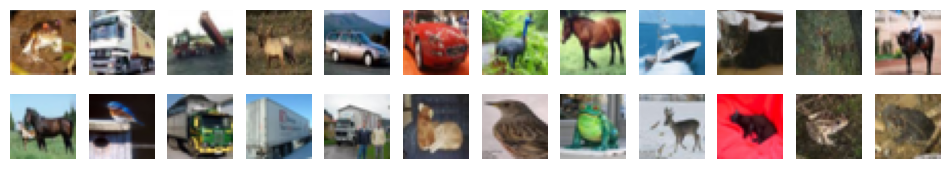

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0
print(x_train_full.shape)
show_images(x_train_full, 2, 12)

In [4]:
def create_dataset(inputs, labels, shuffle=False, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((inputs, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

x_train = x_train_full[:45000]
y_train = y_train_full[:45000]
x_valid = x_train_full[45000:]
y_valid = y_train_full[45000:]

train_set = create_dataset(x_train, y_train, shuffle=True)
valid_set = create_dataset(x_valid, y_valid)
test_set = create_dataset(x_test, y_test)

In [5]:
def create_autoencoder_dataset(inputs, shuffle=False, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(inputs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    return ds.map(lambda x: (x, x)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


autoencoder_train_set = create_autoencoder_dataset(x_train, shuffle=True)
autoencoder_valid_set = create_autoencoder_dataset(x_valid)

In [6]:
classifier_train_set = train_set.take(16)
classifier_valid_set = valid_set.take(16)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(tf.constant(x_test)).batch(32)

# Autoencoders Training

In [180]:
root_dir = Path() / 'data/exrc10'

def get_dirs(folder):
    model_dir = root_dir / folder
    tensorboard_dir = model_dir / 'tensorboard'
    checkpoints_dir = model_dir / 'checkpoints'
    print(f'tensorboard --logdir=ch17/{tensorboard_dir}')
    return tensorboard_dir, checkpoints_dir


def get_callbacks(folder, patience=5):
    tensorboard_dir, checkpoints_dir = get_dirs(folder)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(tensorboard_dir)
    checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(checkpoints_dir, save_best_only=True)
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

    return [tensorboard_cb, checkpoints_cb, earlystop_cb]

def sample_autoencode(wrapper, encoder_override=None):
    encoder: tf.keras.Model = wrapper['encoder']
    trainable_weights = np.sum([tf.keras.backend.count_params(x) for x in encoder.trainable_weights])
    non_trainable_weights = np.sum([tf.keras.backend.count_params(x) for x in encoder.non_trainable_weights])
    print('trainable_weights:', trainable_weights, 'non_trainable_weights:', non_trainable_weights)
    if encoder_override:
        model = tf.keras.Sequential([encoder_override, wrapper['decoder']])
    else:
        model = wrapper['model']
    images = model.predict(x_train_full[:12])
    show_images(x_train_full[:12], 1, 12)
    show_images(images, 1, 12)

def show_neuron_activation(wrapper, factor=1):
    encoder = wrapper['encoder']
    encoded_x_test = encoder.predict(test_ds).reshape(x_test.shape[0], -1)
    indices = np.argsort(y_test.reshape(-1))
    z = encoded_x_test[indices].reshape(10, 1000, -1)
    neurons = np.mean(z, axis=1)
    _, ax = plt.subplots(figsize=(np.round(4 * factor), np.round(4 * factor)))
    cmap = colors.LinearSegmentedColormap.from_list("", ["white", "red"])
    ax.matshow(neurons.T, cmap=cmap, aspect=neurons.shape[0] / neurons.shape[1])
    ax.vlines([x + 0.5 for x in range(neurons.shape[0])], 0, neurons.shape[1] - 0.5, colors='white', linewidths=np.round(4 * factor))

def autoencoder_wrapper(folder, regularizer, encoder, decoder, model, train_set=None, validation_set=None):
    train_set = train_set if train_set else autoencoder_train_set
    validation_set = validation_set if validation_set else autoencoder_valid_set

    object = {
        'regularizer': regularizer, 
        'encoder': encoder, 
        'decoder': decoder,
        'model': model, 
    }

    def load_or_fit(patience=5, epochs=20, force_fit=False):
        _, checkpoints_dir = get_dirs(folder)
        if not force_fit and Path(checkpoints_dir).exists():
            loaded_model = tf.keras.models.load_model(checkpoints_dir)
            object['model'] = loaded_model
            return loaded_model
        else:
            callbacks = get_callbacks(folder, patience)
            return model.fit(train_set, epochs=epochs, validation_data=validation_set, callbacks=callbacks)

    object['load_or_fit'] = load_or_fit    
    return object

def classifier_wrapper(folder, encoder, model):
    object = {
        'encoder': encoder,
        'model': model
    }

    def load_or_fit(patience=5, epochs=50, force_fit=False):
        _, checkpoints_dir = get_dirs(folder)
        if not force_fit and Path(checkpoints_dir).exists():
            loaded_model = tf.keras.models.load_model(checkpoints_dir)
            object['model'] = loaded_model
            return loaded_model
        else:
            callbacks = get_callbacks(folder, patience)
            return model.fit(classifier_train_set, epochs=epochs, validation_data=classifier_valid_set, callbacks=callbacks)

    object['load_or_fit'] = load_or_fit    
    return object


## Autoencoder 1 - GaussianNoise 0.5, 3072 -> 2048

In [75]:
def create_ae01():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.GaussianNoise(0.5),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.SeparableConv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.GlobalMaxPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(4 * 4 * 128),
        tf.keras.layers.Reshape([4, 4, 128]),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae01', regularizer, encoder, decoder, model) 

ae01 = create_ae01()

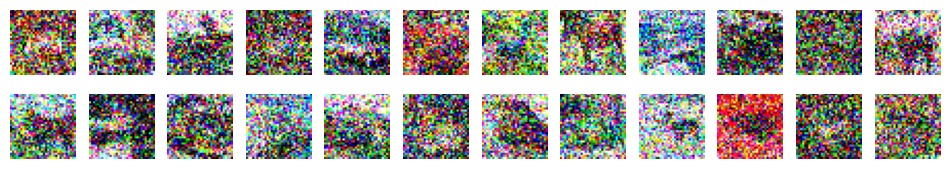

In [112]:
noisy_images = ae01['regularizer'](x_train_full[:24], training=True)
show_images(noisy_images, 2, 12)

In [76]:
ae01['load_or_fit'](epochs=20, patience=5)

tensorboard --logdir=ch17/data/exrc10/ae01/tensorboard


### Results

trainable_weights: 0.0 non_trainable_weights: 12347
1/1 [==============================] - 0s 28ms/step


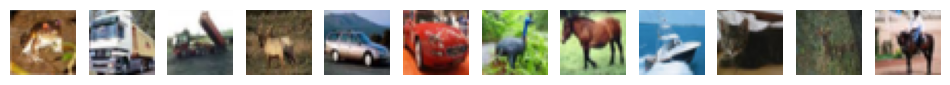

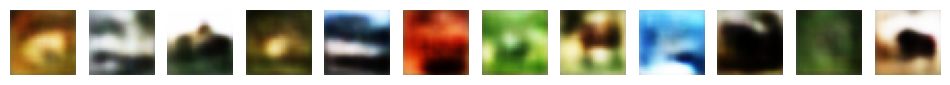

In [150]:
sample_autoencode(ae01)

 12/313 [>.............................] - ETA: 1s

313/313 [==============================] - 1s 3ms/step


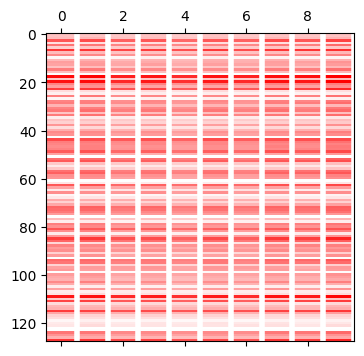

In [181]:
show_neuron_activation(ae01)

## Autoencoder 2 - No BN, Noise 0.3; 3072 -> 2048

In [81]:
def create_ae02():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.GaussianNoise(0.3),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.SeparableConv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.GlobalMaxPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(4 * 4 * 128),
        tf.keras.layers.Reshape([4, 4, 128]),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae02', regularizer, encoder, decoder, model)

ae02 = create_ae02()

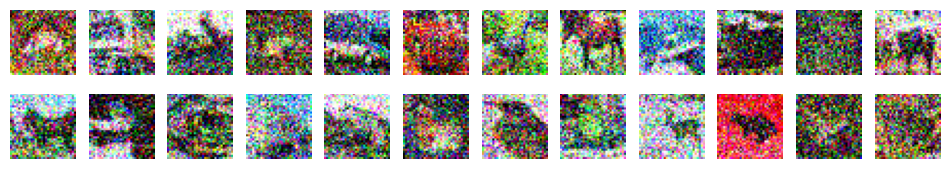

In [13]:
noisy_images = ae02['regularizer'](x_train_full[:24], training=True)
show_images(noisy_images, 2, 12)

In [82]:
ae02['load_or_fit'](epochs=20, patience=5)

tensorboard --logdir=ch17/data/exrc10/ae02/tensorboard


### Results

trainable_weights: 0.0 non_trainable_weights: 11451
1/1 [==============================] - 0s 17ms/step


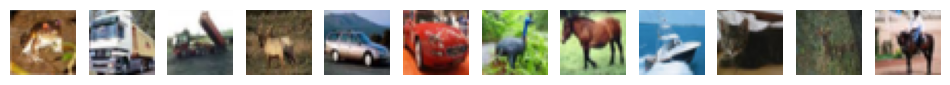

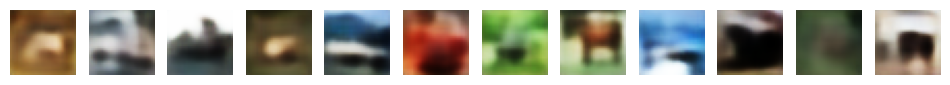

In [151]:
sample_autoencode(ae02)

 14/313 [>.............................] - ETA: 1s

313/313 [==============================] - 1s 2ms/step


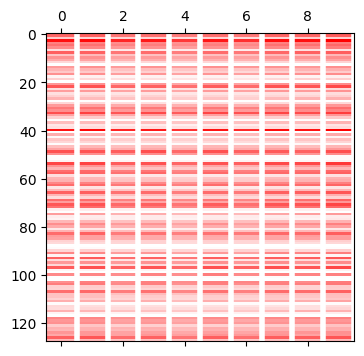

In [182]:
show_neuron_activation(ae02)

## Autoencoder 3 - no convolution

In [84]:
def create_ae03():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.GaussianNoise(0.3),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(32 * 32 * 3, activation='sigmoid'),
        tf.keras.layers.Reshape([32, 32, 3])
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae03', regularizer, encoder, decoder, model)

ae03 = create_ae03()

In [85]:
ae03['load_or_fit'](epochs=20, patience=5)

tensorboard --logdir=ch17/data/exrc10/ae03/tensorboard


### Results

trainable_weights: 0.0 non_trainable_weights: 3671552
1/1 [==============================] - 0s 18ms/step


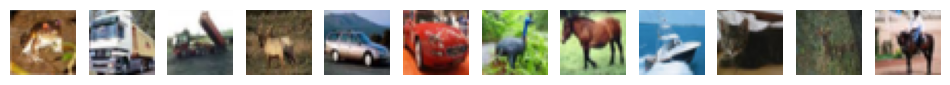

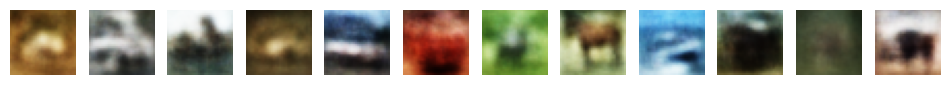

In [152]:
sample_autoencode(ae03)

 20/313 [>.............................] - ETA: 0s

313/313 [==============================] - 1s 2ms/step


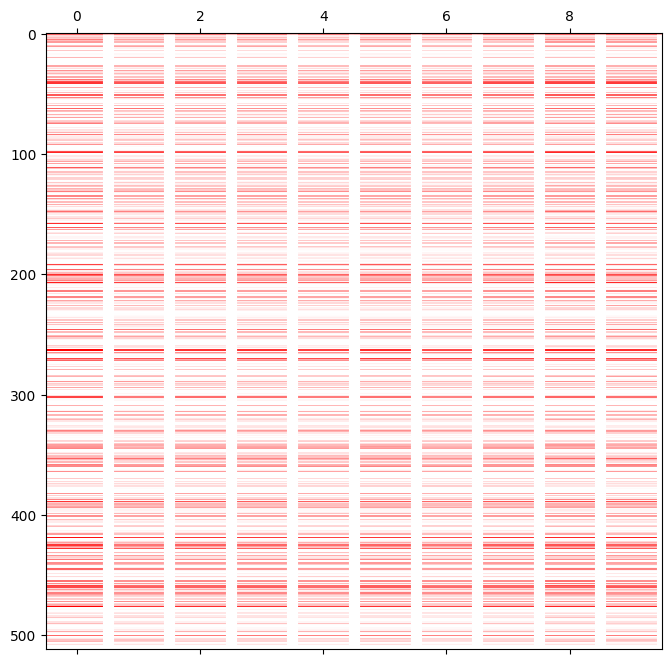

In [183]:
show_neuron_activation(ae03, 2)

## Autoencoder 4 - without separable convolutions

In [87]:
def create_ae04():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.GaussianNoise(0.3),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.GlobalMaxPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(4 * 4 * 128),
        tf.keras.layers.Reshape([4, 4, 128]),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae04', regularizer, encoder, decoder, model)

ae04 = create_ae04()
ae04['load_or_fit'](epochs=20, patience=5)

tensorboard --logdir=ch17/data/exrc10/ae04/tensorboard


### Results

trainable_weights: 0.0 non_trainable_weights: 93248
1/1 [==============================] - 0s 29ms/step


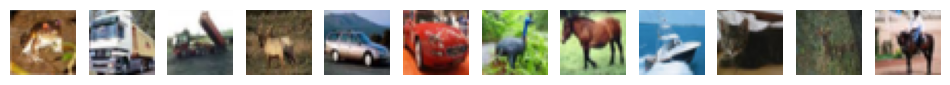

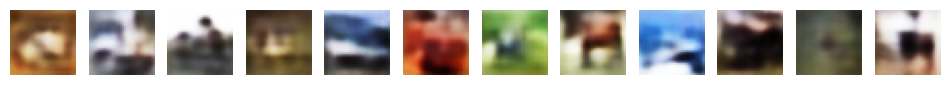

In [153]:
sample_autoencode(ae04)

 14/313 [>.............................] - ETA: 1s

313/313 [==============================] - 1s 3ms/step


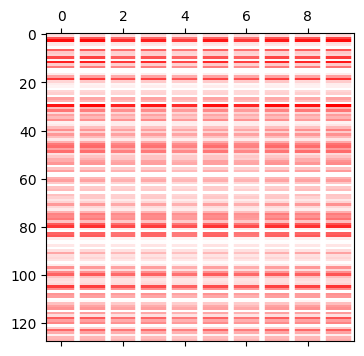

In [184]:
show_neuron_activation(ae04)

## Autoencoder 5 - without noise all together

In [89]:
def create_ae05():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        # tf.keras.layers.GaussianNoise(0.6),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.GlobalAvgPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * 2 * 256),
        tf.keras.layers.Reshape([2, 2, 256]),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    model.build(input_shape=(32, 32, 32, 3))
    return autoencoder_wrapper('ae05', regularizer, encoder, decoder, model)

ae05 = create_ae05()
ae05['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae05/tensorboard


### Results

trainable_weights: 1568576 non_trainable_weights: 0.0
1/1 [==============================] - 0s 24ms/step


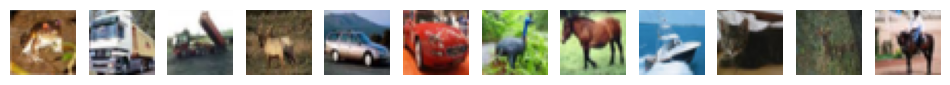

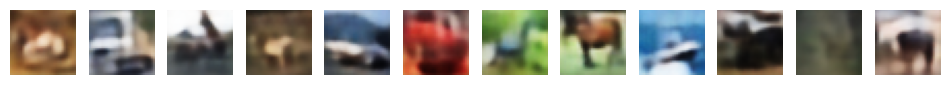

In [154]:
sample_autoencode(ae05)

  8/313 [..............................] - ETA: 2s

313/313 [==============================] - 1s 3ms/step


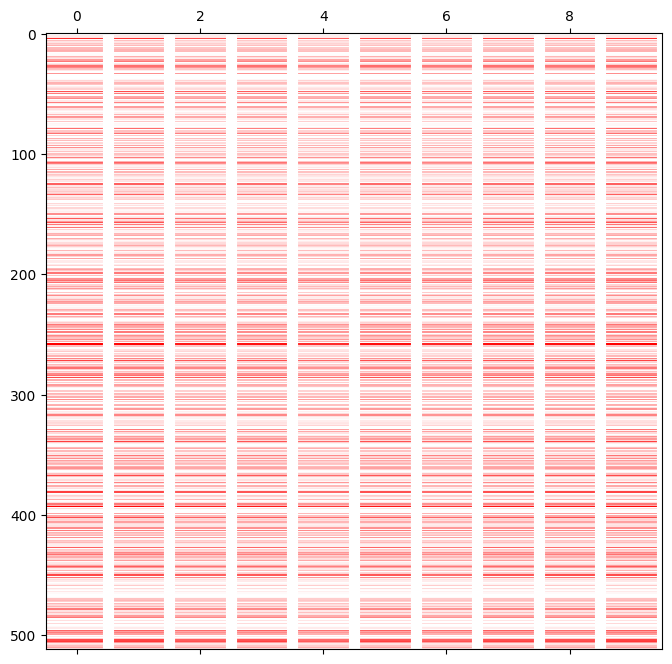

In [185]:
show_neuron_activation(ae05, 2)

## Autoencoder 6 - gray scale, no noise

In [91]:
def create_ae06():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1)[..., tf.newaxis])
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.GlobalAvgPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * 2 * 256),
        tf.keras.layers.Reshape([2, 2, 256]),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    train_set = autoencoder_train_set.map(lambda x, y: (x, regularizer(y)))
    validation_set = autoencoder_valid_set.map(lambda x, y: (x, regularizer(y)))
    return autoencoder_wrapper('ae06', regularizer, encoder, decoder, model, train_set=train_set, validation_set=validation_set)

ae06 = create_ae06()

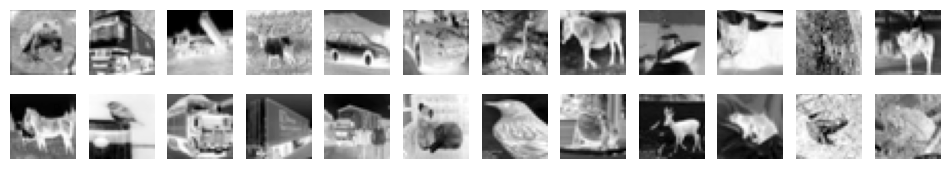

In [117]:
noisy_images = ae06['regularizer'](x_train_full[:24], training=True)
show_images(noisy_images, 2, 12)

In [92]:
ae06['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae06/tensorboard


### Results

trainable_weights: 0.0 non_trainable_weights: 1568000
1/1 [==============================] - 0s 35ms/step


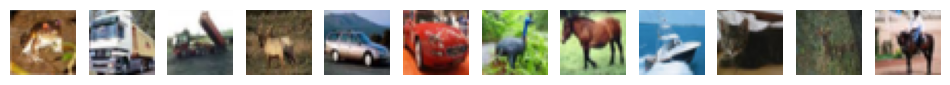

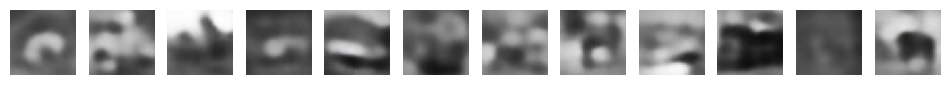

In [155]:
sample_autoencode(ae06)

 15/313 [>.............................] - ETA: 2s

313/313 [==============================] - 1s 3ms/step


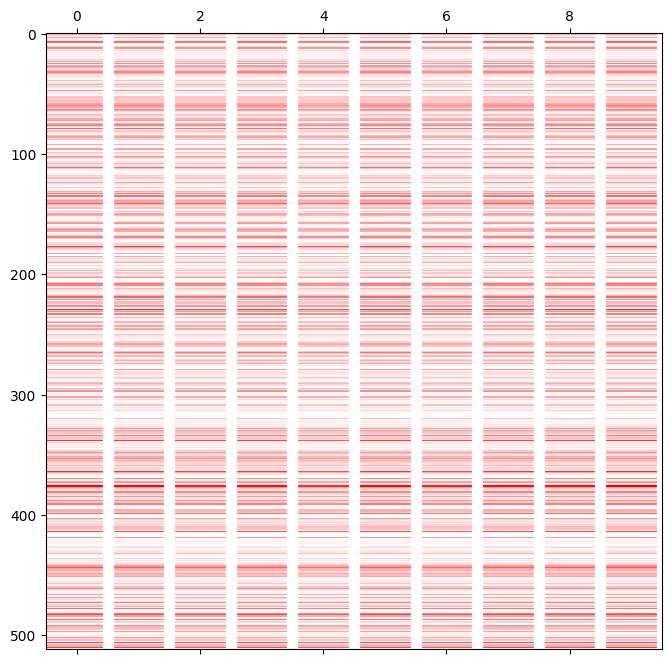

In [186]:
show_neuron_activation(ae06, 2)

## Autoencoder 7 - like AE02 without noise

In [94]:
def create_ae07():
    regularizer = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[32, 32, 3]),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))
    ])

    encoder = tf.keras.Sequential([
        regularizer,
        tf.keras.layers.SeparableConv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.GlobalMaxPool2D()
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * 2 * 256),
        tf.keras.layers.Reshape([2, 2, 256]),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae07', regularizer, encoder, decoder, model)

ae07 = create_ae07()
ae07['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae07/tensorboard
tensorboard --logdir=ch17/data/exrc10/ae07/tensorboard
Epoch 1/20
1066/1407 [=====================>........] - ETA: 5s - loss: 0.0325 - mean_squared_error: 0.0325

KeyboardInterrupt: 

### Results

trainable_weights: 11451 non_trainable_weights: 0.0
1/1 [==============================] - 0s 130ms/step


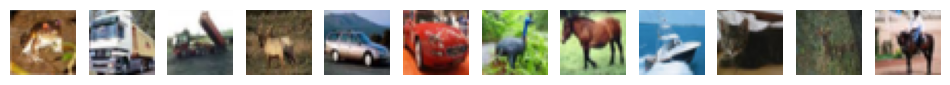

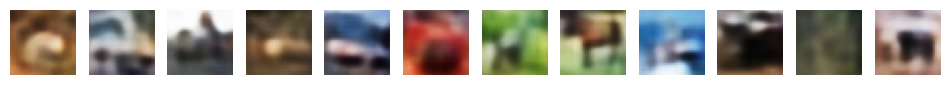

In [158]:
sample_autoencode(ae07)

trainable_weights: 45627 non_trainable_weights: 0.0
1/1 [==============================] - 1s 566ms/step


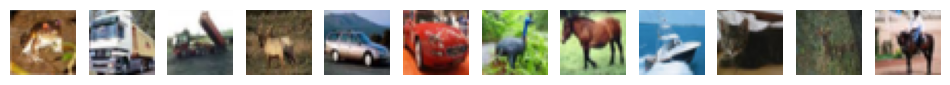

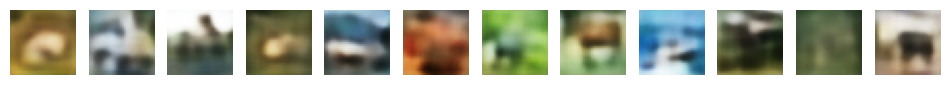

In [162]:
sample_autoencode(ae07)

313/313 [==============================] - 1s 3ms/step


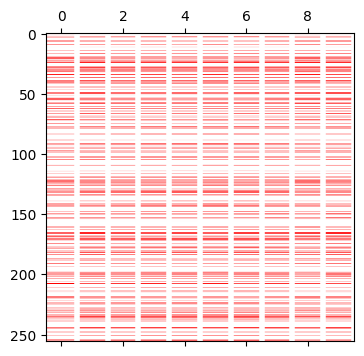

In [187]:
show_neuron_activation(ae07)

## Autoencoder 8 - Residual Learning, no noise

In [95]:
def create_ae08():
    input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(input)
    skip = Z
    for dim in (64, 128, 256):
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    output = tf.keras.layers.GlobalMaxPool2D()(Z)
    encoder = tf.keras.Model(inputs=[input], outputs=[output])


    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * 2 * 256),
        tf.keras.layers.Reshape([2, 2, 256]),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae08', None, encoder, decoder, model)

ae08 = create_ae08()
ae08['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae08/tensorboard


### Results

trainable_weights: 180320 non_trainable_weights: 0.0
1/1 [==============================] - 1s 871ms/step


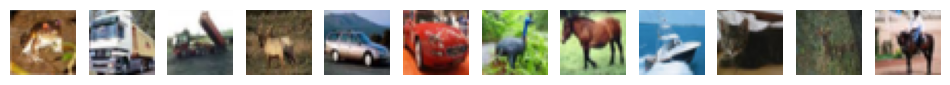

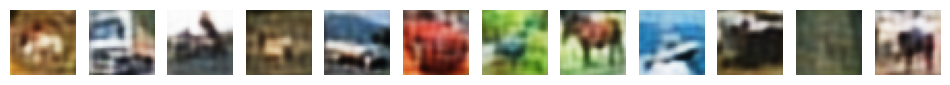

In [186]:
sample_autoencode(ae08)

  4/313 [..............................] - ETA: 6s

313/313 [==============================] - 1s 4ms/step


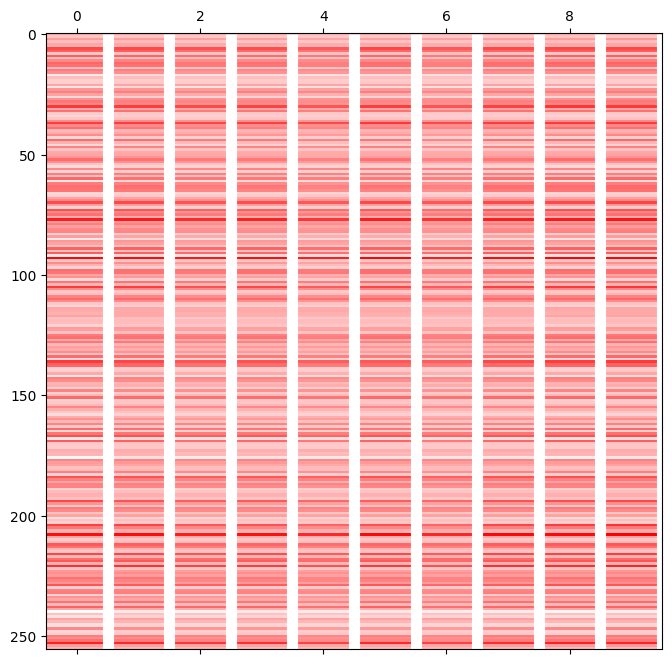

In [188]:
show_neuron_activation(ae08, 2)

## Autoencoder 9 - Avg Pooling and 512 dims

In [97]:
def create_ae09():
    encoder_steps = [64, 128, 256, 512]
    decoder_steps = encoder_steps[:-1][::-1]

    encoder_input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(encoder_input)
    skip = Z
    for dim in encoder_steps:
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    encoder_output = tf.keras.layers.GlobalAvgPool2D()(Z)
    encoder = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_output])

    decoder_input = tf.keras.layers.Input(shape=encoder_output.shape[1:])
    
    spatial_start = 32 // 2 ** len(decoder_steps)
    Z = tf.keras.layers.Dense(spatial_start * spatial_start * decoder_steps[0], activation='relu', kernel_initializer='he_normal')(decoder_input)
    Z = tf.keras.layers.Reshape([spatial_start, spatial_start, decoder_steps[0]])(Z)
    for dim in decoder_steps:
        Z = tf.keras.layers.Conv2DTranspose(dim, strides=2, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(Z)
    decoder = tf.keras.Model(inputs=[decoder_input], outputs=[decoder_output])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae09', None, encoder, decoder, model)

ae09 = create_ae09()
ae09['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae09/tensorboard


### Results

trainable_weights: 713056 non_trainable_weights: 0.0
1/1 [==============================] - 13s 13s/step


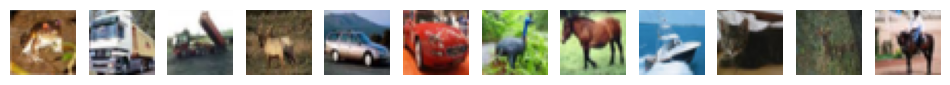

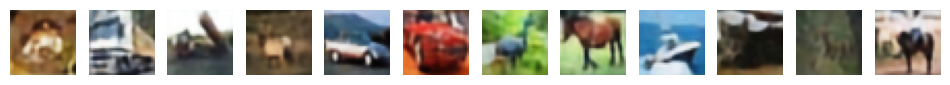

In [9]:
sample_autoencode(ae09)

 13/313 [>.............................] - ETA: 7s

313/313 [==============================] - 1s 5ms/step


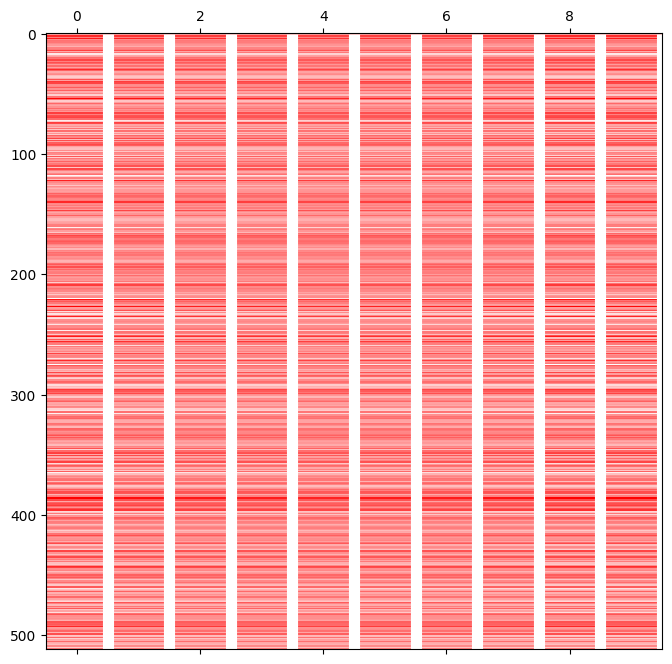

In [189]:
show_neuron_activation(ae09, 2)

## Autoencoder 10 - like 9 with MAE

In [98]:
def create_ae10():
    encoder_steps = [64, 128, 256, 512]
    decoder_steps = encoder_steps[:-1][::-1]

    encoder_input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(encoder_input)
    skip = Z
    for dim in encoder_steps:
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    encoder_output = tf.keras.layers.GlobalAvgPool2D()(Z)
    encoder = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_output])

    decoder_input = tf.keras.layers.Input(shape=encoder_output.shape[1:])
    
    spatial_start = 32 // 2 ** len(decoder_steps)
    Z = tf.keras.layers.Dense(spatial_start * spatial_start * decoder_steps[0], activation='relu', kernel_initializer='he_normal')(decoder_input)
    Z = tf.keras.layers.Reshape([spatial_start, spatial_start, decoder_steps[0]])(Z)
    for dim in decoder_steps:
        Z = tf.keras.layers.Conv2DTranspose(dim, strides=2, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(Z)
    decoder = tf.keras.Model(inputs=[decoder_input], outputs=[decoder_output])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mae,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mae]
    )
    return autoencoder_wrapper('ae10', None, encoder, decoder, model)

ae10 = create_ae10()
ae10['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae10/tensorboard


### Results

trainable_weights: 713056 non_trainable_weights: 0.0
1/1 [==============================] - 0s 267ms/step


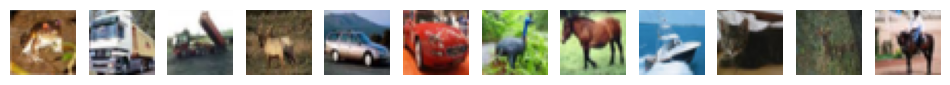

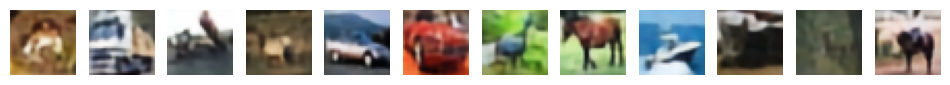

In [25]:
sample_autoencode(ae10)

  4/313 [..............................] - ETA: 7s

313/313 [==============================] - 2s 5ms/step


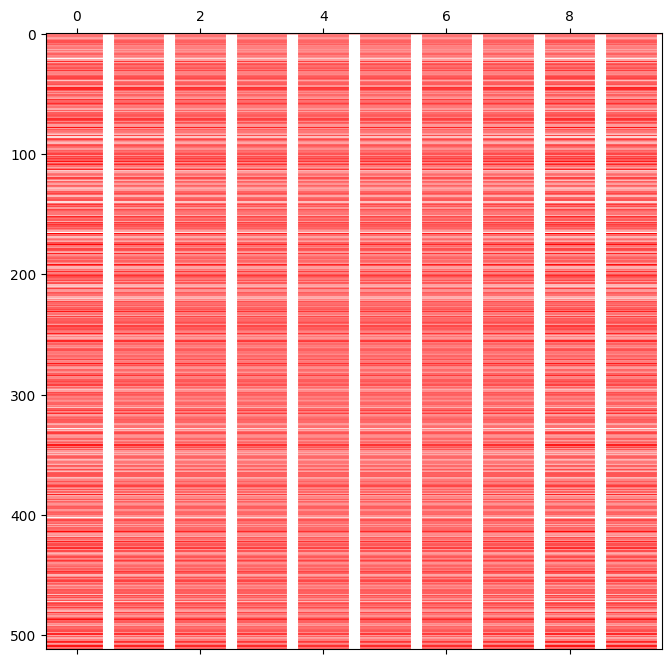

In [190]:
show_neuron_activation(ae10, 2)

## Autoencoder 11 - like 10 with BN

In [100]:
def create_ae11():
    encoder_steps = [64, 128, 256, 512]
    decoder_steps = encoder_steps[:-1][::-1]

    encoder_input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(encoder_input)
    skip = Z
    for dim in encoder_steps:
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.ReLU()(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    encoder_output = tf.keras.layers.GlobalAvgPool2D()(Z)
    encoder = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_output])

    decoder_input = tf.keras.layers.Input(shape=encoder_output.shape[1:])
    
    spatial_start = 32 // 2 ** len(decoder_steps)
    Z = tf.keras.layers.Dense(spatial_start * spatial_start * decoder_steps[0], activation='relu', kernel_initializer='he_normal')(decoder_input)
    Z = tf.keras.layers.Reshape([spatial_start, spatial_start, decoder_steps[0]])(Z)
    for dim in decoder_steps:
        Z = tf.keras.layers.Conv2DTranspose(dim, kernel_size=3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.ReLU()(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, strides=2, kernel_size=3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(Z)
    decoder = tf.keras.Model(inputs=[decoder_input], outputs=[decoder_output])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mae,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mae]
    )
    return autoencoder_wrapper('ae11', None, encoder, decoder, model)

ae11 = create_ae11()
ae11['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae11/tensorboard


### Results

trainable_weights: 716896 non_trainable_weights: 3840
1/1 [==============================] - 0s 26ms/step


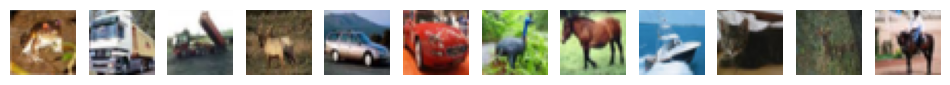

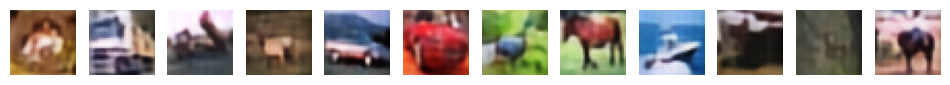

In [51]:
sample_autoencode(ae11)

  5/313 [..............................] - ETA: 4s

313/313 [==============================] - 1s 5ms/step


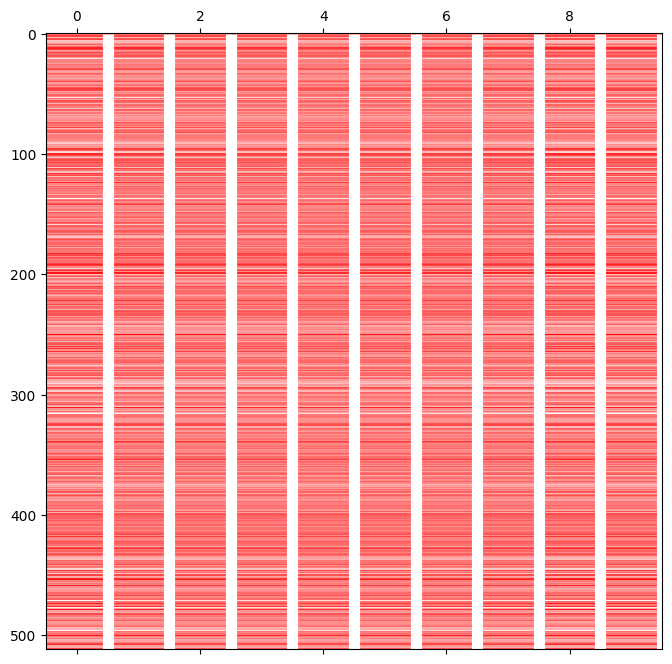

In [191]:
show_neuron_activation(ae11, 2)

## Autoencoder 12 - like 10 with SE Blocks

In [102]:
def create_ae12():
    encoder_steps = [64, 128, 256, 512]
    decoder_steps = encoder_steps[:-1][::-1]

    encoder_input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(encoder_input)
    skip = Z
    for dim in encoder_steps:
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        se_block = tf.keras.layers.GlobalAvgPool2D()(Z)
        se_block = tf.keras.layers.Dense(dim // 16, activation='relu', kernel_initializer='he_normal')(se_block)
        se_block = tf.keras.layers.Dense(dim, activation='sigmoid')(se_block)
        se_block = tf.keras.layers.Reshape([1, 1, -1])(se_block)
        
        Z = tf.keras.layers.Multiply()([se_block, Z])

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    encoder_output = tf.keras.layers.GlobalAvgPool2D()(Z)
    encoder = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_output])

    decoder_input = tf.keras.layers.Input(shape=encoder_output.shape[1:])
    
    spatial_start = 32 // 2 ** len(decoder_steps)
    Z = tf.keras.layers.Dense(spatial_start * spatial_start * decoder_steps[0], activation='relu', kernel_initializer='he_normal')(decoder_input)
    Z = tf.keras.layers.Reshape([spatial_start, spatial_start, decoder_steps[0]])(Z)
    for dim in decoder_steps:
        Z = tf.keras.layers.Conv2DTranspose(dim, strides=2, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(Z)
    decoder = tf.keras.Model(inputs=[decoder_input], outputs=[decoder_output])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mae,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mae]
    )
    return autoencoder_wrapper('ae12', None, encoder, decoder, model)

ae12 = create_ae12()
ae12['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae12/tensorboard


### Results

trainable_weights: 757596 non_trainable_weights: 0.0
1/1 [==============================] - 0s 383ms/step


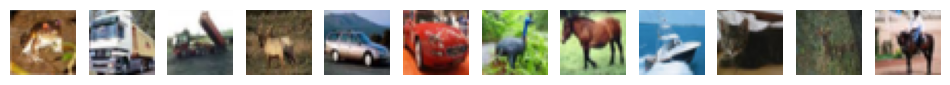

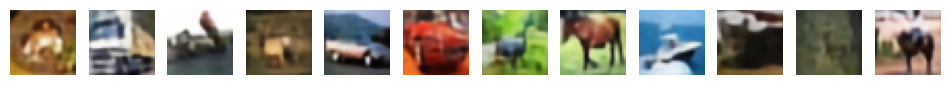

In [57]:
sample_autoencode(ae12)

  4/313 [..............................] - ETA: 7s

313/313 [==============================] - 2s 6ms/step


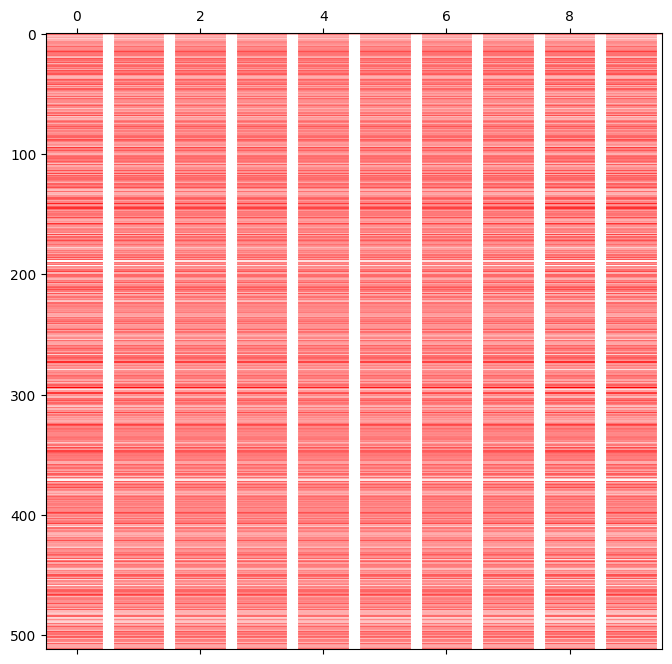

In [192]:
show_neuron_activation(ae12, 2)

## Autoencoder 13 - like 9 with noise

In [194]:
def create_ae13():
    encoder_steps = [64, 128, 256, 512]
    decoder_steps = encoder_steps[:-1][::-1]

    encoder_input = tf.keras.layers.Input(shape=[32, 32, 3], dtype=tf.float32)
    Z = tf.keras.layers.GaussianNoise(0.3)(encoder_input)
    regularizer = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))(Z)

    Z = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
    skip = Z
    for dim in encoder_steps:
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
        Z = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(Z)

        skip_connection = tf.keras.layers.Conv2D(dim, kernel_size=1, strides=2, padding='same')(skip)
        Z = tf.keras.layers.Add()([skip_connection, Z])
        skip = Z
    encoder_output = tf.keras.layers.GlobalAvgPool2D()(Z)
    encoder = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_output])

    decoder_input = tf.keras.layers.Input(shape=encoder_output.shape[1:])
    
    spatial_start = 32 // 2 ** len(decoder_steps)
    Z = tf.keras.layers.Dense(spatial_start * spatial_start * decoder_steps[0], activation='relu', kernel_initializer='he_normal')(decoder_input)
    Z = tf.keras.layers.Reshape([spatial_start, spatial_start, decoder_steps[0]])(Z)
    for dim in decoder_steps:
        Z = tf.keras.layers.Conv2DTranspose(dim, strides=2, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')(Z)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(Z)
    decoder = tf.keras.Model(inputs=[decoder_input], outputs=[decoder_output])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer='nadam',
        metrics=[tf.keras.metrics.mse]
    )
    return autoencoder_wrapper('ae13', regularizer, encoder, decoder, model)

ae13 = create_ae13()
ae13['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae13/tensorboard


### Results

trainable_weights: 713056 non_trainable_weights: 0.0
1/1 [==============================] - 0s 240ms/step


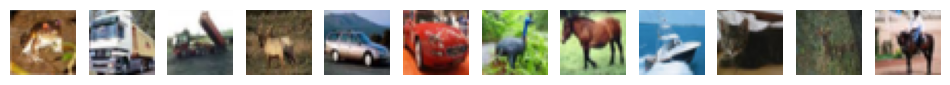

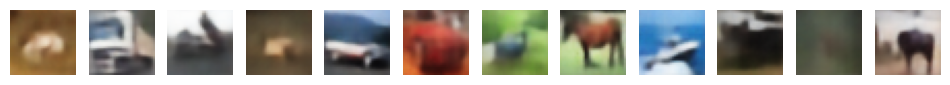

In [195]:
sample_autoencode(ae13)

  4/313 [..............................] - ETA: 7s

313/313 [==============================] - 1s 5ms/step


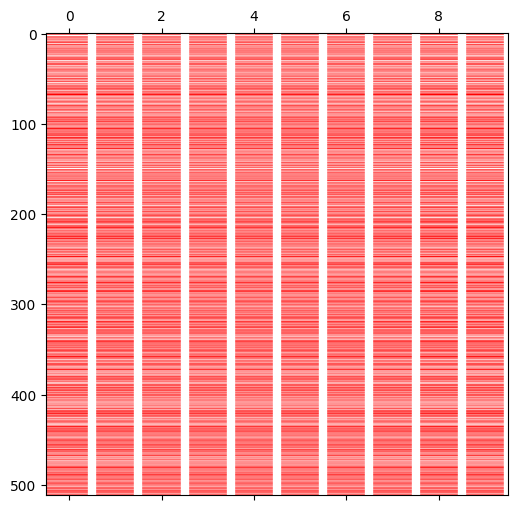

In [200]:
show_neuron_activation(ae13, 1.5)

## Autoencoder 14: Book

In [108]:
def create_ae14():
    encoder = tf.keras.Sequential([
        tf.keras.layers.GaussianNoise(0.1),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
        tf.keras.layers.Reshape([16, 16, 32]),
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                    padding="same", activation="sigmoid")
    ])

    model = tf.keras.Sequential([encoder, decoder])
    model.compile(
        loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['mse']
    )
    return autoencoder_wrapper('ae14', None, encoder, decoder, model)

ae14 = create_ae14()
ae14['load_or_fit']()

tensorboard --logdir=ch17/data/exrc10/ae14/tensorboard
tensorboard --logdir=ch17/data/exrc10/ae14/tensorboard
Epoch 1/20
1407/1407 [==============================] - ETA: 0s - loss: 0.5857 - mse: 0.0155

1407/1407 [==============================] - 17s 10ms/step - loss: 0.5857 - mse: 0.0155 - val_loss: 0.6017 - val_mse: 0.0196
Epoch 2/20
1405/1407 [============================>.] - ETA: 0s - loss: 0.5685 - mse: 0.0083

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5685 - mse: 0.0083 - val_loss: 0.5853 - val_mse: 0.0131
Epoch 3/20
1402/1407 [============================>.] - ETA: 0s - loss: 0.5653 - mse: 0.0071

1407/1407 [==============================] - 13s 10ms/step - loss: 0.5653 - mse: 0.0071 - val_loss: 0.5749 - val_mse: 0.0096
Epoch 4/20
1407/1407 [==============================] - ETA: 0s - loss: 0.5640 - mse: 0.0066

1407/1407 [==============================] - 13s 10ms/step - loss: 0.5640 - mse: 0.0066 - val_loss: 0.5686 - val_mse: 0.0073
Epoch 5/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5633 - mse: 0.0064 - val_loss: 0.5691 - val_mse: 0.0076
Epoch 6/20
1401/1407 [============================>.] - ETA: 0s - loss: 0.5628 - mse: 0.0062

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5628 - mse: 0.0062 - val_loss: 0.5681 - val_mse: 0.0073
Epoch 7/20
1401/1407 [============================>.] - ETA: 0s - loss: 0.5624 - mse: 0.0061

1407/1407 [==============================] - 13s 10ms/step - loss: 0.5624 - mse: 0.0061 - val_loss: 0.5674 - val_mse: 0.0070
Epoch 8/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.5620 - mse: 0.0059

1407/1407 [==============================] - 13s 10ms/step - loss: 0.5620 - mse: 0.0059 - val_loss: 0.5670 - val_mse: 0.0069
Epoch 9/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5618 - mse: 0.0059 - val_loss: 0.5672 - val_mse: 0.0070
Epoch 10/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.5616 - mse: 0.0058

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5616 - mse: 0.0058 - val_loss: 0.5663 - val_mse: 0.0067
Epoch 11/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5614 - mse: 0.0057 - val_loss: 0.5667 - val_mse: 0.0068
Epoch 12/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.5613 - mse: 0.0057

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5613 - mse: 0.0057 - val_loss: 0.5654 - val_mse: 0.0062
Epoch 13/20
1407/1407 [==============================] - ETA: 0s - loss: 0.5612 - mse: 0.0057

1407/1407 [==============================] - 13s 10ms/step - loss: 0.5612 - mse: 0.0057 - val_loss: 0.5650 - val_mse: 0.0062
Epoch 14/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.5611 - mse: 0.0056

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5611 - mse: 0.0056 - val_loss: 0.5649 - val_mse: 0.0061
Epoch 15/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.5610 - mse: 0.0056

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5610 - mse: 0.0056 - val_loss: 0.5649 - val_mse: 0.0060
Epoch 16/20
1406/1407 [============================>.] - ETA: 0s - loss: 0.5609 - mse: 0.0056

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5609 - mse: 0.0056 - val_loss: 0.5641 - val_mse: 0.0058
Epoch 17/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5608 - mse: 0.0055 - val_loss: 0.5641 - val_mse: 0.0058
Epoch 18/20
1407/1407 [==============================] - 12s 9ms/step - loss: 0.5607 - mse: 0.0055 - val_loss: 0.5642 - val_mse: 0.0058
Epoch 19/20
1403/1407 [============================>.] - ETA: 0s - loss: 0.5606 - mse: 0.0054

1407/1407 [==============================] - 14s 10ms/step - loss: 0.5606 - mse: 0.0054 - val_loss: 0.5637 - val_mse: 0.0056
Epoch 20/20
1407/1407 [==============================] - 13s 9ms/step - loss: 0.5605 - mse: 0.0054 - val_loss: 0.5638 - val_mse: 0.0057


### Results

trainable_weights: 4195712 non_trainable_weights: 0.0
1/1 [==============================] - 0s 345ms/step


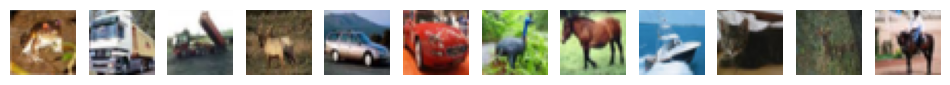

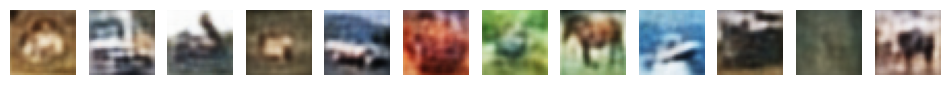

In [109]:
sample_autoencode(ae14)

 14/313 [>.............................] - ETA: 1s

313/313 [==============================] - 1s 3ms/step


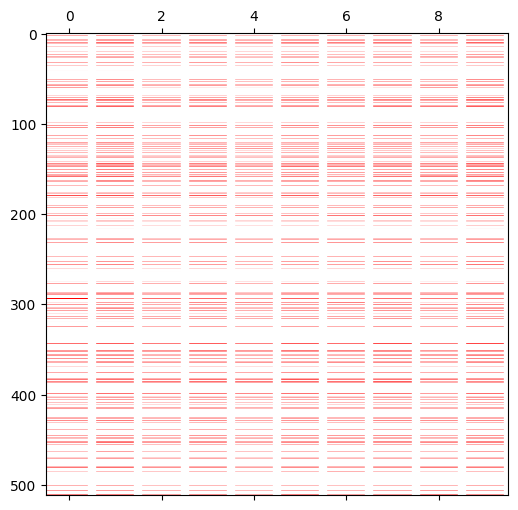

In [199]:
show_neuron_activation(ae14, 1.5)

# Classification
---

## Classifier setup

In [83]:
def build_classifier(folder, encoder=None):
    new_encoder = None
    default_encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.GlobalMaxPool2D()
    ])
    default_decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation='softmax'),        
    ])
    input = tf.keras.layers.Input(shape=(32, 32, 3))
    Z = default_encoder(input)
    if encoder:
        new_encoder = tf.keras.models.clone_model(encoder)
        new_encoder.set_weights(encoder.get_weights())
        new_encoder.trainable = False
        
        pretrained_encoder_output = new_encoder(input)
        flattened_pretrained_encoder = tf.keras.layers.Flatten()(pretrained_encoder_output)

        Z = tf.keras.layers.Dense(flattened_pretrained_encoder.shape[1], activation='relu', kernel_initializer='he_normal')(Z)
        Z = tf.keras.layers.Concatenate(axis=-1)([Z, flattened_pretrained_encoder])
        # Z = tf.keras.layers.Add()([Z, flattened_pretrained_encoder])
    output = default_decoder(Z)
    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-4),
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )
    return classifier_wrapper(folder, new_encoder, model)




def build_stacked_classifier(folder, encoder, non_trainable_epochs=30, trainable_epochs=30):
    new_encoder = tf.keras.models.clone_model(encoder)
    new_encoder.set_weights(encoder.get_weights())
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        new_encoder,
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation='softmax'),        
    ])

    def _compile(trainable):
        new_encoder.trainable = trainable
        model.compile(
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
            metrics=[tf.keras.metrics.sparse_categorical_accuracy]
        )

    def _fit():
        callbacks = get_callbacks(folder, patience=50)
        _compile(False)
        model.fit(classifier_train_set, epochs=non_trainable_epochs, validation_data=classifier_valid_set, callbacks=callbacks)
        _compile(True)
        model.fit(classifier_train_set, epochs=trainable_epochs, validation_data=classifier_valid_set, callbacks=callbacks)

    return {
        'model': model,
        'fit': _fit,
        'encoder': new_encoder
    }



def build_stacked_classifier_2(folder, encoder, non_trainable_epochs=30, trainable_epochs=30):
    new_encoder = tf.keras.models.clone_model(encoder)
    new_encoder.set_weights(encoder.get_weights())
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    Z = new_encoder(inputs)
    Z = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(Z)
    skip_link = tf.keras.layers.Conv2D(256, kernel_size=3)(inputs)
    skip_link = tf.keras.layers.GlobalAvgPool2D()(skip_link)
    Z = tf.keras.layers.Add()([Z, skip_link])
    Z = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(Z)
    output = tf.keras.layers.Dense(10, activation='softmax')(Z)
    model = tf.keras.Model(inputs=[inputs], outputs=[output])

    def _compile(trainable):
        new_encoder.trainable = trainable
        model.compile(
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
            metrics=[tf.keras.metrics.sparse_categorical_accuracy]
        )

    def _fit():
        callbacks = get_callbacks(folder, patience=50)
        _compile(False)
        model.fit(classifier_train_set, epochs=non_trainable_epochs, validation_data=classifier_valid_set, callbacks=callbacks)
        _compile(True)
        model.fit(classifier_train_set, epochs=trainable_epochs, validation_data=classifier_valid_set, callbacks=callbacks)

    return {
        'model': model,
        'encoder': new_encoder,
        'fit': _fit,
    }

## Without pretraining

In [226]:
c01 = build_classifier('c01')
c01['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c01/tensorboard
tensorboard --logdir=ch17/data/exrc10/c01/tensorboard
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.4684 - sparse_categorical_accuracy: 0.1191

16/16 [==============================] - 4s 89ms/step - loss: 2.4684 - sparse_categorical_accuracy: 0.1191 - val_loss: 2.3071 - val_sparse_categorical_accuracy: 0.1621
Epoch 2/50
13/16 [=======================>......] - ETA: 0s - loss: 2.2770 - sparse_categorical_accuracy: 0.1851

16/16 [==============================] - 1s 80ms/step - loss: 2.2729 - sparse_categorical_accuracy: 0.1875 - val_loss: 2.2117 - val_sparse_categorical_accuracy: 0.1387
Epoch 3/50
15/16 [===========================>..] - ETA: 0s - loss: 2.1281 - sparse_categorical_accuracy: 0.2021

16/16 [==============================] - 1s 76ms/step - loss: 2.1172 - sparse_categorical_accuracy: 0.2109 - val_loss: 2.1349 - val_sparse_categorical_accuracy: 0.2148
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0367 - sparse_categorical_accuracy: 0.2909

16/16 [==============================] - 1s 81ms/step - loss: 2.0447 - sparse_categorical_accuracy: 0.2754 - val_loss: 2.1027 - val_sparse_categorical_accuracy: 0.2363
Epoch 5/50
14/16 [=========================>....] - ETA: 0s - loss: 1.9902 - sparse_categorical_accuracy: 0.2500

16/16 [==============================] - 1s 81ms/step - loss: 2.0004 - sparse_categorical_accuracy: 0.2539 - val_loss: 1.9768 - val_sparse_categorical_accuracy: 0.2539
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 1.9111 - sparse_categorical_accuracy: 0.2598

16/16 [==============================] - 1s 83ms/step - loss: 1.9111 - sparse_categorical_accuracy: 0.2598 - val_loss: 1.9482 - val_sparse_categorical_accuracy: 0.2773
Epoch 7/50
15/16 [===========================>..] - ETA: 0s - loss: 1.8982 - sparse_categorical_accuracy: 0.3208

16/16 [==============================] - 1s 82ms/step - loss: 1.9071 - sparse_categorical_accuracy: 0.3145 - val_loss: 1.8960 - val_sparse_categorical_accuracy: 0.2793
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 1.8692 - sparse_categorical_accuracy: 0.3125

16/16 [==============================] - 1s 81ms/step - loss: 1.8692 - sparse_categorical_accuracy: 0.3125 - val_loss: 1.8171 - val_sparse_categorical_accuracy: 0.3105
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 1.7568 - sparse_categorical_accuracy: 0.3301

16/16 [==============================] - 1s 75ms/step - loss: 1.7568 - sparse_categorical_accuracy: 0.3301 - val_loss: 1.7841 - val_sparse_categorical_accuracy: 0.3477
Epoch 10/50
12/16 [=====================>........] - ETA: 0s - loss: 1.7095 - sparse_categorical_accuracy: 0.3698

16/16 [==============================] - 1s 79ms/step - loss: 1.7213 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.7122 - val_sparse_categorical_accuracy: 0.3594
Epoch 11/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7537 - sparse_categorical_accuracy: 0.3457 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.3496
Epoch 12/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6999 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.7204 - val_sparse_categorical_accuracy: 0.3184
Epoch 13/50
16/16 [==============================] - ETA: 0s - loss: 1.7064 - sparse_categorical_accuracy: 0.3555

16/16 [==============================] - 1s 75ms/step - loss: 1.7064 - sparse_categorical_accuracy: 0.3555 - val_loss: 1.6584 - val_sparse_categorical_accuracy: 0.3926
Epoch 14/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6927 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.7296 - val_sparse_categorical_accuracy: 0.3496
Epoch 15/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5738 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.6653 - val_sparse_categorical_accuracy: 0.3711
Epoch 16/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5961 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.7211 - val_sparse_categorical_accuracy: 0.3359
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 1.6246 - sparse_categorical_accuracy: 0.4238

16/16 [==============================] - 1s 76ms/step - loss: 1.6246 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.6264 - val_sparse_categorical_accuracy: 0.3867
Epoch 18/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5904 - sparse_categorical_accuracy: 0.3906

16/16 [==============================] - 3s 207ms/step - loss: 1.5592 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.5994 - val_sparse_categorical_accuracy: 0.4023
Epoch 19/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5491 - sparse_categorical_accuracy: 0.4062

16/16 [==============================] - 1s 84ms/step - loss: 1.5410 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.5507 - val_sparse_categorical_accuracy: 0.4238
Epoch 20/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6360 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.5591 - val_sparse_categorical_accuracy: 0.4043
Epoch 21/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4664 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5851 - val_sparse_categorical_accuracy: 0.4062
Epoch 22/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5002 - sparse_categorical_accuracy: 0.4492 - val_loss: 1.6264 - val_sparse_categorical_accuracy: 0.3965
Epoch 23/50
16/16 [==============================] - ETA: 0s - loss: 1.4405 - sparse_categorical_accuracy: 0.4648

16/16 [==============================] - 1s 75ms/step - loss: 1.4405 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.5320 - val_sparse_categorical_accuracy: 0.4453
Epoch 24/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4726 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.6426 - val_sparse_categorical_accuracy: 0.4004
Epoch 25/50
16/16 [==============================] - ETA: 0s - loss: 1.5133 - sparse_categorical_accuracy: 0.4414

16/16 [==============================] - 1s 94ms/step - loss: 1.5133 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.4920 - val_sparse_categorical_accuracy: 0.4434
Epoch 26/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4165 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.6238 - val_sparse_categorical_accuracy: 0.3848
Epoch 27/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4944 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.5087 - val_sparse_categorical_accuracy: 0.4277
Epoch 28/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4510 - sparse_categorical_accuracy: 0.4604

16/16 [==============================] - 1s 77ms/step - loss: 1.4571 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.4789 - val_sparse_categorical_accuracy: 0.4473
Epoch 29/50
16/16 [==============================] - ETA: 0s - loss: 1.4211 - sparse_categorical_accuracy: 0.4980

16/16 [==============================] - 1s 76ms/step - loss: 1.4211 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.4650 - val_sparse_categorical_accuracy: 0.4395
Epoch 30/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4003 - sparse_categorical_accuracy: 0.4832

16/16 [==============================] - 1s 79ms/step - loss: 1.3968 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.4247 - val_sparse_categorical_accuracy: 0.4688
Epoch 31/50
16/16 [==============================] - 0s 23ms/step - loss: 1.4363 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.4628 - val_sparse_categorical_accuracy: 0.4688
Epoch 32/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4314 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.4252 - val_sparse_categorical_accuracy: 0.4648
Epoch 33/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4054 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.4795 - val_sparse_categorical_accuracy: 0.4551
Epoch 34/50
14/16 [=========================>....] - ETA: 0s - loss: 1.3982 - sparse_categorical_accuracy: 0.5112

16/16 [==============================] - 1s 75ms/step - loss: 1.3491 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.4005 - val_sparse_categorical_accuracy: 0.4824
Epoch 35/50
16/16 [==============================] - 0s 17ms/step - loss: 1.3624 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.4490 - val_sparse_categorical_accuracy: 0.4688
Epoch 36/50
16/16 [==============================] - 0s 15ms/step - loss: 1.3853 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.4522 - val_sparse_categorical_accuracy: 0.4570
Epoch 37/50
16/16 [==============================] - 0s 17ms/step - loss: 1.3813 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.4378 - val_sparse_categorical_accuracy: 0.4531
Epoch 38/50
16/16 [==============================] - ETA: 0s - loss: 1.4377 - sparse_categorical_accuracy: 0.4785

16/16 [==============================] - 1s 74ms/step - loss: 1.4377 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.3960 - val_sparse_categorical_accuracy: 0.4609
Epoch 39/50
16/16 [==============================] - 0s 16ms/step - loss: 1.2982 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.4364 - val_sparse_categorical_accuracy: 0.4707
Epoch 40/50
16/16 [==============================] - 0s 17ms/step - loss: 1.2649 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.4033 - val_sparse_categorical_accuracy: 0.4883
Epoch 41/50
15/16 [===========================>..] - ETA: 0s - loss: 1.3295 - sparse_categorical_accuracy: 0.5208

16/16 [==============================] - 1s 82ms/step - loss: 1.3367 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.3612 - val_sparse_categorical_accuracy: 0.5039
Epoch 42/50
16/16 [==============================] - 0s 17ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.4158 - val_sparse_categorical_accuracy: 0.4902
Epoch 43/50
16/16 [==============================] - 0s 16ms/step - loss: 1.2545 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.3842 - val_sparse_categorical_accuracy: 0.4941
Epoch 44/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3215 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.3890 - val_sparse_categorical_accuracy: 0.4941
Epoch 45/50
12/16 [=====================>........] - ETA: 0s - loss: 1.2160 - sparse_categorical_accuracy: 0.5573

16/16 [==============================] - 1s 75ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.3398 - val_sparse_categorical_accuracy: 0.5234
Epoch 46/50
11/16 [===================>..........] - ETA: 0s - loss: 1.2907 - sparse_categorical_accuracy: 0.5483

16/16 [==============================] - 1s 74ms/step - loss: 1.2693 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.3102 - val_sparse_categorical_accuracy: 0.5156
Epoch 47/50
16/16 [==============================] - 0s 17ms/step - loss: 1.0924 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.5795 - val_sparse_categorical_accuracy: 0.4785
Epoch 48/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3102 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.3489 - val_sparse_categorical_accuracy: 0.5117
Epoch 49/50
16/16 [==============================] - 0s 17ms/step - loss: 1.1649 - sparse_categorical_accuracy: 0.6016 - val_loss: 1.3669 - val_sparse_categorical_accuracy: 0.5176
Epoch 50/50
11/16 [===================>..........] - ETA: 0s - loss: 1.2863 - sparse_categorical_accuracy: 0.5398

16/16 [==============================] - 1s 74ms/step - loss: 1.3137 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.2841 - val_sparse_categorical_accuracy: 0.5039


### Results

In [227]:
c01['model'].evaluate(test_set)

 22/313 [=>............................] - ETA: 1s - loss: 1.3160 - sparse_categorical_accuracy: 0.5426

313/313 [==============================] - 1s 5ms/step - loss: 1.3207 - sparse_categorical_accuracy: 0.5179


[1.320725440979004, 0.5178999900817871]

## With pretraining AE01

In [168]:
c02 = build_classifier('c02', ae01['encoder'])
c02['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c02/tensorboard
tensorboard --logdir=ch17/data/exrc10/c02/tensorboard
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.3319 - sparse_categorical_accuracy: 0.1484

16/16 [==============================] - 4s 171ms/step - loss: 2.3319 - sparse_categorical_accuracy: 0.1484 - val_loss: 2.1907 - val_sparse_categorical_accuracy: 0.2148
Epoch 2/50
15/16 [===========================>..] - ETA: 0s - loss: 2.1709 - sparse_categorical_accuracy: 0.1937

16/16 [==============================] - 2s 147ms/step - loss: 2.1733 - sparse_categorical_accuracy: 0.1914 - val_loss: 2.1603 - val_sparse_categorical_accuracy: 0.1699
Epoch 3/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0853 - sparse_categorical_accuracy: 0.2308

16/16 [==============================] - 2s 145ms/step - loss: 2.0774 - sparse_categorical_accuracy: 0.2363 - val_loss: 2.0895 - val_sparse_categorical_accuracy: 0.2051
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 2.0042 - sparse_categorical_accuracy: 0.2578

16/16 [==============================] - 4s 253ms/step - loss: 2.0042 - sparse_categorical_accuracy: 0.2578 - val_loss: 1.9849 - val_sparse_categorical_accuracy: 0.2617
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.9423 - sparse_categorical_accuracy: 0.2812

16/16 [==============================] - 2s 156ms/step - loss: 1.9423 - sparse_categorical_accuracy: 0.2812 - val_loss: 1.9656 - val_sparse_categorical_accuracy: 0.2695
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 1.8682 - sparse_categorical_accuracy: 0.3164

16/16 [==============================] - 3s 166ms/step - loss: 1.8682 - sparse_categorical_accuracy: 0.3164 - val_loss: 1.9622 - val_sparse_categorical_accuracy: 0.2754
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 1.8464 - sparse_categorical_accuracy: 0.2910

16/16 [==============================] - 2s 160ms/step - loss: 1.8464 - sparse_categorical_accuracy: 0.2910 - val_loss: 1.9179 - val_sparse_categorical_accuracy: 0.3105
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 1.7601 - sparse_categorical_accuracy: 0.3320

16/16 [==============================] - 3s 175ms/step - loss: 1.7601 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.7960 - val_sparse_categorical_accuracy: 0.3438
Epoch 9/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7039 - sparse_categorical_accuracy: 0.3661

16/16 [==============================] - 2s 151ms/step - loss: 1.7266 - sparse_categorical_accuracy: 0.3613 - val_loss: 1.7924 - val_sparse_categorical_accuracy: 0.3398
Epoch 10/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6595 - sparse_categorical_accuracy: 0.3562

16/16 [==============================] - 4s 247ms/step - loss: 1.6609 - sparse_categorical_accuracy: 0.3555 - val_loss: 1.7356 - val_sparse_categorical_accuracy: 0.3496
Epoch 11/50
16/16 [==============================] - 0s 26ms/step - loss: 1.6700 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.8191 - val_sparse_categorical_accuracy: 0.3203
Epoch 12/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6605 - sparse_categorical_accuracy: 0.3772

16/16 [==============================] - 2s 147ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.7298 - val_sparse_categorical_accuracy: 0.3594
Epoch 13/50
16/16 [==============================] - ETA: 0s - loss: 1.6429 - sparse_categorical_accuracy: 0.4023

16/16 [==============================] - 2s 144ms/step - loss: 1.6429 - sparse_categorical_accuracy: 0.4023 - val_loss: 1.6919 - val_sparse_categorical_accuracy: 0.3945
Epoch 14/50
16/16 [==============================] - 0s 29ms/step - loss: 1.5882 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.7094 - val_sparse_categorical_accuracy: 0.3691
Epoch 15/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5172 - sparse_categorical_accuracy: 0.4663

16/16 [==============================] - 2s 141ms/step - loss: 1.5456 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.6541 - val_sparse_categorical_accuracy: 0.3770
Epoch 16/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5824 - sparse_categorical_accuracy: 0.4062

16/16 [==============================] - 2s 148ms/step - loss: 1.5449 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.5588 - val_sparse_categorical_accuracy: 0.4473
Epoch 17/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5122 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.6736 - val_sparse_categorical_accuracy: 0.4023
Epoch 18/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5379 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.5740 - val_sparse_categorical_accuracy: 0.4043
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.4825 - sparse_categorical_accuracy: 0.4766

16/16 [==============================] - 2s 143ms/step - loss: 1.4825 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.5060 - val_sparse_categorical_accuracy: 0.4551
Epoch 20/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5122 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.5125 - val_sparse_categorical_accuracy: 0.4473
Epoch 21/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4422 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.5194 - val_sparse_categorical_accuracy: 0.4531
Epoch 22/50
12/16 [=====================>........] - ETA: 0s - loss: 1.4516 - sparse_categorical_accuracy: 0.4375

16/16 [==============================] - 2s 145ms/step - loss: 1.4343 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.4908 - val_sparse_categorical_accuracy: 0.4531
Epoch 23/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4320 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.5637 - val_sparse_categorical_accuracy: 0.4297
Epoch 24/50
16/16 [==============================] - 0s 21ms/step - loss: 1.4151 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.5923 - val_sparse_categorical_accuracy: 0.4316
Epoch 25/50
16/16 [==============================] - 0s 24ms/step - loss: 1.4183 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.5447 - val_sparse_categorical_accuracy: 0.4414
Epoch 26/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.4949 - val_sparse_categorical_accuracy: 0.4805
Epoch 27/50
11/16 [===================>..........] - ETA: 0s - loss: 1.3153 - sparse_categorical_accuracy: 0.53

16/16 [==============================] - 4s 251ms/step - loss: 1.3605 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.4761 - val_sparse_categorical_accuracy: 0.4844
Epoch 28/50
16/16 [==============================] - 0s 25ms/step - loss: 1.3572 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.5741 - val_sparse_categorical_accuracy: 0.4355
Epoch 29/50
16/16 [==============================] - 0s 15ms/step - loss: 1.3725 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4985 - val_sparse_categorical_accuracy: 0.4492
Epoch 30/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4185 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.4951 - val_sparse_categorical_accuracy: 0.4414
Epoch 31/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2810 - sparse_categorical_accuracy: 0.5144

16/16 [==============================] - 2s 150ms/step - loss: 1.2859 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.4633 - val_sparse_categorical_accuracy: 0.4688
Epoch 32/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4065 - sparse_categorical_accuracy: 0.4760

16/16 [==============================] - 2s 143ms/step - loss: 1.3822 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.4198 - val_sparse_categorical_accuracy: 0.4883
Epoch 33/50
16/16 [==============================] - ETA: 0s - loss: 1.3521 - sparse_categorical_accuracy: 0.4961

16/16 [==============================] - 2s 155ms/step - loss: 1.3521 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.3694 - val_sparse_categorical_accuracy: 0.5117
Epoch 34/50
16/16 [==============================] - 0s 26ms/step - loss: 1.3476 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.4148 - val_sparse_categorical_accuracy: 0.4922
Epoch 35/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3126 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.3887 - val_sparse_categorical_accuracy: 0.4961
Epoch 36/50
16/16 [==============================] - 0s 15ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.3904 - val_sparse_categorical_accuracy: 0.5020
Epoch 37/50
12/16 [=====================>........] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.5651

16/16 [==============================] - 2s 158ms/step - loss: 1.1846 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.3340 - val_sparse_categorical_accuracy: 0.5059
Epoch 38/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.3913 - val_sparse_categorical_accuracy: 0.4980
Epoch 39/50
12/16 [=====================>........] - ETA: 0s - loss: 1.2856 - sparse_categorical_accuracy: 0.5182

16/16 [==============================] - 2s 134ms/step - loss: 1.3056 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.3094 - val_sparse_categorical_accuracy: 0.5273
Epoch 40/50
16/16 [==============================] - 0s 23ms/step - loss: 1.2150 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.3890 - val_sparse_categorical_accuracy: 0.5059
Epoch 41/50
16/16 [==============================] - 0s 22ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.3687 - val_sparse_categorical_accuracy: 0.5059
Epoch 42/50
16/16 [==============================] - 0s 22ms/step - loss: 1.2337 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.3472 - val_sparse_categorical_accuracy: 0.4941
Epoch 43/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.3256 - val_sparse_categorical_accuracy: 0.5312
Epoch 44/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2431 - sparse_categorical_accuracy: 0.52

16/16 [==============================] - 2s 147ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.2775 - val_sparse_categorical_accuracy: 0.5371
Epoch 45/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.2864 - val_sparse_categorical_accuracy: 0.5234
Epoch 46/50
16/16 [==============================] - 0s 20ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.3222 - val_sparse_categorical_accuracy: 0.5254
Epoch 47/50
16/16 [==============================] - 0s 15ms/step - loss: 1.2411 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.2965 - val_sparse_categorical_accuracy: 0.5332
Epoch 48/50
16/16 [==============================] - 0s 14ms/step - loss: 1.1403 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.3641 - val_sparse_categorical_accuracy: 0.4980
Epoch 49/50
16/16 [==============================] - 0s 16ms/step - loss: 1.1817 - sparse_categorical_accuracy:

### Results

In [169]:
c02['model'].evaluate(test_set)

 23/313 [=>............................] - ETA: 1s - loss: 1.2594 - sparse_categorical_accuracy: 0.5476

313/313 [==============================] - 2s 5ms/step - loss: 1.2628 - sparse_categorical_accuracy: 0.5427


[1.262803554534912, 0.5426999926567078]

## With pretraining Autoencoder AE02

In [170]:
c03 = build_classifier('c03', ae02['encoder'])
c03['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c03/tensorboard
tensorboard --logdir=ch17/data/exrc10/c03/tensorboard
Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 2.3904 - sparse_categorical_accuracy: 0.1187

16/16 [==============================] - 6s 258ms/step - loss: 2.3775 - sparse_categorical_accuracy: 0.1191 - val_loss: 2.2930 - val_sparse_categorical_accuracy: 0.1523
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2184 - sparse_categorical_accuracy: 0.1797

16/16 [==============================] - 2s 133ms/step - loss: 2.2184 - sparse_categorical_accuracy: 0.1797 - val_loss: 2.1903 - val_sparse_categorical_accuracy: 0.1992
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.1169 - sparse_categorical_accuracy: 0.2051

16/16 [==============================] - 2s 121ms/step - loss: 2.1169 - sparse_categorical_accuracy: 0.2051 - val_loss: 2.0459 - val_sparse_categorical_accuracy: 0.2695
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 2.0274 - sparse_categorical_accuracy: 0.2461 - val_loss: 2.1319 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/50
12/16 [=====================>........] - ETA: 0s - loss: 1.9680 - sparse_categorical_accuracy: 0.2943

16/16 [==============================] - 2s 129ms/step - loss: 1.9653 - sparse_categorical_accuracy: 0.2852 - val_loss: 1.9240 - val_sparse_categorical_accuracy: 0.3008
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 1.8782 - sparse_categorical_accuracy: 0.3223

16/16 [==============================] - 2s 118ms/step - loss: 1.8782 - sparse_categorical_accuracy: 0.3223 - val_loss: 1.9049 - val_sparse_categorical_accuracy: 0.2891
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 1.9119 - sparse_categorical_accuracy: 0.2754

16/16 [==============================] - 2s 123ms/step - loss: 1.9119 - sparse_categorical_accuracy: 0.2754 - val_loss: 1.8317 - val_sparse_categorical_accuracy: 0.3379
Epoch 8/50
12/16 [=====================>........] - ETA: 0s - loss: 1.8649 - sparse_categorical_accuracy: 0.3438

16/16 [==============================] - 2s 120ms/step - loss: 1.8308 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.7878 - val_sparse_categorical_accuracy: 0.3613
Epoch 9/50
16/16 [==============================] - 0s 17ms/step - loss: 1.8009 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.8255 - val_sparse_categorical_accuracy: 0.3262
Epoch 10/50
13/16 [=======================>......] - ETA: 0s - loss: 1.8258 - sparse_categorical_accuracy: 0.3486

16/16 [==============================] - 2s 117ms/step - loss: 1.8110 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.7125 - val_sparse_categorical_accuracy: 0.3574
Epoch 11/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6686 - sparse_categorical_accuracy: 0.4082 - val_loss: 1.9894 - val_sparse_categorical_accuracy: 0.2832
Epoch 12/50
16/16 [==============================] - 0s 24ms/step - loss: 1.7138 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.7615 - val_sparse_categorical_accuracy: 0.3262
Epoch 13/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7368 - sparse_categorical_accuracy: 0.3527

16/16 [==============================] - 3s 227ms/step - loss: 1.7106 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.7058 - val_sparse_categorical_accuracy: 0.3340
Epoch 14/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5941 - sparse_categorical_accuracy: 0.4241

16/16 [==============================] - 2s 119ms/step - loss: 1.5918 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.6541 - val_sparse_categorical_accuracy: 0.3887
Epoch 15/50
16/16 [==============================] - ETA: 0s - loss: 1.5988 - sparse_categorical_accuracy: 0.4023

16/16 [==============================] - 2s 120ms/step - loss: 1.5988 - sparse_categorical_accuracy: 0.4023 - val_loss: 1.6253 - val_sparse_categorical_accuracy: 0.4082
Epoch 16/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6765 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.6295 - val_sparse_categorical_accuracy: 0.4004
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 1.5485 - sparse_categorical_accuracy: 0.4395

16/16 [==============================] - 2s 118ms/step - loss: 1.5485 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.5681 - val_sparse_categorical_accuracy: 0.4336
Epoch 18/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5444 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.5827 - val_sparse_categorical_accuracy: 0.4102
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.5553 - sparse_categorical_accuracy: 0.4336

16/16 [==============================] - 2s 127ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5400 - val_sparse_categorical_accuracy: 0.4336
Epoch 20/50
12/16 [=====================>........] - ETA: 0s - loss: 1.5319 - sparse_categorical_accuracy: 0.4479

16/16 [==============================] - 2s 122ms/step - loss: 1.5157 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.5321 - val_sparse_categorical_accuracy: 0.4297
Epoch 21/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5312 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.5865 - val_sparse_categorical_accuracy: 0.4141
Epoch 22/50
16/16 [==============================] - ETA: 0s - loss: 1.5576 - sparse_categorical_accuracy: 0.4238

16/16 [==============================] - 2s 114ms/step - loss: 1.5576 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.5186 - val_sparse_categorical_accuracy: 0.4355
Epoch 23/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5495 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.5370 - val_sparse_categorical_accuracy: 0.4238
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 1.4562 - sparse_categorical_accuracy: 0.4316

16/16 [==============================] - 2s 117ms/step - loss: 1.4562 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.5037 - val_sparse_categorical_accuracy: 0.4336
Epoch 25/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5060 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 4s 238ms/step - loss: 1.4898 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.4920 - val_sparse_categorical_accuracy: 0.4844
Epoch 26/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3706 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.4997 - val_sparse_categorical_accuracy: 0.4551
Epoch 27/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4425 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.4997 - val_sparse_categorical_accuracy: 0.4336
Epoch 28/50
16/16 [==============================] - ETA: 0s - loss: 1.3969 - sparse_categorical_accuracy: 0.5137

16/16 [==============================] - 2s 122ms/step - loss: 1.3969 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.4366 - val_sparse_categorical_accuracy: 0.4844
Epoch 29/50
16/16 [==============================] - 0s 21ms/step - loss: 1.3933 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.4865 - val_sparse_categorical_accuracy: 0.4531
Epoch 30/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4179 - sparse_categorical_accuracy: 0.5045

16/16 [==============================] - 2s 120ms/step - loss: 1.4245 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4171 - val_sparse_categorical_accuracy: 0.4805
Epoch 31/50
16/16 [==============================] - 0s 13ms/step - loss: 1.3563 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.4246 - val_sparse_categorical_accuracy: 0.4805
Epoch 32/50
16/16 [==============================] - ETA: 0s - loss: 1.3762 - sparse_categorical_accuracy: 0.5000

16/16 [==============================] - 2s 124ms/step - loss: 1.3762 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.4067 - val_sparse_categorical_accuracy: 0.5000
Epoch 33/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3419 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.4454 - val_sparse_categorical_accuracy: 0.4902
Epoch 34/50
16/16 [==============================] - 0s 18ms/step - loss: 1.3480 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.4960 - val_sparse_categorical_accuracy: 0.4258
Epoch 35/50
16/16 [==============================] - 0s 18ms/step - loss: 1.3565 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.4688 - val_sparse_categorical_accuracy: 0.4746
Epoch 36/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3234 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.4220 - val_sparse_categorical_accuracy: 0.5078
Epoch 37/50
16/16 [==============================] - ETA: 0s - loss: 1.4056 - sparse_categorical_accuracy: 0.49

16/16 [==============================] - 2s 118ms/step - loss: 1.4056 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.3801 - val_sparse_categorical_accuracy: 0.4883
Epoch 38/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2870 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.4095 - val_sparse_categorical_accuracy: 0.4727
Epoch 39/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2314 - sparse_categorical_accuracy: 0.5352 - val_loss: 1.4340 - val_sparse_categorical_accuracy: 0.4902
Epoch 40/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.6599 - val_sparse_categorical_accuracy: 0.4102
Epoch 41/50
16/16 [==============================] - ETA: 0s - loss: 1.3570 - sparse_categorical_accuracy: 0.5039

16/16 [==============================] - 2s 117ms/step - loss: 1.3570 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.3564 - val_sparse_categorical_accuracy: 0.5137
Epoch 42/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2686 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.3939 - val_sparse_categorical_accuracy: 0.4668
Epoch 43/50
16/16 [==============================] - ETA: 0s - loss: 1.2661 - sparse_categorical_accuracy: 0.5527

16/16 [==============================] - 2s 121ms/step - loss: 1.2661 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.3386 - val_sparse_categorical_accuracy: 0.5117
Epoch 44/50
16/16 [==============================] - ETA: 0s - loss: 1.2442 - sparse_categorical_accuracy: 0.5801

16/16 [==============================] - 2s 120ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.3231 - val_sparse_categorical_accuracy: 0.5332
Epoch 45/50
15/16 [===========================>..] - ETA: 0s - loss: 1.2454 - sparse_categorical_accuracy: 0.5417

16/16 [==============================] - 3s 222ms/step - loss: 1.2322 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.2982 - val_sparse_categorical_accuracy: 0.5137
Epoch 46/50
16/16 [==============================] - 1s 30ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.3689 - val_sparse_categorical_accuracy: 0.5078
Epoch 47/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2631 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.3343 - val_sparse_categorical_accuracy: 0.5195
Epoch 48/50
16/16 [==============================] - 0s 14ms/step - loss: 1.1298 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.3145 - val_sparse_categorical_accuracy: 0.5391
Epoch 49/50
16/16 [==============================] - ETA: 0s - loss: 1.1793 - sparse_categorical_accuracy: 0.5586

16/16 [==============================] - 2s 128ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.2809 - val_sparse_categorical_accuracy: 0.5176
Epoch 50/50
16/16 [==============================] - 0s 21ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.3344 - val_sparse_categorical_accuracy: 0.5352


### Results

In [171]:
c03['model'].evaluate(test_set)

  9/313 [..............................] - ETA: 2s - loss: 1.4300 - sparse_categorical_accuracy: 0.4965

313/313 [==============================] - 1s 5ms/step - loss: 1.3613 - sparse_categorical_accuracy: 0.5089


[1.361302137374878, 0.508899986743927]

## With pretraining Autoencoder AE03

In [172]:
c04 = build_classifier('c04', ae03['encoder'])
c04['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c04/tensorboard
tensorboard --logdir=ch17/data/exrc10/c04/tensorboard
Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 2.3650 - sparse_categorical_accuracy: 0.1250

16/16 [==============================] - 4s 122ms/step - loss: 2.3712 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.2466 - val_sparse_categorical_accuracy: 0.1758
Epoch 2/50
13/16 [=======================>......] - ETA: 0s - loss: 2.2126 - sparse_categorical_accuracy: 0.1995

16/16 [==============================] - 2s 115ms/step - loss: 2.2160 - sparse_categorical_accuracy: 0.1816 - val_loss: 2.1384 - val_sparse_categorical_accuracy: 0.2012
Epoch 3/50
11/16 [===================>..........] - ETA: 0s - loss: 2.1005 - sparse_categorical_accuracy: 0.2557

16/16 [==============================] - 2s 113ms/step - loss: 2.0836 - sparse_categorical_accuracy: 0.2500 - val_loss: 2.0950 - val_sparse_categorical_accuracy: 0.2520
Epoch 4/50
14/16 [=========================>....] - ETA: 0s - loss: 2.0237 - sparse_categorical_accuracy: 0.2433

16/16 [==============================] - 2s 140ms/step - loss: 2.0398 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.0141 - val_sparse_categorical_accuracy: 0.2676
Epoch 5/50
15/16 [===========================>..] - ETA: 0s - loss: 1.9840 - sparse_categorical_accuracy: 0.2604

16/16 [==============================] - 2s 110ms/step - loss: 2.0007 - sparse_categorical_accuracy: 0.2520 - val_loss: 2.0108 - val_sparse_categorical_accuracy: 0.3027
Epoch 6/50
14/16 [=========================>....] - ETA: 0s - loss: 2.0028 - sparse_categorical_accuracy: 0.2879

16/16 [==============================] - 2s 115ms/step - loss: 2.0003 - sparse_categorical_accuracy: 0.2891 - val_loss: 1.9777 - val_sparse_categorical_accuracy: 0.2695
Epoch 7/50
13/16 [=======================>......] - ETA: 0s - loss: 1.9495 - sparse_categorical_accuracy: 0.2716

16/16 [==============================] - 2s 113ms/step - loss: 1.9476 - sparse_categorical_accuracy: 0.2734 - val_loss: 1.9773 - val_sparse_categorical_accuracy: 0.2793
Epoch 8/50
14/16 [=========================>....] - ETA: 0s - loss: 1.9357 - sparse_categorical_accuracy: 0.2924

16/16 [==============================] - 3s 215ms/step - loss: 1.9396 - sparse_categorical_accuracy: 0.2969 - val_loss: 1.9507 - val_sparse_categorical_accuracy: 0.2539
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 1.8503 - sparse_categorical_accuracy: 0.3242

16/16 [==============================] - 2s 125ms/step - loss: 1.8503 - sparse_categorical_accuracy: 0.3242 - val_loss: 1.8403 - val_sparse_categorical_accuracy: 0.3320
Epoch 10/50
16/16 [==============================] - 0s 24ms/step - loss: 1.8245 - sparse_categorical_accuracy: 0.3398 - val_loss: 1.8946 - val_sparse_categorical_accuracy: 0.3340
Epoch 11/50
16/16 [==============================] - ETA: 0s - loss: 1.7675 - sparse_categorical_accuracy: 0.3555

16/16 [==============================] - 2s 123ms/step - loss: 1.7675 - sparse_categorical_accuracy: 0.3555 - val_loss: 1.8154 - val_sparse_categorical_accuracy: 0.3203
Epoch 12/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7442 - sparse_categorical_accuracy: 0.3638

16/16 [==============================] - 2s 115ms/step - loss: 1.7375 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.7673 - val_sparse_categorical_accuracy: 0.3379
Epoch 13/50
15/16 [===========================>..] - ETA: 0s - loss: 1.7502 - sparse_categorical_accuracy: 0.3792

16/16 [==============================] - 2s 115ms/step - loss: 1.7488 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.7449 - val_sparse_categorical_accuracy: 0.3613
Epoch 14/50
16/16 [==============================] - ETA: 0s - loss: 1.6759 - sparse_categorical_accuracy: 0.3887

16/16 [==============================] - 2s 109ms/step - loss: 1.6759 - sparse_categorical_accuracy: 0.3887 - val_loss: 1.6934 - val_sparse_categorical_accuracy: 0.3613
Epoch 15/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6597 - sparse_categorical_accuracy: 0.3652 - val_loss: 1.7666 - val_sparse_categorical_accuracy: 0.3750
Epoch 16/50
16/16 [==============================] - ETA: 0s - loss: 1.6193 - sparse_categorical_accuracy: 0.4141

16/16 [==============================] - 2s 105ms/step - loss: 1.6193 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.6465 - val_sparse_categorical_accuracy: 0.3945
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 1.6388 - sparse_categorical_accuracy: 0.4258

16/16 [==============================] - 2s 107ms/step - loss: 1.6388 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.6223 - val_sparse_categorical_accuracy: 0.3945
Epoch 18/50
16/16 [==============================] - ETA: 0s - loss: 1.6483 - sparse_categorical_accuracy: 0.3848

16/16 [==============================] - 2s 105ms/step - loss: 1.6483 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.5965 - val_sparse_categorical_accuracy: 0.4180
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.5518 - sparse_categorical_accuracy: 0.3984

16/16 [==============================] - 3s 210ms/step - loss: 1.5518 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.5904 - val_sparse_categorical_accuracy: 0.3945
Epoch 20/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4647 - sparse_categorical_accuracy: 0.4591

16/16 [==============================] - 2s 125ms/step - loss: 1.4915 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.5699 - val_sparse_categorical_accuracy: 0.4219
Epoch 21/50
16/16 [==============================] - ETA: 0s - loss: 1.5936 - sparse_categorical_accuracy: 0.4277

16/16 [==============================] - 2s 110ms/step - loss: 1.5936 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.5474 - val_sparse_categorical_accuracy: 0.3848
Epoch 22/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5732 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.5588 - val_sparse_categorical_accuracy: 0.4004
Epoch 23/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5343 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.6316 - val_sparse_categorical_accuracy: 0.4043
Epoch 24/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4822 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.5533 - val_sparse_categorical_accuracy: 0.4043
Epoch 25/50
16/16 [==============================] - ETA: 0s - loss: 1.4897 - sparse_categorical_accuracy: 0.4336

16/16 [==============================] - 2s 106ms/step - loss: 1.4897 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5456 - val_sparse_categorical_accuracy: 0.4141
Epoch 26/50
16/16 [==============================] - ETA: 0s - loss: 1.5240 - sparse_categorical_accuracy: 0.4316

16/16 [==============================] - 2s 107ms/step - loss: 1.5240 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.4866 - val_sparse_categorical_accuracy: 0.4551
Epoch 27/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5138 - sparse_categorical_accuracy: 0.4492 - val_loss: 1.5214 - val_sparse_categorical_accuracy: 0.4355
Epoch 28/50
16/16 [==============================] - 0s 28ms/step - loss: 1.4962 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.4929 - val_sparse_categorical_accuracy: 0.4473
Epoch 29/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4545 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.4866 - val_sparse_categorical_accuracy: 0.4453
Epoch 30/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4984 - sparse_categorical_accuracy: 0.4531 - val_loss: 1.4886 - val_sparse_categorical_accuracy: 0.4609
Epoch 31/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4144 - sparse_categorical_accuracy:

### Results

In [173]:
c04['model'].evaluate(test_set)

 25/313 [=>............................] - ETA: 1s - loss: 1.5097 - sparse_categorical_accuracy: 0.4350

313/313 [==============================] - 1s 4ms/step - loss: 1.5002 - sparse_categorical_accuracy: 0.4513


[1.5001754760742188, 0.4512999951839447]

## With Pretraining Autoencoder AE04

In [174]:
c05 = build_classifier('c05', ae04['encoder'])
c05['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c05/tensorboard
tensorboard --logdir=ch17/data/exrc10/c05/tensorboard
Epoch 1/50


13/16 [=======================>......] - ETA: 0s - loss: 2.5213 - sparse_categorical_accuracy: 0.1274

16/16 [==============================] - 4s 137ms/step - loss: 2.4628 - sparse_categorical_accuracy: 0.1289 - val_loss: 2.3011 - val_sparse_categorical_accuracy: 0.1719
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2369 - sparse_categorical_accuracy: 0.1797

16/16 [==============================] - 2s 114ms/step - loss: 2.2369 - sparse_categorical_accuracy: 0.1797 - val_loss: 2.2880 - val_sparse_categorical_accuracy: 0.1582
Epoch 3/50
14/16 [=========================>....] - ETA: 0s - loss: 2.1776 - sparse_categorical_accuracy: 0.1942

16/16 [==============================] - 2s 118ms/step - loss: 2.1709 - sparse_categorical_accuracy: 0.1953 - val_loss: 2.2015 - val_sparse_categorical_accuracy: 0.1855
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 2.0584 - sparse_categorical_accuracy: 0.2402

16/16 [==============================] - 2s 113ms/step - loss: 2.0584 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.1681 - val_sparse_categorical_accuracy: 0.2324
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 2.0045 - sparse_categorical_accuracy: 0.2617 - val_loss: 2.1800 - val_sparse_categorical_accuracy: 0.2461
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 1.9099 - sparse_categorical_accuracy: 0.3105

16/16 [==============================] - 3s 217ms/step - loss: 1.9099 - sparse_categorical_accuracy: 0.3105 - val_loss: 2.1223 - val_sparse_categorical_accuracy: 0.2500
Epoch 7/50
16/16 [==============================] - 0s 30ms/step - loss: 1.8989 - sparse_categorical_accuracy: 0.2734 - val_loss: 2.1482 - val_sparse_categorical_accuracy: 0.1973
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 1.8724 - sparse_categorical_accuracy: 0.2988

16/16 [==============================] - 2s 116ms/step - loss: 1.8724 - sparse_categorical_accuracy: 0.2988 - val_loss: 2.0568 - val_sparse_categorical_accuracy: 0.2617
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 1.7938 - sparse_categorical_accuracy: 0.3496

16/16 [==============================] - 2s 117ms/step - loss: 1.7938 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.9829 - val_sparse_categorical_accuracy: 0.2930
Epoch 10/50
16/16 [==============================] - ETA: 0s - loss: 1.8310 - sparse_categorical_accuracy: 0.3242

16/16 [==============================] - 2s 118ms/step - loss: 1.8310 - sparse_categorical_accuracy: 0.3242 - val_loss: 1.9628 - val_sparse_categorical_accuracy: 0.2793
Epoch 11/50
16/16 [==============================] - 0s 16ms/step - loss: 1.7798 - sparse_categorical_accuracy: 0.3301 - val_loss: 2.0338 - val_sparse_categorical_accuracy: 0.2422
Epoch 12/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6916 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.9705 - val_sparse_categorical_accuracy: 0.3145
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7105 - sparse_categorical_accuracy: 0.3894

16/16 [==============================] - 2s 111ms/step - loss: 1.6987 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.9202 - val_sparse_categorical_accuracy: 0.3086
Epoch 14/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6885 - sparse_categorical_accuracy: 0.3667

16/16 [==============================] - 2s 131ms/step - loss: 1.6747 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.8435 - val_sparse_categorical_accuracy: 0.3535
Epoch 15/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6039 - sparse_categorical_accuracy: 0.4104

16/16 [==============================] - 2s 119ms/step - loss: 1.6000 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.7778 - val_sparse_categorical_accuracy: 0.3457
Epoch 16/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5903 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.8771 - val_sparse_categorical_accuracy: 0.3535
Epoch 17/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4836 - sparse_categorical_accuracy: 0.4625

16/16 [==============================] - 2s 120ms/step - loss: 1.4823 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.7646 - val_sparse_categorical_accuracy: 0.3633
Epoch 18/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5609 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.7857 - val_sparse_categorical_accuracy: 0.3457
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.5812 - sparse_categorical_accuracy: 0.3926

16/16 [==============================] - 3s 223ms/step - loss: 1.5812 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.7080 - val_sparse_categorical_accuracy: 0.3750
Epoch 20/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5843 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.8695 - val_sparse_categorical_accuracy: 0.3379
Epoch 21/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5786 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.7193 - val_sparse_categorical_accuracy: 0.3906
Epoch 22/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4988 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.7246 - val_sparse_categorical_accuracy: 0.3770
Epoch 23/50
16/16 [==============================] - ETA: 0s - loss: 1.4733 - sparse_categorical_accuracy: 0.4199

16/16 [==============================] - 2s 121ms/step - loss: 1.4733 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.7066 - val_sparse_categorical_accuracy: 0.3730
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 1.5071 - sparse_categorical_accuracy: 0.4375

16/16 [==============================] - 2s 136ms/step - loss: 1.5071 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.6941 - val_sparse_categorical_accuracy: 0.3906
Epoch 25/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5209 - sparse_categorical_accuracy: 0.4625

16/16 [==============================] - 2s 133ms/step - loss: 1.5216 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.6446 - val_sparse_categorical_accuracy: 0.3887
Epoch 26/50
16/16 [==============================] - ETA: 0s - loss: 1.4161 - sparse_categorical_accuracy: 0.4668

16/16 [==============================] - 2s 119ms/step - loss: 1.4161 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.6264 - val_sparse_categorical_accuracy: 0.4238
Epoch 27/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5151 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.8275 - val_sparse_categorical_accuracy: 0.3516
Epoch 28/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5209 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.6678 - val_sparse_categorical_accuracy: 0.3984
Epoch 29/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4427 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 2s 134ms/step - loss: 1.4378 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.6006 - val_sparse_categorical_accuracy: 0.4023
Epoch 30/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4353 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.6040 - val_sparse_categorical_accuracy: 0.4238
Epoch 31/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3817 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.6628 - val_sparse_categorical_accuracy: 0.3770
Epoch 32/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4194 - sparse_categorical_accuracy: 0.4784

16/16 [==============================] - 2s 124ms/step - loss: 1.3997 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5659 - val_sparse_categorical_accuracy: 0.4121
Epoch 33/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4676 - sparse_categorical_accuracy: 0.4313

16/16 [==============================] - 2s 128ms/step - loss: 1.4613 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.5358 - val_sparse_categorical_accuracy: 0.4375
Epoch 34/50
16/16 [==============================] - 0s 18ms/step - loss: 1.3983 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6956 - val_sparse_categorical_accuracy: 0.4121
Epoch 35/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3320 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.5799 - val_sparse_categorical_accuracy: 0.4551
Epoch 36/50
16/16 [==============================] - ETA: 0s - loss: 1.3209 - sparse_categorical_accuracy: 0.5000

16/16 [==============================] - 2s 117ms/step - loss: 1.3209 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.5267 - val_sparse_categorical_accuracy: 0.4531
Epoch 37/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4344 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.5522 - val_sparse_categorical_accuracy: 0.4277
Epoch 38/50
16/16 [==============================] - 0s 14ms/step - loss: 1.2625 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.5395 - val_sparse_categorical_accuracy: 0.4219
Epoch 39/50
16/16 [==============================] - 0s 14ms/step - loss: 1.2823 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.5676 - val_sparse_categorical_accuracy: 0.4180
Epoch 40/50
16/16 [==============================] - 0s 14ms/step - loss: 1.2105 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.6867 - val_sparse_categorical_accuracy: 0.4297
Epoch 41/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3030 - sparse_categorical_accuracy: 0.52

16/16 [==============================] - 3s 217ms/step - loss: 1.2976 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.4993 - val_sparse_categorical_accuracy: 0.4805
Epoch 42/50
16/16 [==============================] - 0s 31ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.5993 - val_sparse_categorical_accuracy: 0.4355
Epoch 43/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3053 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.5415 - val_sparse_categorical_accuracy: 0.4609
Epoch 44/50
16/16 [==============================] - ETA: 0s - loss: 1.2343 - sparse_categorical_accuracy: 0.5391

16/16 [==============================] - 2s 118ms/step - loss: 1.2343 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.4451 - val_sparse_categorical_accuracy: 0.4609
Epoch 45/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3002 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.5327 - val_sparse_categorical_accuracy: 0.4414
Epoch 46/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2850 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.5077 - val_sparse_categorical_accuracy: 0.4492
Epoch 47/50
16/16 [==============================] - 0s 19ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.5828 - val_sparse_categorical_accuracy: 0.4473
Epoch 48/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.5040 - val_sparse_categorical_accuracy: 0.4648
Epoch 49/50
16/16 [==============================] - ETA: 0s - loss: 1.3301 - sparse_categorical_accuracy: 0.49

16/16 [==============================] - 2s 115ms/step - loss: 1.3301 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.4283 - val_sparse_categorical_accuracy: 0.4844
Epoch 50/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2845 - sparse_categorical_accuracy: 0.5684 - val_loss: 1.5249 - val_sparse_categorical_accuracy: 0.4512


### Results

In [175]:
c05['model'].evaluate(test_set)

  9/313 [..............................] - ETA: 1s - loss: 1.5735 - sparse_categorical_accuracy: 0.4236

313/313 [==============================] - 2s 5ms/step - loss: 1.5320 - sparse_categorical_accuracy: 0.4548


[1.5320308208465576, 0.454800009727478]

## With pretraining Autoencoder AE05

In [176]:
c06 = build_classifier('c06', ae05['encoder'])
c06['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c06/tensorboard
tensorboard --logdir=ch17/data/exrc10/c06/tensorboard
Epoch 1/50
13/16 [=======================>......] - ETA: 0s - loss: 2.5318 - sparse_categorical_accuracy: 0.1034

16/16 [==============================] - 4s 136ms/step - loss: 2.4914 - sparse_categorical_accuracy: 0.1035 - val_loss: 2.3450 - val_sparse_categorical_accuracy: 0.1191
Epoch 2/50
13/16 [=======================>......] - ETA: 0s - loss: 2.3085 - sparse_categorical_accuracy: 0.1298

16/16 [==============================] - 2s 137ms/step - loss: 2.2952 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.2400 - val_sparse_categorical_accuracy: 0.1367
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.1587 - sparse_categorical_accuracy: 0.1855

16/16 [==============================] - 2s 135ms/step - loss: 2.1587 - sparse_categorical_accuracy: 0.1855 - val_loss: 2.1797 - val_sparse_categorical_accuracy: 0.1953
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 2.1020 - sparse_categorical_accuracy: 0.2284

16/16 [==============================] - 2s 126ms/step - loss: 2.1014 - sparse_categorical_accuracy: 0.2305 - val_loss: 2.0845 - val_sparse_categorical_accuracy: 0.2266
Epoch 5/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0763 - sparse_categorical_accuracy: 0.2067

16/16 [==============================] - 2s 126ms/step - loss: 2.0580 - sparse_categorical_accuracy: 0.2129 - val_loss: 1.9570 - val_sparse_categorical_accuracy: 0.3027
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 1.9294 - sparse_categorical_accuracy: 0.2793 - val_loss: 1.9625 - val_sparse_categorical_accuracy: 0.2539
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 1.8735 - sparse_categorical_accuracy: 0.2754

16/16 [==============================] - 4s 248ms/step - loss: 1.8735 - sparse_categorical_accuracy: 0.2754 - val_loss: 1.8663 - val_sparse_categorical_accuracy: 0.3027
Epoch 8/50
16/16 [==============================] - 1s 32ms/step - loss: 1.9031 - sparse_categorical_accuracy: 0.2969 - val_loss: 1.8981 - val_sparse_categorical_accuracy: 0.2949
Epoch 9/50
14/16 [=========================>....] - ETA: 0s - loss: 1.8764 - sparse_categorical_accuracy: 0.3013

16/16 [==============================] - 2s 128ms/step - loss: 1.8537 - sparse_categorical_accuracy: 0.3105 - val_loss: 1.8059 - val_sparse_categorical_accuracy: 0.2852
Epoch 10/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7689 - sparse_categorical_accuracy: 0.3683

16/16 [==============================] - 2s 135ms/step - loss: 1.7854 - sparse_categorical_accuracy: 0.3555 - val_loss: 1.7700 - val_sparse_categorical_accuracy: 0.3203
Epoch 11/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7862 - sparse_categorical_accuracy: 0.3389

16/16 [==============================] - 2s 129ms/step - loss: 1.7560 - sparse_categorical_accuracy: 0.3379 - val_loss: 1.7505 - val_sparse_categorical_accuracy: 0.3672
Epoch 12/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7139 - sparse_categorical_accuracy: 0.3630

16/16 [==============================] - 2s 130ms/step - loss: 1.6938 - sparse_categorical_accuracy: 0.3633 - val_loss: 1.7010 - val_sparse_categorical_accuracy: 0.3613
Epoch 13/50
16/16 [==============================] - 0s 26ms/step - loss: 1.7221 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.7561 - val_sparse_categorical_accuracy: 0.3555
Epoch 14/50
13/16 [=======================>......] - ETA: 0s - loss: 1.8054 - sparse_categorical_accuracy: 0.3582

16/16 [==============================] - 2s 129ms/step - loss: 1.7832 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.6806 - val_sparse_categorical_accuracy: 0.3574
Epoch 15/50
16/16 [==============================] - 0s 24ms/step - loss: 1.6277 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.7302 - val_sparse_categorical_accuracy: 0.3418
Epoch 16/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5843 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.7852 - val_sparse_categorical_accuracy: 0.3301
Epoch 17/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6209 - sparse_categorical_accuracy: 0.4062 - val_loss: 1.6927 - val_sparse_categorical_accuracy: 0.3594
Epoch 18/50
12/16 [=====================>........] - ETA: 0s - loss: 1.5322 - sparse_categorical_accuracy: 0.4297

16/16 [==============================] - 2s 117ms/step - loss: 1.5727 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.6510 - val_sparse_categorical_accuracy: 0.3730
Epoch 19/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6376 - sparse_categorical_accuracy: 0.3667

16/16 [==============================] - 2s 127ms/step - loss: 1.6404 - sparse_categorical_accuracy: 0.3672 - val_loss: 1.5882 - val_sparse_categorical_accuracy: 0.4121
Epoch 20/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5727 - sparse_categorical_accuracy: 0.4231

16/16 [==============================] - 4s 276ms/step - loss: 1.5625 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.5584 - val_sparse_categorical_accuracy: 0.4199
Epoch 21/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5841 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.6110 - val_sparse_categorical_accuracy: 0.3730
Epoch 22/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6500 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.6375 - val_sparse_categorical_accuracy: 0.4102
Epoch 23/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5852 - sparse_categorical_accuracy: 0.3774

16/16 [==============================] - 2s 139ms/step - loss: 1.5842 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.5206 - val_sparse_categorical_accuracy: 0.4238
Epoch 24/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4744 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.5468 - val_sparse_categorical_accuracy: 0.4238
Epoch 25/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5526 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.6951 - val_sparse_categorical_accuracy: 0.4121
Epoch 26/50
12/16 [=====================>........] - ETA: 0s - loss: 1.4175 - sparse_categorical_accuracy: 0.4661

16/16 [==============================] - 2s 125ms/step - loss: 1.4519 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.5058 - val_sparse_categorical_accuracy: 0.4434
Epoch 27/50
16/16 [==============================] - 0s 25ms/step - loss: 1.4995 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.6003 - val_sparse_categorical_accuracy: 0.4180
Epoch 28/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4343 - sparse_categorical_accuracy: 0.4799

16/16 [==============================] - 2s 136ms/step - loss: 1.4157 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.4946 - val_sparse_categorical_accuracy: 0.4414
Epoch 29/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4291 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5499 - val_sparse_categorical_accuracy: 0.4277
Epoch 30/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4588 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.5252 - val_sparse_categorical_accuracy: 0.4414
Epoch 31/50
16/16 [==============================] - ETA: 0s - loss: 1.4150 - sparse_categorical_accuracy: 0.5020

16/16 [==============================] - 2s 125ms/step - loss: 1.4150 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4816 - val_sparse_categorical_accuracy: 0.4277
Epoch 32/50
16/16 [==============================] - 0s 27ms/step - loss: 1.3902 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5251 - val_sparse_categorical_accuracy: 0.4316
Epoch 33/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4732 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 2s 127ms/step - loss: 1.4787 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.3983 - val_sparse_categorical_accuracy: 0.4844
Epoch 34/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3996 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.4574 - val_sparse_categorical_accuracy: 0.4414
Epoch 35/50
16/16 [==============================] - 0s 21ms/step - loss: 1.4004 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.4498 - val_sparse_categorical_accuracy: 0.4805
Epoch 36/50
16/16 [==============================] - 0s 21ms/step - loss: 1.3233 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.4439 - val_sparse_categorical_accuracy: 0.4609
Epoch 37/50
16/16 [==============================] - 0s 17ms/step - loss: 1.3649 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.4991 - val_sparse_categorical_accuracy: 0.4668
Epoch 38/50
16/16 [==============================] - 0s 17ms/step - loss: 1.3528 - sparse_categorical_accuracy:

### Results

In [177]:
c06['model'].evaluate(test_set)

 11/313 [>.............................] - ETA: 1s - loss: 1.3837 - sparse_categorical_accuracy: 0.4801

313/313 [==============================] - 1s 5ms/step - loss: 1.3998 - sparse_categorical_accuracy: 0.4874


[1.3997600078582764, 0.48739999532699585]

## With pretraining Autoencoder AE06

In [178]:
c07 = build_classifier('c07', ae06['encoder'])
c07['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c07/tensorboard
tensorboard --logdir=ch17/data/exrc10/c07/tensorboard
Epoch 1/50


13/16 [=======================>......] - ETA: 0s - loss: 2.5113 - sparse_categorical_accuracy: 0.1514

16/16 [==============================] - 4s 150ms/step - loss: 2.5082 - sparse_categorical_accuracy: 0.1484 - val_loss: 2.2145 - val_sparse_categorical_accuracy: 0.1855
Epoch 2/50
16/16 [==============================] - 0s 25ms/step - loss: 2.1940 - sparse_categorical_accuracy: 0.2070 - val_loss: 2.2392 - val_sparse_categorical_accuracy: 0.2246
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.1157 - sparse_categorical_accuracy: 0.2402

16/16 [==============================] - 2s 129ms/step - loss: 2.1157 - sparse_categorical_accuracy: 0.2402 - val_loss: 2.0707 - val_sparse_categorical_accuracy: 0.2617
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 1.9873 - sparse_categorical_accuracy: 0.2861

16/16 [==============================] - 4s 250ms/step - loss: 1.9681 - sparse_categorical_accuracy: 0.2930 - val_loss: 2.0346 - val_sparse_categorical_accuracy: 0.2656
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.9552 - sparse_categorical_accuracy: 0.2891

16/16 [==============================] - 2s 159ms/step - loss: 1.9552 - sparse_categorical_accuracy: 0.2891 - val_loss: 1.8732 - val_sparse_categorical_accuracy: 0.3477
Epoch 6/50
13/16 [=======================>......] - ETA: 0s - loss: 1.8394 - sparse_categorical_accuracy: 0.3341

16/16 [==============================] - 2s 145ms/step - loss: 1.8377 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.8123 - val_sparse_categorical_accuracy: 0.3691
Epoch 7/50
16/16 [==============================] - 0s 22ms/step - loss: 1.8219 - sparse_categorical_accuracy: 0.3633 - val_loss: 1.8282 - val_sparse_categorical_accuracy: 0.3496
Epoch 8/50
13/16 [=======================>......] - ETA: 0s - loss: 1.8833 - sparse_categorical_accuracy: 0.3269

16/16 [==============================] - 2s 145ms/step - loss: 1.8782 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.7203 - val_sparse_categorical_accuracy: 0.3633
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 1.7379 - sparse_categorical_accuracy: 0.3926

16/16 [==============================] - 2s 148ms/step - loss: 1.7379 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.7132 - val_sparse_categorical_accuracy: 0.3906
Epoch 10/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7383 - sparse_categorical_accuracy: 0.3504

16/16 [==============================] - 2s 149ms/step - loss: 1.7291 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.7050 - val_sparse_categorical_accuracy: 0.3848
Epoch 11/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7137 - sparse_categorical_accuracy: 0.3862

16/16 [==============================] - 2s 145ms/step - loss: 1.6936 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.6932 - val_sparse_categorical_accuracy: 0.3926
Epoch 12/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6248 - sparse_categorical_accuracy: 0.4040

16/16 [==============================] - 4s 282ms/step - loss: 1.6321 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.6543 - val_sparse_categorical_accuracy: 0.3750
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7036 - sparse_categorical_accuracy: 0.3774

16/16 [==============================] - 2s 153ms/step - loss: 1.7304 - sparse_categorical_accuracy: 0.3691 - val_loss: 1.6420 - val_sparse_categorical_accuracy: 0.3906
Epoch 14/50
16/16 [==============================] - 0s 25ms/step - loss: 1.6480 - sparse_categorical_accuracy: 0.4004 - val_loss: 1.6466 - val_sparse_categorical_accuracy: 0.4004
Epoch 15/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5940 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.6698 - val_sparse_categorical_accuracy: 0.3984
Epoch 16/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6073 - sparse_categorical_accuracy: 0.4129

16/16 [==============================] - 2s 136ms/step - loss: 1.5777 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.6175 - val_sparse_categorical_accuracy: 0.4355
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 1.4727 - sparse_categorical_accuracy: 0.4531

16/16 [==============================] - 2s 146ms/step - loss: 1.4727 - sparse_categorical_accuracy: 0.4531 - val_loss: 1.5697 - val_sparse_categorical_accuracy: 0.4297
Epoch 18/50
16/16 [==============================] - ETA: 0s - loss: 1.5412 - sparse_categorical_accuracy: 0.4238

16/16 [==============================] - 2s 139ms/step - loss: 1.5412 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.5577 - val_sparse_categorical_accuracy: 0.4297
Epoch 19/50
12/16 [=====================>........] - ETA: 0s - loss: 1.5849 - sparse_categorical_accuracy: 0.4453

16/16 [==============================] - 2s 141ms/step - loss: 1.6079 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.5264 - val_sparse_categorical_accuracy: 0.4473
Epoch 20/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5417 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.5383 - val_sparse_categorical_accuracy: 0.4883
Epoch 21/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5051 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.5855 - val_sparse_categorical_accuracy: 0.3887
Epoch 22/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4825 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.6111 - val_sparse_categorical_accuracy: 0.3906
Epoch 23/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4059 - sparse_categorical_accuracy: 0.5021

16/16 [==============================] - 2s 152ms/step - loss: 1.4142 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.4551
Epoch 24/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4725 - sparse_categorical_accuracy: 0.4856

16/16 [==============================] - 2s 139ms/step - loss: 1.4609 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.4672 - val_sparse_categorical_accuracy: 0.4688
Epoch 25/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4137 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5187 - val_sparse_categorical_accuracy: 0.4688
Epoch 26/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4723 - sparse_categorical_accuracy: 0.4808

16/16 [==============================] - 4s 269ms/step - loss: 1.4758 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.4349 - val_sparse_categorical_accuracy: 0.4785
Epoch 27/50
16/16 [==============================] - 0s 25ms/step - loss: 1.4403 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.5644 - val_sparse_categorical_accuracy: 0.4512
Epoch 28/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4259 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.6111 - val_sparse_categorical_accuracy: 0.4512
Epoch 29/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4420 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.4874 - val_sparse_categorical_accuracy: 0.4844
Epoch 30/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4763 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.4940 - val_sparse_categorical_accuracy: 0.4688
Epoch 31/50
11/16 [===================>..........] - ETA: 0s - loss: 1.3761 - sparse_categorical_accuracy: 0.52

16/16 [==============================] - 2s 137ms/step - loss: 1.3275 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.4270 - val_sparse_categorical_accuracy: 0.4883
Epoch 32/50
16/16 [==============================] - 0s 26ms/step - loss: 1.4548 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.5427 - val_sparse_categorical_accuracy: 0.4414
Epoch 33/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4160 - sparse_categorical_accuracy: 0.4531 - val_loss: 1.4769 - val_sparse_categorical_accuracy: 0.4746
Epoch 34/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3947 - sparse_categorical_accuracy: 0.4808

16/16 [==============================] - 2s 138ms/step - loss: 1.3926 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.3913 - val_sparse_categorical_accuracy: 0.5059
Epoch 35/50
16/16 [==============================] - 0s 31ms/step - loss: 1.2949 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.4561 - val_sparse_categorical_accuracy: 0.4648
Epoch 36/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3638 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.4180 - val_sparse_categorical_accuracy: 0.4941
Epoch 37/50
16/16 [==============================] - 0s 15ms/step - loss: 1.3696 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.4284 - val_sparse_categorical_accuracy: 0.4805
Epoch 38/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3911 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.4369 - val_sparse_categorical_accuracy: 0.4961
Epoch 39/50
16/16 [==============================] - 0s 17ms/step - loss: 1.3292 - sparse_categorical_accuracy:

### Results

In [179]:
c07['model'].evaluate(test_set)

 20/313 [>.............................] - ETA: 1s - loss: 1.3983 - sparse_categorical_accuracy: 0.4969

313/313 [==============================] - 2s 5ms/step - loss: 1.4222 - sparse_categorical_accuracy: 0.4850


[1.4221831560134888, 0.48500001430511475]

## With pretraining Autoencoder AE07

In [180]:
c08 = build_classifier('c08', ae07['encoder'])
c08['load_or_fit'](force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c08/tensorboard
tensorboard --logdir=ch17/data/exrc10/c08/tensorboard
Epoch 1/50


13/16 [=======================>......] - ETA: 0s - loss: 2.3726 - sparse_categorical_accuracy: 0.1226

16/16 [==============================] - 4s 154ms/step - loss: 2.3534 - sparse_categorical_accuracy: 0.1309 - val_loss: 2.2799 - val_sparse_categorical_accuracy: 0.1055
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2221 - sparse_categorical_accuracy: 0.1719

16/16 [==============================] - 3s 165ms/step - loss: 2.2221 - sparse_categorical_accuracy: 0.1719 - val_loss: 2.1818 - val_sparse_categorical_accuracy: 0.1875
Epoch 3/50
12/16 [=====================>........] - ETA: 0s - loss: 2.1006 - sparse_categorical_accuracy: 0.2474

16/16 [==============================] - 2s 153ms/step - loss: 2.0878 - sparse_categorical_accuracy: 0.2207 - val_loss: 2.0099 - val_sparse_categorical_accuracy: 0.2402
Epoch 4/50
14/16 [=========================>....] - ETA: 0s - loss: 1.9976 - sparse_categorical_accuracy: 0.2924

16/16 [==============================] - 2s 142ms/step - loss: 2.0050 - sparse_categorical_accuracy: 0.2832 - val_loss: 1.9462 - val_sparse_categorical_accuracy: 0.2812
Epoch 5/50
15/16 [===========================>..] - ETA: 0s - loss: 1.9020 - sparse_categorical_accuracy: 0.3146

16/16 [==============================] - 4s 255ms/step - loss: 1.8870 - sparse_categorical_accuracy: 0.3242 - val_loss: 1.8421 - val_sparse_categorical_accuracy: 0.3535
Epoch 6/50
14/16 [=========================>....] - ETA: 0s - loss: 1.8561 - sparse_categorical_accuracy: 0.3393

16/16 [==============================] - 2s 155ms/step - loss: 1.8472 - sparse_categorical_accuracy: 0.3418 - val_loss: 1.8187 - val_sparse_categorical_accuracy: 0.3418
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 1.8324 - sparse_categorical_accuracy: 0.3223

16/16 [==============================] - 2s 149ms/step - loss: 1.8324 - sparse_categorical_accuracy: 0.3223 - val_loss: 1.7786 - val_sparse_categorical_accuracy: 0.3691
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7396 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.8240 - val_sparse_categorical_accuracy: 0.3203
Epoch 9/50
16/16 [==============================] - ETA: 0s - loss: 1.7383 - sparse_categorical_accuracy: 0.3770

16/16 [==============================] - 2s 137ms/step - loss: 1.7383 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.6802 - val_sparse_categorical_accuracy: 0.3887
Epoch 10/50
16/16 [==============================] - ETA: 0s - loss: 1.6844 - sparse_categorical_accuracy: 0.3984

16/16 [==============================] - 2s 144ms/step - loss: 1.6844 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.6523 - val_sparse_categorical_accuracy: 0.3809
Epoch 11/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6595 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.6808 - val_sparse_categorical_accuracy: 0.3652
Epoch 12/50
16/16 [==============================] - ETA: 0s - loss: 1.6339 - sparse_categorical_accuracy: 0.3926

16/16 [==============================] - 2s 136ms/step - loss: 1.6339 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.5906 - val_sparse_categorical_accuracy: 0.4238
Epoch 13/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5721 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5918 - val_sparse_categorical_accuracy: 0.3848
Epoch 14/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5537 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.7054 - val_sparse_categorical_accuracy: 0.3652
Epoch 15/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5232 - sparse_categorical_accuracy: 0.4107

16/16 [==============================] - 2s 150ms/step - loss: 1.5089 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.5788 - val_sparse_categorical_accuracy: 0.3770
Epoch 16/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5564 - sparse_categorical_accuracy: 0.4286

16/16 [==============================] - 2s 139ms/step - loss: 1.5445 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5194 - val_sparse_categorical_accuracy: 0.4297
Epoch 17/50
16/16 [==============================] - ETA: 0s - loss: 1.4958 - sparse_categorical_accuracy: 0.4551

16/16 [==============================] - 4s 268ms/step - loss: 1.4958 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.5186 - val_sparse_categorical_accuracy: 0.4434
Epoch 18/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5330 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.5502 - val_sparse_categorical_accuracy: 0.4141
Epoch 19/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4198 - sparse_categorical_accuracy: 0.4799

16/16 [==============================] - 2s 145ms/step - loss: 1.4227 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.4900 - val_sparse_categorical_accuracy: 0.4824
Epoch 20/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4583 - sparse_categorical_accuracy: 0.4543

16/16 [==============================] - 2s 153ms/step - loss: 1.4744 - sparse_categorical_accuracy: 0.4492 - val_loss: 1.4865 - val_sparse_categorical_accuracy: 0.4434
Epoch 21/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3984 - sparse_categorical_accuracy: 0.4784

16/16 [==============================] - 2s 146ms/step - loss: 1.4104 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.4819 - val_sparse_categorical_accuracy: 0.4297
Epoch 22/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4212 - sparse_categorical_accuracy: 0.4760

16/16 [==============================] - 2s 138ms/step - loss: 1.4014 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.4614 - val_sparse_categorical_accuracy: 0.4629
Epoch 23/50
16/16 [==============================] - 0s 26ms/step - loss: 1.3807 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.4835 - val_sparse_categorical_accuracy: 0.4277
Epoch 24/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4277 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.4967 - val_sparse_categorical_accuracy: 0.4492
Epoch 25/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3538 - sparse_categorical_accuracy: 0.5120

16/16 [==============================] - 2s 144ms/step - loss: 1.3487 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.4209 - val_sparse_categorical_accuracy: 0.4746
Epoch 26/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3336 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.5266 - val_sparse_categorical_accuracy: 0.4199
Epoch 27/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3490 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5984 - val_sparse_categorical_accuracy: 0.4492
Epoch 28/50
16/16 [==============================] - ETA: 0s - loss: 1.2440 - sparse_categorical_accuracy: 0.5215

16/16 [==============================] - 2s 146ms/step - loss: 1.2440 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.4155 - val_sparse_categorical_accuracy: 0.4766
Epoch 29/50
15/16 [===========================>..] - ETA: 0s - loss: 1.2960 - sparse_categorical_accuracy: 0.4958

16/16 [==============================] - 4s 256ms/step - loss: 1.2855 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.4010 - val_sparse_categorical_accuracy: 0.4902
Epoch 30/50
16/16 [==============================] - ETA: 0s - loss: 1.2556 - sparse_categorical_accuracy: 0.5449

16/16 [==============================] - 2s 156ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.3527 - val_sparse_categorical_accuracy: 0.5000
Epoch 31/50
16/16 [==============================] - 1s 33ms/step - loss: 1.2835 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.3721 - val_sparse_categorical_accuracy: 0.4883
Epoch 32/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2761 - sparse_categorical_accuracy: 0.4821

16/16 [==============================] - 2s 154ms/step - loss: 1.2746 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.3463 - val_sparse_categorical_accuracy: 0.5156
Epoch 33/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2254 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.3771 - val_sparse_categorical_accuracy: 0.5000
Epoch 34/50
16/16 [==============================] - 0s 19ms/step - loss: 1.2378 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.3740 - val_sparse_categorical_accuracy: 0.5020
Epoch 35/50
16/16 [==============================] - 0s 17ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.3643 - val_sparse_categorical_accuracy: 0.5000
Epoch 36/50
15/16 [===========================>..] - ETA: 0s - loss: 1.2158 - sparse_categorical_accuracy: 0.5437

16/16 [==============================] - 2s 140ms/step - loss: 1.2141 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.3157 - val_sparse_categorical_accuracy: 0.5234
Epoch 37/50
16/16 [==============================] - ETA: 0s - loss: 1.1552 - sparse_categorical_accuracy: 0.5586

16/16 [==============================] - 2s 137ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.3135 - val_sparse_categorical_accuracy: 0.5312
Epoch 38/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2446 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.3584 - val_sparse_categorical_accuracy: 0.5020
Epoch 39/50
16/16 [==============================] - 0s 19ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.4883
Epoch 40/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1872 - sparse_categorical_accuracy: 0.5601

16/16 [==============================] - 2s 144ms/step - loss: 1.1934 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.2777 - val_sparse_categorical_accuracy: 0.5566
Epoch 41/50
16/16 [==============================] - 0s 23ms/step - loss: 1.2738 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.3104 - val_sparse_categorical_accuracy: 0.5332
Epoch 42/50
16/16 [==============================] - 0s 19ms/step - loss: 1.2183 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.3380 - val_sparse_categorical_accuracy: 0.5098
Epoch 43/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1226 - sparse_categorical_accuracy: 0.5817

16/16 [==============================] - 2s 136ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.2419 - val_sparse_categorical_accuracy: 0.5645
Epoch 44/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1857 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.3762 - val_sparse_categorical_accuracy: 0.4863
Epoch 45/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1231 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.2566 - val_sparse_categorical_accuracy: 0.5215
Epoch 46/50
16/16 [==============================] - 0s 14ms/step - loss: 1.1685 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.3013 - val_sparse_categorical_accuracy: 0.5469
Epoch 47/50
16/16 [==============================] - 0s 13ms/step - loss: 1.1461 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.3954 - val_sparse_categorical_accuracy: 0.4961
Epoch 48/50
16/16 [==============================] - 0s 14ms/step - loss: 1.1039 - sparse_categorical_accuracy:

### Results

In [181]:
c08['model'].evaluate(test_set)

 18/313 [>.............................] - ETA: 1s - loss: 1.2495 - sparse_categorical_accuracy: 0.5417

313/313 [==============================] - 2s 5ms/step - loss: 1.2585 - sparse_categorical_accuracy: 0.5441


[1.258544921875, 0.5440999865531921]

## With pretraining Autoencoder AE08

In [189]:
c09 = build_classifier('c09', ae08['encoder'])
c09['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c09/tensorboard
tensorboard --logdir=ch17/data/exrc10/c09/tensorboard
Epoch 1/50
12/16 [=====================>........] - ETA: 0s - loss: 2.3917 - sparse_categorical_accuracy: 0.1380

16/16 [==============================] - 5s 174ms/step - loss: 2.3627 - sparse_categorical_accuracy: 0.1367 - val_loss: 2.2664 - val_sparse_categorical_accuracy: 0.1426
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2201 - sparse_categorical_accuracy: 0.1914

16/16 [==============================] - 3s 170ms/step - loss: 2.2201 - sparse_categorical_accuracy: 0.1914 - val_loss: 2.1807 - val_sparse_categorical_accuracy: 0.1543
Epoch 3/50
14/16 [=========================>....] - ETA: 0s - loss: 2.1470 - sparse_categorical_accuracy: 0.2411

16/16 [==============================] - 3s 173ms/step - loss: 2.1314 - sparse_categorical_accuracy: 0.2500 - val_loss: 2.1246 - val_sparse_categorical_accuracy: 0.2129
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0266 - sparse_categorical_accuracy: 0.2572

16/16 [==============================] - 3s 174ms/step - loss: 2.0376 - sparse_categorical_accuracy: 0.2617 - val_loss: 1.9983 - val_sparse_categorical_accuracy: 0.2910
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.9873 - sparse_categorical_accuracy: 0.2637

16/16 [==============================] - 4s 292ms/step - loss: 1.9873 - sparse_categorical_accuracy: 0.2637 - val_loss: 1.9344 - val_sparse_categorical_accuracy: 0.3281
Epoch 6/50
15/16 [===========================>..] - ETA: 0s - loss: 1.9040 - sparse_categorical_accuracy: 0.3292

16/16 [==============================] - 3s 187ms/step - loss: 1.8983 - sparse_categorical_accuracy: 0.3203 - val_loss: 1.8637 - val_sparse_categorical_accuracy: 0.3359
Epoch 7/50
15/16 [===========================>..] - ETA: 0s - loss: 1.7786 - sparse_categorical_accuracy: 0.3750

16/16 [==============================] - 2s 157ms/step - loss: 1.7781 - sparse_categorical_accuracy: 0.3672 - val_loss: 1.8539 - val_sparse_categorical_accuracy: 0.3145
Epoch 8/50
12/16 [=====================>........] - ETA: 0s - loss: 1.7935 - sparse_categorical_accuracy: 0.3464

16/16 [==============================] - 2s 159ms/step - loss: 1.7905 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.8117 - val_sparse_categorical_accuracy: 0.3457
Epoch 9/50
16/16 [==============================] - 1s 41ms/step - loss: 1.7961 - sparse_categorical_accuracy: 0.3574 - val_loss: 1.8212 - val_sparse_categorical_accuracy: 0.3242
Epoch 10/50
16/16 [==============================] - 0s 29ms/step - loss: 1.7130 - sparse_categorical_accuracy: 0.3672 - val_loss: 1.8990 - val_sparse_categorical_accuracy: 0.3477
Epoch 11/50
16/16 [==============================] - ETA: 0s - loss: 1.7123 - sparse_categorical_accuracy: 0.4141

16/16 [==============================] - 2s 150ms/step - loss: 1.7123 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.7404 - val_sparse_categorical_accuracy: 0.3672
Epoch 12/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6608 - sparse_categorical_accuracy: 0.3990

16/16 [==============================] - 2s 153ms/step - loss: 1.6560 - sparse_categorical_accuracy: 0.4062 - val_loss: 1.6745 - val_sparse_categorical_accuracy: 0.3848
Epoch 13/50
16/16 [==============================] - 0s 26ms/step - loss: 1.5630 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.7097 - val_sparse_categorical_accuracy: 0.3691
Epoch 14/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6415 - sparse_categorical_accuracy: 0.4104

16/16 [==============================] - 4s 281ms/step - loss: 1.6255 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.6297 - val_sparse_categorical_accuracy: 0.3965
Epoch 15/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6150 - sparse_categorical_accuracy: 0.3917

16/16 [==============================] - 3s 180ms/step - loss: 1.6138 - sparse_categorical_accuracy: 0.3945 - val_loss: 1.5864 - val_sparse_categorical_accuracy: 0.4082
Epoch 16/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6396 - sparse_categorical_accuracy: 0.4399

16/16 [==============================] - 2s 157ms/step - loss: 1.6342 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5613 - val_sparse_categorical_accuracy: 0.4277
Epoch 17/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5623 - sparse_categorical_accuracy: 0.4563

16/16 [==============================] - 2s 159ms/step - loss: 1.5508 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.5557 - val_sparse_categorical_accuracy: 0.4453
Epoch 18/50
16/16 [==============================] - 1s 37ms/step - loss: 1.4895 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.5774 - val_sparse_categorical_accuracy: 0.4277
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.4866 - sparse_categorical_accuracy: 0.4707

16/16 [==============================] - 2s 147ms/step - loss: 1.4866 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.5109 - val_sparse_categorical_accuracy: 0.4551
Epoch 20/50
16/16 [==============================] - 0s 24ms/step - loss: 1.4522 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.5374 - val_sparse_categorical_accuracy: 0.4473
Epoch 21/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4282 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.5268 - val_sparse_categorical_accuracy: 0.4277
Epoch 22/50
16/16 [==============================] - ETA: 0s - loss: 1.4491 - sparse_categorical_accuracy: 0.4746

16/16 [==============================] - 2s 150ms/step - loss: 1.4491 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.4914 - val_sparse_categorical_accuracy: 0.4570
Epoch 23/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4280 - sparse_categorical_accuracy: 0.4952

16/16 [==============================] - 2s 155ms/step - loss: 1.4119 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4804 - val_sparse_categorical_accuracy: 0.4570
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 1.4484 - sparse_categorical_accuracy: 0.4922

16/16 [==============================] - 3s 177ms/step - loss: 1.4484 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.4278 - val_sparse_categorical_accuracy: 0.5000
Epoch 25/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3239 - sparse_categorical_accuracy: 0.5457

16/16 [==============================] - 4s 293ms/step - loss: 1.3182 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.4053 - val_sparse_categorical_accuracy: 0.5000
Epoch 26/50
16/16 [==============================] - 1s 33ms/step - loss: 1.3631 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4645 - val_sparse_categorical_accuracy: 0.4844
Epoch 27/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2684 - sparse_categorical_accuracy: 0.5409

16/16 [==============================] - 2s 154ms/step - loss: 1.2761 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.3751 - val_sparse_categorical_accuracy: 0.5234
Epoch 28/50
16/16 [==============================] - 0s 24ms/step - loss: 1.3186 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.4379 - val_sparse_categorical_accuracy: 0.5078
Epoch 29/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2878 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.4108 - val_sparse_categorical_accuracy: 0.5137
Epoch 30/50
16/16 [==============================] - 0s 19ms/step - loss: 1.3007 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.4077 - val_sparse_categorical_accuracy: 0.5020
Epoch 31/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2862 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.3942 - val_sparse_categorical_accuracy: 0.5000
Epoch 32/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2374 - sparse_categorical_accuracy:

16/16 [==============================] - 2s 149ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.3746 - val_sparse_categorical_accuracy: 0.5391
Epoch 34/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2388 - sparse_categorical_accuracy: 0.5841

16/16 [==============================] - 2s 156ms/step - loss: 1.2604 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.3510 - val_sparse_categorical_accuracy: 0.5293
Epoch 35/50
16/16 [==============================] - 0s 29ms/step - loss: 1.2959 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.3807 - val_sparse_categorical_accuracy: 0.5156
Epoch 36/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2226 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.4091 - val_sparse_categorical_accuracy: 0.4941
Epoch 37/50
12/16 [=====================>........] - ETA: 0s - loss: 1.3005 - sparse_categorical_accuracy: 0.5286

16/16 [==============================] - 2s 152ms/step - loss: 1.2807 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.3315 - val_sparse_categorical_accuracy: 0.5137
Epoch 38/50
16/16 [==============================] - 0s 23ms/step - loss: 1.1634 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.4844
Epoch 39/50
16/16 [==============================] - 0s 19ms/step - loss: 1.2925 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.3962 - val_sparse_categorical_accuracy: 0.5137
Epoch 40/50
16/16 [==============================] - 0s 18ms/step - loss: 1.2731 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.4017 - val_sparse_categorical_accuracy: 0.5039
Epoch 41/50
16/16 [==============================] - 0s 18ms/step - loss: 1.3422 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.3330 - val_sparse_categorical_accuracy: 0.5156
Epoch 42/50
16/16 [==============================] - ETA: 0s - loss: 1.2241 - sparse_categorical_accuracy: 0.58

16/16 [==============================] - 2s 149ms/step - loss: 1.2241 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.3268 - val_sparse_categorical_accuracy: 0.5312
Epoch 43/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1842 - sparse_categorical_accuracy: 0.5721

16/16 [==============================] - 2s 162ms/step - loss: 1.2125 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.3007 - val_sparse_categorical_accuracy: 0.5469
Epoch 44/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.3157 - val_sparse_categorical_accuracy: 0.5391
Epoch 45/50
16/16 [==============================] - ETA: 0s - loss: 1.1668 - sparse_categorical_accuracy: 0.5781

16/16 [==============================] - 4s 285ms/step - loss: 1.1668 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.2853 - val_sparse_categorical_accuracy: 0.5469
Epoch 46/50
16/16 [==============================] - 1s 34ms/step - loss: 1.1337 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.2894 - val_sparse_categorical_accuracy: 0.5605
Epoch 47/50
16/16 [==============================] - ETA: 0s - loss: 1.0992 - sparse_categorical_accuracy: 0.6191

16/16 [==============================] - 2s 153ms/step - loss: 1.0992 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.2671 - val_sparse_categorical_accuracy: 0.5508
Epoch 48/50
16/16 [==============================] - 0s 26ms/step - loss: 1.1242 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.3449 - val_sparse_categorical_accuracy: 0.5332
Epoch 49/50
16/16 [==============================] - 0s 24ms/step - loss: 1.1625 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.2951 - val_sparse_categorical_accuracy: 0.5781
Epoch 50/50
16/16 [==============================] - 0s 19ms/step - loss: 1.1726 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.2766 - val_sparse_categorical_accuracy: 0.5762


### Results

In [190]:
c09['model'].evaluate(test_set)

  1/313 [..............................] - ETA: 11s - loss: 0.9859 - sparse_categorical_accuracy: 0.6250

313/313 [==============================] - 2s 7ms/step - loss: 1.2720 - sparse_categorical_accuracy: 0.5479


[1.2719913721084595, 0.5479000210762024]

### An attempt to hide the original input from the classifier

In [191]:
c09_b = build_stacked_classifier('c09_b', ae08['encoder'])
c09_b['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c09_b/tensorboard
tensorboard --logdir=ch17/data/exrc10/c09_b/tensorboard
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.2833 - sparse_categorical_accuracy: 0.1621

16/16 [==============================] - 4s 136ms/step - loss: 2.2833 - sparse_categorical_accuracy: 0.1621 - val_loss: 2.2542 - val_sparse_categorical_accuracy: 0.1992
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.2141 - sparse_categorical_accuracy: 0.2324

16/16 [==============================] - 2s 122ms/step - loss: 2.2141 - sparse_categorical_accuracy: 0.2324 - val_loss: 2.1756 - val_sparse_categorical_accuracy: 0.2578
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.1205 - sparse_categorical_accuracy: 0.2305

16/16 [==============================] - 2s 130ms/step - loss: 2.1205 - sparse_categorical_accuracy: 0.2305 - val_loss: 2.0784 - val_sparse_categorical_accuracy: 0.2793
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0399 - sparse_categorical_accuracy: 0.3173

16/16 [==============================] - 2s 114ms/step - loss: 2.0469 - sparse_categorical_accuracy: 0.3047 - val_loss: 1.9929 - val_sparse_categorical_accuracy: 0.3145
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.9133 - sparse_categorical_accuracy: 0.3262

16/16 [==============================] - 2s 134ms/step - loss: 1.9133 - sparse_categorical_accuracy: 0.3262 - val_loss: 1.9381 - val_sparse_categorical_accuracy: 0.3047
Epoch 6/50
15/16 [===========================>..] - ETA: 0s - loss: 1.8315 - sparse_categorical_accuracy: 0.3604

16/16 [==============================] - 2s 125ms/step - loss: 1.8273 - sparse_categorical_accuracy: 0.3613 - val_loss: 1.8939 - val_sparse_categorical_accuracy: 0.3066
Epoch 7/50
15/16 [===========================>..] - ETA: 0s - loss: 1.8419 - sparse_categorical_accuracy: 0.3354

16/16 [==============================] - 2s 109ms/step - loss: 1.8240 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.8720 - val_sparse_categorical_accuracy: 0.3457
Epoch 8/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7660 - sparse_categorical_accuracy: 0.3510

16/16 [==============================] - 4s 247ms/step - loss: 1.7729 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.8320 - val_sparse_categorical_accuracy: 0.3418
Epoch 9/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7176 - sparse_categorical_accuracy: 0.3870

16/16 [==============================] - 2s 121ms/step - loss: 1.7281 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.8081 - val_sparse_categorical_accuracy: 0.3594
Epoch 10/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7722 - sparse_categorical_accuracy: 0.3582

16/16 [==============================] - 2s 122ms/step - loss: 1.7660 - sparse_categorical_accuracy: 0.3672 - val_loss: 1.7970 - val_sparse_categorical_accuracy: 0.3672
Epoch 11/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7288 - sparse_categorical_accuracy: 0.3906

16/16 [==============================] - 2s 112ms/step - loss: 1.7314 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.7596 - val_sparse_categorical_accuracy: 0.3711
Epoch 12/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6868 - sparse_categorical_accuracy: 0.3870

16/16 [==============================] - 2s 124ms/step - loss: 1.6823 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.7406 - val_sparse_categorical_accuracy: 0.3945
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5860 - sparse_categorical_accuracy: 0.4399

16/16 [==============================] - 2s 117ms/step - loss: 1.5910 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.7366 - val_sparse_categorical_accuracy: 0.3867
Epoch 14/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6117 - sparse_categorical_accuracy: 0.4129

16/16 [==============================] - 2s 110ms/step - loss: 1.5904 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.7161 - val_sparse_categorical_accuracy: 0.4062
Epoch 15/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6702 - sparse_categorical_accuracy: 0.4087

16/16 [==============================] - 2s 123ms/step - loss: 1.6465 - sparse_categorical_accuracy: 0.4121 - val_loss: 1.7042 - val_sparse_categorical_accuracy: 0.3770
Epoch 16/50
16/16 [==============================] - ETA: 0s - loss: 1.5924 - sparse_categorical_accuracy: 0.4668

16/16 [==============================] - 2s 117ms/step - loss: 1.5924 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.6912 - val_sparse_categorical_accuracy: 0.3984
Epoch 17/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6246 - sparse_categorical_accuracy: 0.4397

16/16 [==============================] - 2s 109ms/step - loss: 1.6360 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.6785 - val_sparse_categorical_accuracy: 0.4082
Epoch 18/50
16/16 [==============================] - ETA: 0s - loss: 1.5468 - sparse_categorical_accuracy: 0.4180

16/16 [==============================] - 4s 250ms/step - loss: 1.5468 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.6753 - val_sparse_categorical_accuracy: 0.4160
Epoch 19/50
11/16 [===================>..........] - ETA: 0s - loss: 1.5465 - sparse_categorical_accuracy: 0.4347

16/16 [==============================] - 2s 127ms/step - loss: 1.6049 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.6409 - val_sparse_categorical_accuracy: 0.4219
Epoch 20/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5801 - sparse_categorical_accuracy: 0.4303

16/16 [==============================] - 2s 122ms/step - loss: 1.5605 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.6205 - val_sparse_categorical_accuracy: 0.4277
Epoch 21/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5908 - sparse_categorical_accuracy: 0.4397

16/16 [==============================] - 2s 111ms/step - loss: 1.5701 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.6159 - val_sparse_categorical_accuracy: 0.4297
Epoch 22/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5235 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.6189 - val_sparse_categorical_accuracy: 0.4102
Epoch 23/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5158 - sparse_categorical_accuracy: 0.4447

16/16 [==============================] - 2s 123ms/step - loss: 1.5278 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.6072 - val_sparse_categorical_accuracy: 0.4219
Epoch 24/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5630 - sparse_categorical_accuracy: 0.4754

16/16 [==============================] - 2s 110ms/step - loss: 1.5542 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.5997 - val_sparse_categorical_accuracy: 0.4180
Epoch 25/50
16/16 [==============================] - 0s 30ms/step - loss: 1.5260 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.6239 - val_sparse_categorical_accuracy: 0.4355
Epoch 26/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5061 - sparse_categorical_accuracy: 0.4667

16/16 [==============================] - 2s 109ms/step - loss: 1.5068 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.5931 - val_sparse_categorical_accuracy: 0.4199
Epoch 27/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5242 - sparse_categorical_accuracy: 0.4639

16/16 [==============================] - 2s 117ms/step - loss: 1.5115 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.5847 - val_sparse_categorical_accuracy: 0.4473
Epoch 28/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4539 - sparse_categorical_accuracy: 0.4976

16/16 [==============================] - 2s 121ms/step - loss: 1.4686 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.5803 - val_sparse_categorical_accuracy: 0.4355
Epoch 29/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4998 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.5840 - val_sparse_categorical_accuracy: 0.4355
Epoch 30/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4071 - sparse_categorical_accuracy: 0.4938

16/16 [==============================] - 2s 109ms/step - loss: 1.4055 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.5713 - val_sparse_categorical_accuracy: 0.4473
Epoch 31/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4818 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.5817 - val_sparse_categorical_accuracy: 0.4453
Epoch 32/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4629 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 4s 232ms/step - loss: 1.4847 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.5493 - val_sparse_categorical_accuracy: 0.4336
Epoch 33/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4068 - sparse_categorical_accuracy: 0.4978

16/16 [==============================] - 2s 132ms/step - loss: 1.4354 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.5476 - val_sparse_categorical_accuracy: 0.4453
Epoch 34/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4161 - sparse_categorical_accuracy: 0.5264

16/16 [==============================] - 2s 125ms/step - loss: 1.4101 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.5331 - val_sparse_categorical_accuracy: 0.4473
Epoch 35/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4129 - sparse_categorical_accuracy: 0.4933

16/16 [==============================] - 2s 112ms/step - loss: 1.4168 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.5236 - val_sparse_categorical_accuracy: 0.4668
Epoch 36/50
16/16 [==============================] - 0s 24ms/step - loss: 1.3867 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.5580 - val_sparse_categorical_accuracy: 0.4414
Epoch 37/50
16/16 [==============================] - 0s 14ms/step - loss: 1.3558 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.5477 - val_sparse_categorical_accuracy: 0.4453
Epoch 38/50
15/16 [===========================>..] - ETA: 0s - loss: 1.3766 - sparse_categorical_accuracy: 0.5229

16/16 [==============================] - 2s 110ms/step - loss: 1.3950 - sparse_categorical_accuracy: 0.5117 - val_loss: 1.5152 - val_sparse_categorical_accuracy: 0.4551
Epoch 39/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3535 - sparse_categorical_accuracy: 0.5192

16/16 [==============================] - 2s 145ms/step - loss: 1.3612 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.5010 - val_sparse_categorical_accuracy: 0.4688
Epoch 40/50
16/16 [==============================] - 0s 32ms/step - loss: 1.4433 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.5214 - val_sparse_categorical_accuracy: 0.4629
Epoch 41/50
16/16 [==============================] - 0s 27ms/step - loss: 1.3726 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.5049 - val_sparse_categorical_accuracy: 0.4727
Epoch 42/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4191 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5038 - val_sparse_categorical_accuracy: 0.4609
Epoch 43/50
14/16 [=========================>....] - ETA: 0s - loss: 1.3905 - sparse_categorical_accuracy: 0.4911

16/16 [==============================] - 2s 113ms/step - loss: 1.4275 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.4956 - val_sparse_categorical_accuracy: 0.4512
Epoch 44/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3331 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.5053 - val_sparse_categorical_accuracy: 0.4629
Epoch 45/50
12/16 [=====================>........] - ETA: 0s - loss: 1.2592 - sparse_categorical_accuracy: 0.5807

16/16 [==============================] - 2s 111ms/step - loss: 1.2906 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.4799 - val_sparse_categorical_accuracy: 0.4766
Epoch 46/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3701 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.4933 - val_sparse_categorical_accuracy: 0.4590
Epoch 47/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3895 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.4902 - val_sparse_categorical_accuracy: 0.4609
Epoch 48/50
15/16 [===========================>..] - ETA: 0s - loss: 1.3398 - sparse_categorical_accuracy: 0.5354

16/16 [==============================] - 2s 111ms/step - loss: 1.3458 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.4791 - val_sparse_categorical_accuracy: 0.4844
Epoch 49/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2781 - sparse_categorical_accuracy: 0.5409

16/16 [==============================] - 2s 113ms/step - loss: 1.2853 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.4786 - val_sparse_categorical_accuracy: 0.4629
Epoch 50/50
16/16 [==============================] - 0s 27ms/step - loss: 1.2145 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.4846 - val_sparse_categorical_accuracy: 0.4668


In [192]:
c09_b['model'].evaluate(test_set)

313/313 [==============================] - 2s 7ms/step - loss: 1.5221 - sparse_categorical_accuracy: 0.4552


[1.5221036672592163, 0.4551999866962433]

## With pretraining Autoencoder AE09

In [32]:
c10 = build_classifier('c10', ae09['encoder'])
c10['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c10/tensorboard
tensorboard --logdir=ch17/data/exrc10/c10/tensorboard
Epoch 1/50
12/16 [=====================>........] - ETA: 0s - loss: 2.3107 - sparse_categorical_accuracy: 0.1771

16/16 [==============================] - 6s 217ms/step - loss: 2.2818 - sparse_categorical_accuracy: 0.1777 - val_loss: 2.2207 - val_sparse_categorical_accuracy: 0.1797
Epoch 2/50
14/16 [=========================>....] - ETA: 0s - loss: 2.1699 - sparse_categorical_accuracy: 0.2121

16/16 [==============================] - 4s 263ms/step - loss: 2.1557 - sparse_categorical_accuracy: 0.2207 - val_loss: 2.0602 - val_sparse_categorical_accuracy: 0.2598
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 2.0110 - sparse_categorical_accuracy: 0.2793

16/16 [==============================] - 3s 196ms/step - loss: 2.0110 - sparse_categorical_accuracy: 0.2793 - val_loss: 1.9574 - val_sparse_categorical_accuracy: 0.2793
Epoch 4/50
16/16 [==============================] - 1s 34ms/step - loss: 1.9019 - sparse_categorical_accuracy: 0.3066 - val_loss: 2.0261 - val_sparse_categorical_accuracy: 0.2480
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.8811 - sparse_categorical_accuracy: 0.3320

16/16 [==============================] - 4s 247ms/step - loss: 1.8811 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.8583 - val_sparse_categorical_accuracy: 0.3066
Epoch 6/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7972 - sparse_categorical_accuracy: 0.3482

16/16 [==============================] - 3s 196ms/step - loss: 1.8100 - sparse_categorical_accuracy: 0.3457 - val_loss: 1.7566 - val_sparse_categorical_accuracy: 0.3555
Epoch 7/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7432 - sparse_categorical_accuracy: 0.3317

16/16 [==============================] - 3s 194ms/step - loss: 1.7377 - sparse_categorical_accuracy: 0.3379 - val_loss: 1.7347 - val_sparse_categorical_accuracy: 0.3633
Epoch 8/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7323 - sparse_categorical_accuracy: 0.3393

16/16 [==============================] - 4s 254ms/step - loss: 1.7414 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.7255 - val_sparse_categorical_accuracy: 0.3828
Epoch 9/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7221 - sparse_categorical_accuracy: 0.3774

16/16 [==============================] - 3s 204ms/step - loss: 1.7048 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.6769 - val_sparse_categorical_accuracy: 0.3770
Epoch 10/50
16/16 [==============================] - ETA: 0s - loss: 1.6129 - sparse_categorical_accuracy: 0.4180

16/16 [==============================] - 3s 196ms/step - loss: 1.6129 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.6615 - val_sparse_categorical_accuracy: 0.3613
Epoch 11/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5992 - sparse_categorical_accuracy: 0.4255

16/16 [==============================] - 4s 258ms/step - loss: 1.5812 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.5876 - val_sparse_categorical_accuracy: 0.4395
Epoch 12/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5447 - sparse_categorical_accuracy: 0.4014

16/16 [==============================] - 3s 199ms/step - loss: 1.5432 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.5420 - val_sparse_categorical_accuracy: 0.4316
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5373 - sparse_categorical_accuracy: 0.4760

16/16 [==============================] - 4s 253ms/step - loss: 1.5392 - sparse_categorical_accuracy: 0.4570 - val_loss: 1.5318 - val_sparse_categorical_accuracy: 0.4414
Epoch 14/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4927 - sparse_categorical_accuracy: 0.4399

16/16 [==============================] - 3s 202ms/step - loss: 1.4761 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.4924 - val_sparse_categorical_accuracy: 0.4648
Epoch 15/50
16/16 [==============================] - 1s 39ms/step - loss: 1.4155 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.5189 - val_sparse_categorical_accuracy: 0.4609
Epoch 16/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4854 - sparse_categorical_accuracy: 0.4495

16/16 [==============================] - 3s 189ms/step - loss: 1.4693 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.4898 - val_sparse_categorical_accuracy: 0.4688
Epoch 17/50
16/16 [==============================] - 0s 28ms/step - loss: 1.4014 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.6039 - val_sparse_categorical_accuracy: 0.4102
Epoch 18/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4368 - sparse_categorical_accuracy: 0.5045

16/16 [==============================] - 4s 249ms/step - loss: 1.4418 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.4845 - val_sparse_categorical_accuracy: 0.4629
Epoch 19/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3582 - sparse_categorical_accuracy: 0.5625

16/16 [==============================] - 3s 196ms/step - loss: 1.3473 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.4646 - val_sparse_categorical_accuracy: 0.4648
Epoch 20/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2925 - sparse_categorical_accuracy: 0.5089

16/16 [==============================] - 4s 237ms/step - loss: 1.3016 - sparse_categorical_accuracy: 0.5117 - val_loss: 1.4491 - val_sparse_categorical_accuracy: 0.4766
Epoch 21/50
14/16 [=========================>....] - ETA: 0s - loss: 1.3427 - sparse_categorical_accuracy: 0.4978

16/16 [==============================] - 4s 251ms/step - loss: 1.3418 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.4308 - val_sparse_categorical_accuracy: 0.4824
Epoch 22/50
16/16 [==============================] - 1s 42ms/step - loss: 1.2623 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.4986 - val_sparse_categorical_accuracy: 0.4492
Epoch 23/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2901 - sparse_categorical_accuracy: 0.5433

16/16 [==============================] - 3s 193ms/step - loss: 1.3162 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.4008 - val_sparse_categorical_accuracy: 0.4805
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 1.2636 - sparse_categorical_accuracy: 0.5293

16/16 [==============================] - 4s 257ms/step - loss: 1.2636 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.3787 - val_sparse_categorical_accuracy: 0.4941
Epoch 25/50
16/16 [==============================] - 1s 40ms/step - loss: 1.2630 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.4058 - val_sparse_categorical_accuracy: 0.4824
Epoch 26/50
16/16 [==============================] - 0s 21ms/step - loss: 1.2652 - sparse_categorical_accuracy: 0.5840 - val_loss: 1.4278 - val_sparse_categorical_accuracy: 0.4629
Epoch 27/50
16/16 [==============================] - 0s 22ms/step - loss: 1.2849 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.4121 - val_sparse_categorical_accuracy: 0.4902
Epoch 28/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2207 - sparse_categorical_accuracy: 0.5505

16/16 [==============================] - 3s 195ms/step - loss: 1.2498 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.3693 - val_sparse_categorical_accuracy: 0.4980
Epoch 29/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2333 - sparse_categorical_accuracy: 0.5759

16/16 [==============================] - 3s 193ms/step - loss: 1.2179 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.3614 - val_sparse_categorical_accuracy: 0.5000
Epoch 30/50
16/16 [==============================] - 1s 33ms/step - loss: 1.1833 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.4072 - val_sparse_categorical_accuracy: 0.4961
Epoch 31/50
16/16 [==============================] - 0s 23ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.3749 - val_sparse_categorical_accuracy: 0.4746
Epoch 32/50
14/16 [=========================>....] - ETA: 0s - loss: 1.1364 - sparse_categorical_accuracy: 0.6004

16/16 [==============================] - 4s 249ms/step - loss: 1.1360 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.3394 - val_sparse_categorical_accuracy: 0.5254
Epoch 33/50
16/16 [==============================] - 1s 39ms/step - loss: 1.0883 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.4521 - val_sparse_categorical_accuracy: 0.4922
Epoch 34/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1557 - sparse_categorical_accuracy: 0.5841

16/16 [==============================] - 3s 196ms/step - loss: 1.1338 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.3263 - val_sparse_categorical_accuracy: 0.5273
Epoch 35/50
14/16 [=========================>....] - ETA: 0s - loss: 1.1703 - sparse_categorical_accuracy: 0.5513

16/16 [==============================] - 4s 244ms/step - loss: 1.1770 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.2881 - val_sparse_categorical_accuracy: 0.5352
Epoch 36/50
16/16 [==============================] - 1s 33ms/step - loss: 1.1142 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.3278 - val_sparse_categorical_accuracy: 0.5391
Epoch 37/50
16/16 [==============================] - 0s 28ms/step - loss: 1.1367 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.3302 - val_sparse_categorical_accuracy: 0.5234
Epoch 38/50
15/16 [===========================>..] - ETA: 0s - loss: 1.0500 - sparse_categorical_accuracy: 0.6167

16/16 [==============================] - 3s 190ms/step - loss: 1.0562 - sparse_categorical_accuracy: 0.6152 - val_loss: 1.2783 - val_sparse_categorical_accuracy: 0.5547
Epoch 39/50
16/16 [==============================] - 1s 31ms/step - loss: 1.1443 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.3489 - val_sparse_categorical_accuracy: 0.5000
Epoch 40/50
16/16 [==============================] - 0s 22ms/step - loss: 1.0456 - sparse_categorical_accuracy: 0.6270 - val_loss: 1.2888 - val_sparse_categorical_accuracy: 0.5352
Epoch 41/50
16/16 [==============================] - 0s 23ms/step - loss: 0.9944 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.3338 - val_sparse_categorical_accuracy: 0.5430
Epoch 42/50
16/16 [==============================] - 0s 22ms/step - loss: 1.0675 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.3540 - val_sparse_categorical_accuracy: 0.5215
Epoch 43/50
16/16 [==============================] - 0s 20ms/step - loss: 1.0164 - sparse_categorical_accuracy:

16/16 [==============================] - 3s 190ms/step - loss: 0.9690 - sparse_categorical_accuracy: 0.6562 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.5684
Epoch 45/50
16/16 [==============================] - 1s 36ms/step - loss: 0.9869 - sparse_categorical_accuracy: 0.6465 - val_loss: 1.2758 - val_sparse_categorical_accuracy: 0.5742
Epoch 46/50
16/16 [==============================] - 0s 30ms/step - loss: 1.0404 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.3073 - val_sparse_categorical_accuracy: 0.5605
Epoch 47/50
16/16 [==============================] - 0s 21ms/step - loss: 1.1098 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.2857 - val_sparse_categorical_accuracy: 0.5723
Epoch 48/50
16/16 [==============================] - 0s 23ms/step - loss: 1.0348 - sparse_categorical_accuracy: 0.6523 - val_loss: 1.2688 - val_sparse_categorical_accuracy: 0.5449
Epoch 49/50
16/16 [==============================] - 0s 21ms/step - loss: 0.9888 - sparse_categorical_accuracy:

### Results

In [34]:
c10['model'].evaluate(test_set)

  1/313 [..............................] - ETA: 12s - loss: 1.0590 - sparse_categorical_accuracy: 0.5938

313/313 [==============================] - 3s 8ms/step - loss: 1.3093 - sparse_categorical_accuracy: 0.5330


[1.3093149662017822, 0.5329999923706055]

In [13]:
c10_b = build_stacked_classifier('c10_b', ae09['encoder'])
c10_b['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c10_b/tensorboard
tensorboard --logdir=ch17/data/exrc10/c10_b/tensorboard
Epoch 1/50
13/16 [=======================>......] - ETA: 0s - loss: 2.3017 - sparse_categorical_accuracy: 0.1635

16/16 [==============================] - 8s 309ms/step - loss: 2.2627 - sparse_categorical_accuracy: 0.1797 - val_loss: 2.0573 - val_sparse_categorical_accuracy: 0.2441
Epoch 2/50
11/16 [===================>..........] - ETA: 0s - loss: 1.9875 - sparse_categorical_accuracy: 0.3068

16/16 [==============================] - 3s 184ms/step - loss: 1.9813 - sparse_categorical_accuracy: 0.3066 - val_loss: 1.8989 - val_sparse_categorical_accuracy: 0.3145
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.8750 - sparse_categorical_accuracy: 0.3203

16/16 [==============================] - 3s 223ms/step - loss: 1.8750 - sparse_categorical_accuracy: 0.3203 - val_loss: 1.8369 - val_sparse_categorical_accuracy: 0.3574
Epoch 4/50
14/16 [=========================>....] - ETA: 0s - loss: 1.7446 - sparse_categorical_accuracy: 0.3772

16/16 [==============================] - 3s 194ms/step - loss: 1.7113 - sparse_categorical_accuracy: 0.3906 - val_loss: 1.8115 - val_sparse_categorical_accuracy: 0.3652
Epoch 5/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6908 - sparse_categorical_accuracy: 0.4187

16/16 [==============================] - 3s 207ms/step - loss: 1.6913 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.7582 - val_sparse_categorical_accuracy: 0.3984
Epoch 6/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6526 - sparse_categorical_accuracy: 0.4187

16/16 [==============================] - 3s 194ms/step - loss: 1.6313 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.7241 - val_sparse_categorical_accuracy: 0.4004
Epoch 7/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6783 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.7339 - val_sparse_categorical_accuracy: 0.4004
Epoch 8/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4984 - sparse_categorical_accuracy: 0.4663

16/16 [==============================] - 2s 163ms/step - loss: 1.5161 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.6905 - val_sparse_categorical_accuracy: 0.4238
Epoch 9/50
15/16 [===========================>..] - ETA: 0s - loss: 1.6293 - sparse_categorical_accuracy: 0.4625

16/16 [==============================] - 3s 192ms/step - loss: 1.6313 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.6501 - val_sparse_categorical_accuracy: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5206 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.6628 - val_sparse_categorical_accuracy: 0.4121
Epoch 11/50
12/16 [=====================>........] - ETA: 0s - loss: 1.4704 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 3s 172ms/step - loss: 1.4883 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.6357 - val_sparse_categorical_accuracy: 0.4453
Epoch 12/50
16/16 [==============================] - 0s 28ms/step - loss: 1.4515 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6518 - val_sparse_categorical_accuracy: 0.4316
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5757 - sparse_categorical_accuracy: 0.4760

16/16 [==============================] - 3s 203ms/step - loss: 1.5410 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.6129 - val_sparse_categorical_accuracy: 0.4199
Epoch 14/50
16/16 [==============================] - 0s 21ms/step - loss: 1.4460 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6360 - val_sparse_categorical_accuracy: 0.4316
Epoch 15/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4436 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.6701 - val_sparse_categorical_accuracy: 0.3965
Epoch 16/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4135 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.6999 - val_sparse_categorical_accuracy: 0.3867
Epoch 17/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4009 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.6710 - val_sparse_categorical_accuracy: 0.4023
Epoch 18/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4024 - sparse_categorical_accuracy:

16/16 [==============================] - 3s 168ms/step - loss: 1.2469 - sparse_categorical_accuracy: 0.5840 - val_loss: 1.6124 - val_sparse_categorical_accuracy: 0.4219
Epoch 25/50
16/16 [==============================] - ETA: 0s - loss: 1.3536 - sparse_categorical_accuracy: 0.5371

16/16 [==============================] - 3s 204ms/step - loss: 1.3536 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.6093 - val_sparse_categorical_accuracy: 0.4219
Epoch 26/50
16/16 [==============================] - 0s 27ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.6734 - val_sparse_categorical_accuracy: 0.4102
Epoch 27/50
12/16 [=====================>........] - ETA: 0s - loss: 1.3658 - sparse_categorical_accuracy: 0.5495

16/16 [==============================] - 3s 172ms/step - loss: 1.3378 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.6038 - val_sparse_categorical_accuracy: 0.4238
Epoch 28/50
16/16 [==============================] - 0s 20ms/step - loss: 1.1986 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.6161 - val_sparse_categorical_accuracy: 0.4180
Epoch 29/50
16/16 [==============================] - 0s 21ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.6731 - val_sparse_categorical_accuracy: 0.4395
Epoch 30/50
16/16 [==============================] - 0s 19ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.6227 - val_sparse_categorical_accuracy: 0.4414
Epoch 31/50
16/16 [==============================] - 0s 16ms/step - loss: 1.1432 - sparse_categorical_accuracy: 0.6152 - val_loss: 1.6104 - val_sparse_categorical_accuracy: 0.4453
Epoch 32/50
14/16 [=========================>....] - ETA: 0s - loss: 1.1563 - sparse_categorical_accuracy: 0.60

16/16 [==============================] - 3s 199ms/step - loss: 1.1607 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.5840 - val_sparse_categorical_accuracy: 0.4570
Epoch 33/50
16/16 [==============================] - 0s 30ms/step - loss: 1.1226 - sparse_categorical_accuracy: 0.6523 - val_loss: 1.6318 - val_sparse_categorical_accuracy: 0.4297
Epoch 34/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1852 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.6174 - val_sparse_categorical_accuracy: 0.4512
Epoch 35/50
16/16 [==============================] - 0s 24ms/step - loss: 1.1604 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.5875 - val_sparse_categorical_accuracy: 0.4395
Epoch 36/50
16/16 [==============================] - 0s 16ms/step - loss: 1.1165 - sparse_categorical_accuracy: 0.6270 - val_loss: 1.5977 - val_sparse_categorical_accuracy: 0.4512
Epoch 37/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1402 - sparse_categorical_accuracy: 0.63

16/16 [==============================] - 3s 175ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.6426 - val_loss: 1.5687 - val_sparse_categorical_accuracy: 0.4609
Epoch 38/50
15/16 [===========================>..] - ETA: 0s - loss: 1.0341 - sparse_categorical_accuracy: 0.6604

16/16 [==============================] - 3s 203ms/step - loss: 1.0311 - sparse_categorical_accuracy: 0.6602 - val_loss: 1.5669 - val_sparse_categorical_accuracy: 0.4844
Epoch 39/50
16/16 [==============================] - 0s 28ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.6708 - val_sparse_categorical_accuracy: 0.4492
Epoch 40/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1014 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.6186 - val_sparse_categorical_accuracy: 0.4453
Epoch 41/50
16/16 [==============================] - 0s 17ms/step - loss: 1.0381 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.6302 - val_sparse_categorical_accuracy: 0.4473
Epoch 42/50
16/16 [==============================] - 0s 16ms/step - loss: 1.0844 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.6154 - val_sparse_categorical_accuracy: 0.4551
Epoch 43/50
16/16 [==============================] - 0s 16ms/step - loss: 1.0258 - sparse_categorical_accuracy:

### Stacked 1

In [81]:
c10_b = build_stacked_classifier('c10_b', ae09['encoder'])
c10_b['fit']()

tensorboard --logdir=ch17/data/exrc10/c10_b/tensorboard
Epoch 1/30
11/16 [===================>..........] - ETA: 0s - loss: 2.2946 - sparse_categorical_accuracy: 0.0938

16/16 [==============================] - 9s 333ms/step - loss: 2.2693 - sparse_categorical_accuracy: 0.1113 - val_loss: 2.1637 - val_sparse_categorical_accuracy: 0.2148
Epoch 2/30
11/16 [===================>..........] - ETA: 0s - loss: 2.1446 - sparse_categorical_accuracy: 0.2159

16/16 [==============================] - 5s 322ms/step - loss: 2.0894 - sparse_categorical_accuracy: 0.2480 - val_loss: 2.0189 - val_sparse_categorical_accuracy: 0.2852
Epoch 3/30
13/16 [=======================>......] - ETA: 0s - loss: 1.9761 - sparse_categorical_accuracy: 0.3245

16/16 [==============================] - 5s 309ms/step - loss: 1.9856 - sparse_categorical_accuracy: 0.3125 - val_loss: 1.9287 - val_sparse_categorical_accuracy: 0.2910
Epoch 4/30
14/16 [=========================>....] - ETA: 0s - loss: 1.9204 - sparse_categorical_accuracy: 0.3214

16/16 [==============================] - 5s 314ms/step - loss: 1.9168 - sparse_categorical_accuracy: 0.3301 - val_loss: 1.8604 - val_sparse_categorical_accuracy: 0.3359
Epoch 5/30
16/16 [==============================] - ETA: 0s - loss: 1.8151 - sparse_categorical_accuracy: 0.3965

16/16 [==============================] - 5s 307ms/step - loss: 1.8151 - sparse_categorical_accuracy: 0.3965 - val_loss: 1.8194 - val_sparse_categorical_accuracy: 0.3613
Epoch 6/30
13/16 [=======================>......] - ETA: 0s - loss: 1.7756 - sparse_categorical_accuracy: 0.3630

16/16 [==============================] - 5s 299ms/step - loss: 1.7468 - sparse_categorical_accuracy: 0.3711 - val_loss: 1.7713 - val_sparse_categorical_accuracy: 0.3691
Epoch 7/30
11/16 [===================>..........] - ETA: 0s - loss: 1.7190 - sparse_categorical_accuracy: 0.3977

16/16 [==============================] - 5s 300ms/step - loss: 1.7186 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.7642 - val_sparse_categorical_accuracy: 0.3730
Epoch 8/30
15/16 [===========================>..] - ETA: 0s - loss: 1.6979 - sparse_categorical_accuracy: 0.3958

16/16 [==============================] - 5s 305ms/step - loss: 1.7028 - sparse_categorical_accuracy: 0.3926 - val_loss: 1.7242 - val_sparse_categorical_accuracy: 0.3906
Epoch 9/30
16/16 [==============================] - 1s 30ms/step - loss: 1.6991 - sparse_categorical_accuracy: 0.3887 - val_loss: 1.7354 - val_sparse_categorical_accuracy: 0.3750
Epoch 10/30
16/16 [==============================] - 0s 16ms/step - loss: 1.6618 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.7331 - val_sparse_categorical_accuracy: 0.3711
Epoch 11/30
15/16 [===========================>..] - ETA: 0s - loss: 1.5781 - sparse_categorical_accuracy: 0.4792

16/16 [==============================] - 4s 286ms/step - loss: 1.5871 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.6897 - val_sparse_categorical_accuracy: 0.3965
Epoch 12/30
15/16 [===========================>..] - ETA: 0s - loss: 1.5381 - sparse_categorical_accuracy: 0.4583

16/16 [==============================] - 4s 294ms/step - loss: 1.5459 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.6856 - val_sparse_categorical_accuracy: 0.4199
Epoch 13/30
16/16 [==============================] - 1s 32ms/step - loss: 1.5057 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.6924 - val_sparse_categorical_accuracy: 0.3984
Epoch 14/30
13/16 [=======================>......] - ETA: 0s - loss: 1.5805 - sparse_categorical_accuracy: 0.4351

16/16 [==============================] - 5s 319ms/step - loss: 1.5535 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.6719 - val_sparse_categorical_accuracy: 0.4141
Epoch 15/30
16/16 [==============================] - 1s 26ms/step - loss: 1.4148 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.7017 - val_sparse_categorical_accuracy: 0.4160
Epoch 16/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4458 - sparse_categorical_accuracy: 0.4952

16/16 [==============================] - 4s 287ms/step - loss: 1.4669 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.6608 - val_sparse_categorical_accuracy: 0.4180
Epoch 17/30
11/16 [===================>..........] - ETA: 0s - loss: 1.5264 - sparse_categorical_accuracy: 0.4460

16/16 [==============================] - 4s 290ms/step - loss: 1.5001 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.6300 - val_sparse_categorical_accuracy: 0.4141
Epoch 18/30
16/16 [==============================] - 1s 33ms/step - loss: 1.4276 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.6351 - val_sparse_categorical_accuracy: 0.4082
Epoch 19/30
16/16 [==============================] - 0s 26ms/step - loss: 1.4157 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.6779 - val_sparse_categorical_accuracy: 0.4160
Epoch 20/30
16/16 [==============================] - 0s 18ms/step - loss: 1.4371 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.6719 - val_sparse_categorical_accuracy: 0.4102
Epoch 21/30
16/16 [==============================] - 0s 17ms/step - loss: 1.3909 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.6459 - val_sparse_categorical_accuracy: 0.4219
Epoch 22/30
12/16 [=====================>........] - ETA: 0s - loss: 1.3951 - sparse_categorical_accuracy: 0.52

16/16 [==============================] - 4s 298ms/step - loss: 1.3909 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.6268 - val_sparse_categorical_accuracy: 0.4277
Epoch 23/30
16/16 [==============================] - ETA: 0s - loss: 1.4262 - sparse_categorical_accuracy: 0.5059

16/16 [==============================] - 4s 293ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.6266 - val_sparse_categorical_accuracy: 0.4258
Epoch 24/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4213 - sparse_categorical_accuracy: 0.5385

16/16 [==============================] - 5s 311ms/step - loss: 1.4357 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.5996 - val_sparse_categorical_accuracy: 0.4277
Epoch 25/30
11/16 [===================>..........] - ETA: 0s - loss: 1.3081 - sparse_categorical_accuracy: 0.5597

16/16 [==============================] - 4s 290ms/step - loss: 1.3268 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.5828 - val_sparse_categorical_accuracy: 0.4414
Epoch 26/30
16/16 [==============================] - 1s 34ms/step - loss: 1.3192 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.6322 - val_sparse_categorical_accuracy: 0.4180
Epoch 27/30
16/16 [==============================] - 0s 23ms/step - loss: 1.3833 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.5901 - val_sparse_categorical_accuracy: 0.4453
Epoch 28/30
16/16 [==============================] - 0s 20ms/step - loss: 1.3629 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5966 - val_sparse_categorical_accuracy: 0.4258
Epoch 29/30
16/16 [==============================] - 0s 16ms/step - loss: 1.3290 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.6102 - val_sparse_categorical_accuracy: 0.4219
Epoch 30/30
16/16 [==============================] - 0s 16ms/step - loss: 1.3267 - sparse_categorical_accuracy:

16/16 [==============================] - 5s 347ms/step - loss: 1.3702 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.5592 - val_sparse_categorical_accuracy: 0.4414
Epoch 10/30
16/16 [==============================] - 1s 50ms/step - loss: 1.2643 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.6741 - val_sparse_categorical_accuracy: 0.4316
Epoch 11/30
16/16 [==============================] - 1s 31ms/step - loss: 1.2841 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.5593 - val_sparse_categorical_accuracy: 0.4512
Epoch 12/30
16/16 [==============================] - ETA: 0s - loss: 1.2576 - sparse_categorical_accuracy: 0.5645

16/16 [==============================] - 5s 330ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.5542 - val_sparse_categorical_accuracy: 0.4707
Epoch 13/30
16/16 [==============================] - 1s 36ms/step - loss: 1.2170 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.6212 - val_sparse_categorical_accuracy: 0.4629
Epoch 14/30
16/16 [==============================] - 1s 33ms/step - loss: 1.2863 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.6125 - val_sparse_categorical_accuracy: 0.4766
Epoch 15/30
16/16 [==============================] - ETA: 0s - loss: 1.2665 - sparse_categorical_accuracy: 0.5742

16/16 [==============================] - 5s 350ms/step - loss: 1.2665 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.5354 - val_sparse_categorical_accuracy: 0.4668
Epoch 16/30
16/16 [==============================] - 1s 42ms/step - loss: 1.2069 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.5991 - val_sparse_categorical_accuracy: 0.4570
Epoch 17/30
16/16 [==============================] - ETA: 0s - loss: 1.2190 - sparse_categorical_accuracy: 0.5645

16/16 [==============================] - 5s 348ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.5280 - val_sparse_categorical_accuracy: 0.4512
Epoch 18/30
16/16 [==============================] - 1s 50ms/step - loss: 1.2408 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.5653 - val_sparse_categorical_accuracy: 0.4727
Epoch 19/30
15/16 [===========================>..] - ETA: 0s - loss: 1.1454 - sparse_categorical_accuracy: 0.5854

16/16 [==============================] - 5s 332ms/step - loss: 1.1469 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.4778 - val_sparse_categorical_accuracy: 0.4648
Epoch 20/30
16/16 [==============================] - 1s 48ms/step - loss: 1.1218 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.4964 - val_sparse_categorical_accuracy: 0.4805
Epoch 21/30
16/16 [==============================] - ETA: 0s - loss: 1.1581 - sparse_categorical_accuracy: 0.6035

16/16 [==============================] - 5s 340ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.4682 - val_sparse_categorical_accuracy: 0.4922
Epoch 22/30
16/16 [==============================] - ETA: 0s - loss: 1.2758 - sparse_categorical_accuracy: 0.5684

16/16 [==============================] - 5s 347ms/step - loss: 1.2758 - sparse_categorical_accuracy: 0.5684 - val_loss: 1.4570 - val_sparse_categorical_accuracy: 0.4746
Epoch 23/30
15/16 [===========================>..] - ETA: 0s - loss: 1.1578 - sparse_categorical_accuracy: 0.5938

16/16 [==============================] - 5s 333ms/step - loss: 1.1715 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.4429 - val_sparse_categorical_accuracy: 0.4727
Epoch 24/30
16/16 [==============================] - 1s 44ms/step - loss: 1.1020 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.5562 - val_sparse_categorical_accuracy: 0.4707
Epoch 25/30
16/16 [==============================] - 1s 34ms/step - loss: 1.0277 - sparse_categorical_accuracy: 0.6641 - val_loss: 1.5507 - val_sparse_categorical_accuracy: 0.4961
Epoch 26/30
16/16 [==============================] - 1s 33ms/step - loss: 1.0524 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.5030 - val_sparse_categorical_accuracy: 0.4609
Epoch 27/30
16/16 [==============================] - ETA: 0s - loss: 1.0511 - sparse_categorical_accuracy: 0.6230

16/16 [==============================] - 5s 306ms/step - loss: 1.0511 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.4092 - val_sparse_categorical_accuracy: 0.5098
Epoch 28/30
16/16 [==============================] - 1s 44ms/step - loss: 1.0536 - sparse_categorical_accuracy: 0.6406 - val_loss: 1.4176 - val_sparse_categorical_accuracy: 0.5039
Epoch 29/30
16/16 [==============================] - 1s 31ms/step - loss: 0.9812 - sparse_categorical_accuracy: 0.6836 - val_loss: 1.4584 - val_sparse_categorical_accuracy: 0.4883
Epoch 30/30
16/16 [==============================] - 1s 30ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.5117 - val_sparse_categorical_accuracy: 0.4824


In [82]:
c10_b['model'].evaluate(test_set)

313/313 [==============================] - 2s 6ms/step - loss: 1.5671 - sparse_categorical_accuracy: 0.4675


[1.567136287689209, 0.4675000011920929]

### Stacked 2

In [84]:
c10_c = build_stacked_classifier_2('c10_c', ae09['encoder'])
c10_c['fit']()

tensorboard --logdir=ch17/data/exrc10/c10_c/tensorboard
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 2.2625 - sparse_categorical_accuracy: 0.1367

16/16 [==============================] - 10s 359ms/step - loss: 2.2625 - sparse_categorical_accuracy: 0.1367 - val_loss: 2.1840 - val_sparse_categorical_accuracy: 0.2129
Epoch 2/30
13/16 [=======================>......] - ETA: 0s - loss: 2.1480 - sparse_categorical_accuracy: 0.2452

16/16 [==============================] - 5s 335ms/step - loss: 2.1340 - sparse_categorical_accuracy: 0.2480 - val_loss: 2.0503 - val_sparse_categorical_accuracy: 0.2930
Epoch 3/30
14/16 [=========================>....] - ETA: 0s - loss: 1.9799 - sparse_categorical_accuracy: 0.3326

16/16 [==============================] - 5s 333ms/step - loss: 1.9800 - sparse_categorical_accuracy: 0.3262 - val_loss: 1.9526 - val_sparse_categorical_accuracy: 0.2988
Epoch 4/30
12/16 [=====================>........] - ETA: 0s - loss: 1.8764 - sparse_categorical_accuracy: 0.3359

16/16 [==============================] - 5s 360ms/step - loss: 1.8694 - sparse_categorical_accuracy: 0.3379 - val_loss: 1.8818 - val_sparse_categorical_accuracy: 0.3105
Epoch 5/30
16/16 [==============================] - 1s 38ms/step - loss: 1.7760 - sparse_categorical_accuracy: 0.3887 - val_loss: 1.8864 - val_sparse_categorical_accuracy: 0.3145
Epoch 6/30
15/16 [===========================>..] - ETA: 0s - loss: 1.7088 - sparse_categorical_accuracy: 0.3875

16/16 [==============================] - 5s 330ms/step - loss: 1.7217 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.8250 - val_sparse_categorical_accuracy: 0.3633
Epoch 7/30
16/16 [==============================] - ETA: 0s - loss: 1.7120 - sparse_categorical_accuracy: 0.4277

16/16 [==============================] - 5s 300ms/step - loss: 1.7120 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.8115 - val_sparse_categorical_accuracy: 0.3574
Epoch 8/30
16/16 [==============================] - 0s 30ms/step - loss: 1.6467 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.8279 - val_sparse_categorical_accuracy: 0.3340
Epoch 9/30
12/16 [=====================>........] - ETA: 0s - loss: 1.5511 - sparse_categorical_accuracy: 0.4427

16/16 [==============================] - 5s 312ms/step - loss: 1.5929 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.8076 - val_sparse_categorical_accuracy: 0.3633
Epoch 10/30
12/16 [=====================>........] - ETA: 0s - loss: 1.6117 - sparse_categorical_accuracy: 0.4297

16/16 [==============================] - 5s 302ms/step - loss: 1.6206 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.7500 - val_sparse_categorical_accuracy: 0.3809
Epoch 11/30
16/16 [==============================] - 1s 38ms/step - loss: 1.6136 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.7730 - val_sparse_categorical_accuracy: 0.3828
Epoch 12/30
14/16 [=========================>....] - ETA: 0s - loss: 1.6270 - sparse_categorical_accuracy: 0.4107

16/16 [==============================] - 4s 286ms/step - loss: 1.6020 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.7482 - val_sparse_categorical_accuracy: 0.3770
Epoch 13/30
14/16 [=========================>....] - ETA: 0s - loss: 1.5717 - sparse_categorical_accuracy: 0.4754

16/16 [==============================] - 4s 281ms/step - loss: 1.5541 - sparse_categorical_accuracy: 0.4824 - val_loss: 1.7244 - val_sparse_categorical_accuracy: 0.4082
Epoch 14/30
16/16 [==============================] - 1s 37ms/step - loss: 1.5890 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.7308 - val_sparse_categorical_accuracy: 0.4043
Epoch 15/30
16/16 [==============================] - ETA: 0s - loss: 1.5386 - sparse_categorical_accuracy: 0.4434

16/16 [==============================] - 4s 277ms/step - loss: 1.5386 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.7035 - val_sparse_categorical_accuracy: 0.3945
Epoch 16/30
16/16 [==============================] - 1s 31ms/step - loss: 1.3982 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.7059 - val_sparse_categorical_accuracy: 0.3945
Epoch 17/30
14/16 [=========================>....] - ETA: 0s - loss: 1.4981 - sparse_categorical_accuracy: 0.4844

16/16 [==============================] - 4s 276ms/step - loss: 1.4933 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.7005 - val_sparse_categorical_accuracy: 0.3926
Epoch 18/30
14/16 [=========================>....] - ETA: 0s - loss: 1.4872 - sparse_categorical_accuracy: 0.4955

16/16 [==============================] - 4s 281ms/step - loss: 1.4621 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.6968 - val_sparse_categorical_accuracy: 0.3867
Epoch 19/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4681 - sparse_categorical_accuracy: 0.5096

16/16 [==============================] - 4s 290ms/step - loss: 1.4449 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.6566 - val_sparse_categorical_accuracy: 0.4258
Epoch 20/30
16/16 [==============================] - 0s 30ms/step - loss: 1.4375 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.6753 - val_sparse_categorical_accuracy: 0.4297
Epoch 21/30
16/16 [==============================] - 0s 25ms/step - loss: 1.4362 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.6700 - val_sparse_categorical_accuracy: 0.4180
Epoch 22/30
16/16 [==============================] - 0s 19ms/step - loss: 1.3560 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.6749 - val_sparse_categorical_accuracy: 0.4316
Epoch 23/30
16/16 [==============================] - ETA: 0s - loss: 1.4403 - sparse_categorical_accuracy: 0.4766

16/16 [==============================] - 4s 264ms/step - loss: 1.4403 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.6562 - val_sparse_categorical_accuracy: 0.4141
Epoch 24/30
16/16 [==============================] - 0s 25ms/step - loss: 1.4889 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.6658 - val_sparse_categorical_accuracy: 0.4102
Epoch 25/30
16/16 [==============================] - 0s 19ms/step - loss: 1.4808 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6902 - val_sparse_categorical_accuracy: 0.4219
Epoch 26/30
16/16 [==============================] - 0s 18ms/step - loss: 1.4504 - sparse_categorical_accuracy: 0.4824 - val_loss: 1.6647 - val_sparse_categorical_accuracy: 0.4180
Epoch 27/30
16/16 [==============================] - ETA: 0s - loss: 1.3261 - sparse_categorical_accuracy: 0.5469

16/16 [==============================] - 4s 261ms/step - loss: 1.3261 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.6509 - val_sparse_categorical_accuracy: 0.4277
Epoch 28/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2980 - sparse_categorical_accuracy: 0.5500

16/16 [==============================] - 4s 269ms/step - loss: 1.2997 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.6443 - val_sparse_categorical_accuracy: 0.4160
Epoch 29/30
16/16 [==============================] - 1s 45ms/step - loss: 1.3974 - sparse_categorical_accuracy: 0.5352 - val_loss: 1.6567 - val_sparse_categorical_accuracy: 0.4258
Epoch 30/30
16/16 [==============================] - ETA: 0s - loss: 1.3154 - sparse_categorical_accuracy: 0.5488

16/16 [==============================] - 4s 262ms/step - loss: 1.3154 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.6178 - val_sparse_categorical_accuracy: 0.4453
Epoch 1/30
16/16 [==============================] - 84s 83ms/step - loss: 1.7350 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.6462 - val_sparse_categorical_accuracy: 0.4082
Epoch 2/30
16/16 [==============================] - 1s 38ms/step - loss: 1.4162 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.6971 - val_sparse_categorical_accuracy: 0.4141
Epoch 3/30
16/16 [==============================] - 1s 35ms/step - loss: 1.5270 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.6728 - val_sparse_categorical_accuracy: 0.4297
Epoch 4/30
16/16 [==============================] - 1s 38ms/step - loss: 1.3838 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.6257 - val_sparse_categorical_accuracy: 0.4355
Epoch 5/30
16/16 [==============================] - 1s 42ms/step - loss: 1.3553 - sparse_categorical_accuracy: 0.5

16/16 [==============================] - 7s 448ms/step - loss: 1.3629 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.5886 - val_sparse_categorical_accuracy: 0.4199
Epoch 11/30
16/16 [==============================] - 1s 49ms/step - loss: 1.3374 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.5918 - val_sparse_categorical_accuracy: 0.4355
Epoch 12/30
16/16 [==============================] - 1s 35ms/step - loss: 1.3665 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.5957 - val_sparse_categorical_accuracy: 0.4453
Epoch 13/30
16/16 [==============================] - 1s 35ms/step - loss: 1.3245 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.4590
Epoch 14/30
15/16 [===========================>..] - ETA: 0s - loss: 1.3184 - sparse_categorical_accuracy: 0.5083

16/16 [==============================] - 6s 409ms/step - loss: 1.3119 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.5391 - val_sparse_categorical_accuracy: 0.4727
Epoch 15/30
16/16 [==============================] - 1s 47ms/step - loss: 1.1394 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.6068 - val_sparse_categorical_accuracy: 0.4414
Epoch 16/30
16/16 [==============================] - 1s 35ms/step - loss: 1.1997 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.6235 - val_sparse_categorical_accuracy: 0.4414
Epoch 17/30
16/16 [==============================] - 1s 34ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.5700 - val_sparse_categorical_accuracy: 0.4551
Epoch 18/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2414 - sparse_categorical_accuracy: 0.5771

16/16 [==============================] - 6s 421ms/step - loss: 1.2530 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.5173 - val_sparse_categorical_accuracy: 0.4395
Epoch 19/30
16/16 [==============================] - 1s 47ms/step - loss: 1.2269 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.5227 - val_sparse_categorical_accuracy: 0.4355
Epoch 20/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2259 - sparse_categorical_accuracy: 0.5750

16/16 [==============================] - 6s 425ms/step - loss: 1.2100 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.4900 - val_sparse_categorical_accuracy: 0.4609
Epoch 21/30
16/16 [==============================] - 1s 42ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.5380 - val_sparse_categorical_accuracy: 0.4902
Epoch 22/30
16/16 [==============================] - 1s 38ms/step - loss: 1.1115 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.4980 - val_sparse_categorical_accuracy: 0.5020
Epoch 23/30
16/16 [==============================] - 1s 36ms/step - loss: 1.1467 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.5180 - val_sparse_categorical_accuracy: 0.4746
Epoch 24/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2214 - sparse_categorical_accuracy: 0.5917

16/16 [==============================] - 6s 399ms/step - loss: 1.2212 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.4796 - val_sparse_categorical_accuracy: 0.5039
Epoch 25/30
16/16 [==============================] - 1s 48ms/step - loss: 1.0670 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.5116 - val_sparse_categorical_accuracy: 0.4922
Epoch 26/30
16/16 [==============================] - 1s 37ms/step - loss: 1.0981 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.4861 - val_sparse_categorical_accuracy: 0.4922
Epoch 27/30
15/16 [===========================>..] - ETA: 0s - loss: 1.0316 - sparse_categorical_accuracy: 0.6313

16/16 [==============================] - 6s 394ms/step - loss: 1.0339 - sparse_categorical_accuracy: 0.6328 - val_loss: 1.4330 - val_sparse_categorical_accuracy: 0.4980
Epoch 28/30
16/16 [==============================] - 1s 48ms/step - loss: 0.9505 - sparse_categorical_accuracy: 0.6621 - val_loss: 1.4551 - val_sparse_categorical_accuracy: 0.4863
Epoch 29/30
16/16 [==============================] - 1s 36ms/step - loss: 1.0090 - sparse_categorical_accuracy: 0.6738 - val_loss: 1.4652 - val_sparse_categorical_accuracy: 0.5059
Epoch 30/30
16/16 [==============================] - 1s 36ms/step - loss: 1.0073 - sparse_categorical_accuracy: 0.6641 - val_loss: 1.5118 - val_sparse_categorical_accuracy: 0.4570


In [85]:
c10_c['model'].evaluate(test_set)

313/313 [==============================] - 4s 11ms/step - loss: 1.5485 - sparse_categorical_accuracy: 0.4714


[1.548537015914917, 0.4713999927043915]

trainable_weights: 713056 non_trainable_weights: 0.0
1/1 [==============================] - 0s 131ms/step
trainable_weights: 713056 non_trainable_weights: 0.0
1/1 [==============================] - 0s 411ms/step


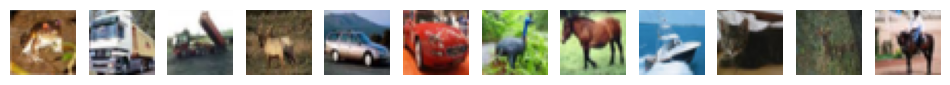

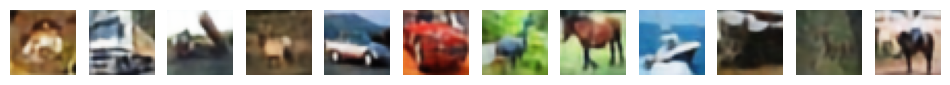

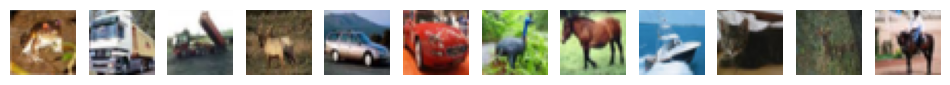

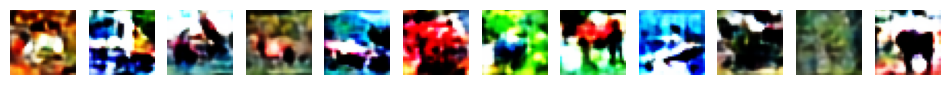

In [88]:
sample_autoencode(ae09)
sample_autoencode(ae09, encoder_override=c10_c['encoder'])

## With pretraining Autoencoder AE10

In [48]:
c11 = build_classifier('c11', ae10['encoder'])
c11['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c11/tensorboard
tensorboard --logdir=ch17/data/exrc10/c11/tensorboard
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.3770 - sparse_categorical_accuracy: 0.1445

16/16 [==============================] - 5s 200ms/step - loss: 2.3770 - sparse_categorical_accuracy: 0.1445 - val_loss: 2.1211 - val_sparse_categorical_accuracy: 0.2598
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 2.0781 - sparse_categorical_accuracy: 0.2578

16/16 [==============================] - 5s 303ms/step - loss: 2.0781 - sparse_categorical_accuracy: 0.2578 - val_loss: 2.0105 - val_sparse_categorical_accuracy: 0.2480
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.9578 - sparse_categorical_accuracy: 0.3105

16/16 [==============================] - 3s 193ms/step - loss: 1.9578 - sparse_categorical_accuracy: 0.3105 - val_loss: 1.8978 - val_sparse_categorical_accuracy: 0.3242
Epoch 4/50
16/16 [==============================] - 0s 28ms/step - loss: 1.9023 - sparse_categorical_accuracy: 0.2930 - val_loss: 1.9317 - val_sparse_categorical_accuracy: 0.2949
Epoch 5/50
15/16 [===========================>..] - ETA: 0s - loss: 1.8164 - sparse_categorical_accuracy: 0.3500

16/16 [==============================] - 3s 182ms/step - loss: 1.8220 - sparse_categorical_accuracy: 0.3496 - val_loss: 1.8161 - val_sparse_categorical_accuracy: 0.3516
Epoch 6/50
15/16 [===========================>..] - ETA: 0s - loss: 1.8121 - sparse_categorical_accuracy: 0.3438

16/16 [==============================] - 3s 191ms/step - loss: 1.8194 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.7339 - val_sparse_categorical_accuracy: 0.4004
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 1.6688 - sparse_categorical_accuracy: 0.4043

16/16 [==============================] - 4s 268ms/step - loss: 1.6688 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.7035 - val_sparse_categorical_accuracy: 0.3770
Epoch 8/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6270 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.7303 - val_sparse_categorical_accuracy: 0.3770
Epoch 9/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6616 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.7074 - val_sparse_categorical_accuracy: 0.3770
Epoch 10/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5578 - sparse_categorical_accuracy: 0.4014

16/16 [==============================] - 3s 183ms/step - loss: 1.5447 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.5920 - val_sparse_categorical_accuracy: 0.4316
Epoch 11/50
16/16 [==============================] - 0s 31ms/step - loss: 1.5487 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.5947 - val_sparse_categorical_accuracy: 0.4082
Epoch 12/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5238 - sparse_categorical_accuracy: 0.4604

16/16 [==============================] - 3s 195ms/step - loss: 1.5190 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.5778 - val_sparse_categorical_accuracy: 0.4160
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4515 - sparse_categorical_accuracy: 0.4928

16/16 [==============================] - 4s 250ms/step - loss: 1.4334 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5681 - val_sparse_categorical_accuracy: 0.4414
Epoch 14/50
15/16 [===========================>..] - ETA: 0s - loss: 1.5771 - sparse_categorical_accuracy: 0.4313

16/16 [==============================] - 3s 208ms/step - loss: 1.5596 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.5364 - val_sparse_categorical_accuracy: 0.4395
Epoch 15/50
16/16 [==============================] - 0s 26ms/step - loss: 1.5167 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.6918 - val_sparse_categorical_accuracy: 0.3945
Epoch 16/50
12/16 [=====================>........] - ETA: 0s - loss: 1.5002 - sparse_categorical_accuracy: 0.4792

16/16 [==============================] - 3s 194ms/step - loss: 1.4875 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.5161 - val_sparse_categorical_accuracy: 0.4395
Epoch 17/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4222 - sparse_categorical_accuracy: 0.4880

16/16 [==============================] - 4s 251ms/step - loss: 1.4524 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.4953 - val_sparse_categorical_accuracy: 0.4395
Epoch 18/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4387 - sparse_categorical_accuracy: 0.4760

16/16 [==============================] - 3s 203ms/step - loss: 1.4077 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.4730 - val_sparse_categorical_accuracy: 0.4922
Epoch 19/50
16/16 [==============================] - 1s 36ms/step - loss: 1.4232 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.5041 - val_sparse_categorical_accuracy: 0.4355
Epoch 20/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4018 - sparse_categorical_accuracy: 0.5240

16/16 [==============================] - 3s 181ms/step - loss: 1.4093 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.4652 - val_sparse_categorical_accuracy: 0.4902
Epoch 21/50
16/16 [==============================] - 1s 42ms/step - loss: 1.3280 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.4660 - val_sparse_categorical_accuracy: 0.4512
Epoch 22/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4162 - sparse_categorical_accuracy: 0.4976

16/16 [==============================] - 3s 176ms/step - loss: 1.3950 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.4290 - val_sparse_categorical_accuracy: 0.4883
Epoch 23/50
16/16 [==============================] - 0s 26ms/step - loss: 1.2972 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.4344 - val_sparse_categorical_accuracy: 0.4707
Epoch 24/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3544 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.4824 - val_sparse_categorical_accuracy: 0.4648
Epoch 25/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2835 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4332 - val_sparse_categorical_accuracy: 0.4785
Epoch 26/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.4794 - val_sparse_categorical_accuracy: 0.4727
Epoch 27/50
16/16 [==============================] - ETA: 0s - loss: 1.3010 - sparse_categorical_accuracy: 0.55

16/16 [==============================] - 4s 259ms/step - loss: 1.3010 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.4236 - val_sparse_categorical_accuracy: 0.4922
Epoch 28/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3182 - sparse_categorical_accuracy: 0.5433

16/16 [==============================] - 3s 191ms/step - loss: 1.3062 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.4175 - val_sparse_categorical_accuracy: 0.4980
Epoch 29/50
14/16 [=========================>....] - ETA: 0s - loss: 1.1876 - sparse_categorical_accuracy: 0.5804

16/16 [==============================] - 3s 190ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.3714 - val_sparse_categorical_accuracy: 0.4941
Epoch 30/50
16/16 [==============================] - 0s 26ms/step - loss: 1.1844 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.4264 - val_sparse_categorical_accuracy: 0.4766
Epoch 31/50
16/16 [==============================] - 0s 21ms/step - loss: 1.3098 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.4347 - val_sparse_categorical_accuracy: 0.4727
Epoch 32/50
16/16 [==============================] - 0s 21ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.4343 - val_sparse_categorical_accuracy: 0.5000
Epoch 33/50
16/16 [==============================] - ETA: 0s - loss: 1.1635 - sparse_categorical_accuracy: 0.5762

16/16 [==============================] - 4s 264ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.3505 - val_sparse_categorical_accuracy: 0.5156
Epoch 34/50
16/16 [==============================] - 0s 27ms/step - loss: 1.2262 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.3615 - val_sparse_categorical_accuracy: 0.5059
Epoch 35/50
16/16 [==============================] - 0s 23ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.4235 - val_sparse_categorical_accuracy: 0.4922
Epoch 36/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2043 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.4578 - val_sparse_categorical_accuracy: 0.4902
Epoch 37/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2174 - sparse_categorical_accuracy: 0.5603

16/16 [==============================] - 3s 189ms/step - loss: 1.2165 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.3405 - val_sparse_categorical_accuracy: 0.5137
Epoch 38/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1178 - sparse_categorical_accuracy: 0.6058

16/16 [==============================] - 3s 202ms/step - loss: 1.1202 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.3375 - val_sparse_categorical_accuracy: 0.5039
Epoch 39/50
16/16 [==============================] - 0s 30ms/step - loss: 1.1660 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.3664 - val_sparse_categorical_accuracy: 0.5039
Epoch 40/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1500 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.3668 - val_sparse_categorical_accuracy: 0.5098
Epoch 41/50
16/16 [==============================] - 0s 25ms/step - loss: 1.0881 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.3748 - val_sparse_categorical_accuracy: 0.5254
Epoch 42/50
16/16 [==============================] - 0s 22ms/step - loss: 1.0231 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.3851 - val_sparse_categorical_accuracy: 0.5195
Epoch 43/50
16/16 [==============================] - ETA: 0s - loss: 1.1308 - sparse_categorical_accuracy: 0.57

16/16 [==============================] - 3s 191ms/step - loss: 1.1308 - sparse_categorical_accuracy: 0.5742 - val_loss: 1.3229 - val_sparse_categorical_accuracy: 0.5430
Epoch 44/50
16/16 [==============================] - 0s 26ms/step - loss: 1.0517 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.3379 - val_sparse_categorical_accuracy: 0.5449
Epoch 45/50
16/16 [==============================] - 0s 24ms/step - loss: 1.1210 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.3296 - val_sparse_categorical_accuracy: 0.5430
Epoch 46/50
15/16 [===========================>..] - ETA: 0s - loss: 1.1133 - sparse_categorical_accuracy: 0.6083

16/16 [==============================] - 4s 274ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.3008 - val_sparse_categorical_accuracy: 0.5332
Epoch 47/50
16/16 [==============================] - 0s 27ms/step - loss: 0.9998 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.3340 - val_sparse_categorical_accuracy: 0.5293
Epoch 48/50
16/16 [==============================] - 0s 22ms/step - loss: 1.0057 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.3684 - val_sparse_categorical_accuracy: 0.5215
Epoch 49/50
16/16 [==============================] - 0s 25ms/step - loss: 1.0114 - sparse_categorical_accuracy: 0.6543 - val_loss: 1.3308 - val_sparse_categorical_accuracy: 0.5488
Epoch 50/50
15/16 [===========================>..] - ETA: 0s - loss: 1.0283 - sparse_categorical_accuracy: 0.6521

16/16 [==============================] - 3s 196ms/step - loss: 1.0190 - sparse_categorical_accuracy: 0.6543 - val_loss: 1.2923 - val_sparse_categorical_accuracy: 0.5605


### Results

In [49]:
c11['model'].evaluate(test_set)

  3/313 [..............................] - ETA: 9s - loss: 1.1468 - sparse_categorical_accuracy: 0.5625 

313/313 [==============================] - 2s 8ms/step - loss: 1.3142 - sparse_categorical_accuracy: 0.5310


[1.3141934871673584, 0.531000018119812]

## With pretraining Autoencoder AE11

In [50]:
c12 = build_classifier('c12', ae11['encoder'])
c12['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c12/tensorboard
tensorboard --logdir=ch17/data/exrc10/c12/tensorboard
Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 2.4745 - sparse_categorical_accuracy: 0.1417

16/16 [==============================] - 8s 341ms/step - loss: 2.4535 - sparse_categorical_accuracy: 0.1484 - val_loss: 2.1830 - val_sparse_categorical_accuracy: 0.1992
Epoch 2/50
14/16 [=========================>....] - ETA: 0s - loss: 2.0685 - sparse_categorical_accuracy: 0.2790

16/16 [==============================] - 4s 259ms/step - loss: 2.0606 - sparse_categorical_accuracy: 0.2793 - val_loss: 2.0491 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.9950 - sparse_categorical_accuracy: 0.2969

16/16 [==============================] - 5s 304ms/step - loss: 1.9950 - sparse_categorical_accuracy: 0.2969 - val_loss: 1.9752 - val_sparse_categorical_accuracy: 0.2676
Epoch 4/50
12/16 [=====================>........] - ETA: 0s - loss: 1.8662 - sparse_categorical_accuracy: 0.3542

16/16 [==============================] - 5s 356ms/step - loss: 1.8523 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.8939 - val_sparse_categorical_accuracy: 0.3516
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 1.7594 - sparse_categorical_accuracy: 0.3945

16/16 [==============================] - 4s 264ms/step - loss: 1.7594 - sparse_categorical_accuracy: 0.3945 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.3652
Epoch 6/50
15/16 [===========================>..] - ETA: 0s - loss: 1.7393 - sparse_categorical_accuracy: 0.4000

16/16 [==============================] - 5s 325ms/step - loss: 1.7194 - sparse_categorical_accuracy: 0.4121 - val_loss: 1.7933 - val_sparse_categorical_accuracy: 0.3789
Epoch 7/50
16/16 [==============================] - 1s 37ms/step - loss: 1.7256 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.8030 - val_sparse_categorical_accuracy: 0.3535
Epoch 8/50
12/16 [=====================>........] - ETA: 0s - loss: 1.5782 - sparse_categorical_accuracy: 0.4401

16/16 [==============================] - 4s 249ms/step - loss: 1.5799 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.7160 - val_sparse_categorical_accuracy: 0.4023
Epoch 9/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5566 - sparse_categorical_accuracy: 0.4531

16/16 [==============================] - 5s 341ms/step - loss: 1.5539 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.6813 - val_sparse_categorical_accuracy: 0.4082
Epoch 10/50
16/16 [==============================] - 0s 29ms/step - loss: 1.5788 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.7029 - val_sparse_categorical_accuracy: 0.4062
Epoch 11/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4959 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.7164 - val_sparse_categorical_accuracy: 0.4082
Epoch 12/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4786 - sparse_categorical_accuracy: 0.5000

16/16 [==============================] - 4s 251ms/step - loss: 1.4536 - sparse_categorical_accuracy: 0.5117 - val_loss: 1.6407 - val_sparse_categorical_accuracy: 0.4297
Epoch 13/50
16/16 [==============================] - 1s 40ms/step - loss: 1.3932 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.6925 - val_sparse_categorical_accuracy: 0.4219
Epoch 14/50
16/16 [==============================] - ETA: 0s - loss: 1.4709 - sparse_categorical_accuracy: 0.4863

16/16 [==============================] - 5s 317ms/step - loss: 1.4709 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.5943 - val_sparse_categorical_accuracy: 0.4199
Epoch 15/50
16/16 [==============================] - 1s 42ms/step - loss: 1.4199 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.6091 - val_sparse_categorical_accuracy: 0.4414
Epoch 16/50
16/16 [==============================] - 0s 27ms/step - loss: 1.3759 - sparse_categorical_accuracy: 0.5273 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.4355
Epoch 17/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5195 - sparse_categorical_accuracy: 0.4688

16/16 [==============================] - 4s 247ms/step - loss: 1.4943 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.5364 - val_sparse_categorical_accuracy: 0.4727
Epoch 18/50
16/16 [==============================] - 0s 30ms/step - loss: 1.4479 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.5555 - val_sparse_categorical_accuracy: 0.4512
Epoch 19/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3414 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.6412 - val_sparse_categorical_accuracy: 0.4297
Epoch 20/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3644 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.5462 - val_sparse_categorical_accuracy: 0.4590
Epoch 21/50
16/16 [==============================] - ETA: 0s - loss: 1.2272 - sparse_categorical_accuracy: 0.5703

16/16 [==============================] - 4s 240ms/step - loss: 1.2272 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.4936 - val_sparse_categorical_accuracy: 0.4824
Epoch 22/50
16/16 [==============================] - 1s 31ms/step - loss: 1.2867 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.5039 - val_sparse_categorical_accuracy: 0.4590
Epoch 23/50
16/16 [==============================] - 0s 19ms/step - loss: 1.2190 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.5022 - val_sparse_categorical_accuracy: 0.4590
Epoch 24/50
16/16 [==============================] - ETA: 0s - loss: 1.2313 - sparse_categorical_accuracy: 0.5586

16/16 [==============================] - 5s 328ms/step - loss: 1.2313 - sparse_categorical_accuracy: 0.5586 - val_loss: 1.4158 - val_sparse_categorical_accuracy: 0.5117
Epoch 25/50
16/16 [==============================] - 1s 35ms/step - loss: 1.2547 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.4871 - val_sparse_categorical_accuracy: 0.4648
Epoch 26/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1570 - sparse_categorical_accuracy: 0.5840 - val_loss: 1.4523 - val_sparse_categorical_accuracy: 0.4941
Epoch 27/50
16/16 [==============================] - 0s 21ms/step - loss: 1.2097 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.4470 - val_sparse_categorical_accuracy: 0.4980
Epoch 28/50
16/16 [==============================] - 0s 21ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.4823 - val_sparse_categorical_accuracy: 0.4883
Epoch 29/50
16/16 [==============================] - 0s 20ms/step - loss: 1.1619 - sparse_categorical_accuracy:

16/16 [==============================] - 4s 266ms/step - loss: 1.0562 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.3911 - val_sparse_categorical_accuracy: 0.5059
Epoch 39/50
16/16 [==============================] - 0s 30ms/step - loss: 1.1159 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.4941
Epoch 40/50
14/16 [=========================>....] - ETA: 0s - loss: 1.0558 - sparse_categorical_accuracy: 0.6027

16/16 [==============================] - 5s 318ms/step - loss: 1.0242 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.3843 - val_sparse_categorical_accuracy: 0.5059
Epoch 41/50
16/16 [==============================] - 0s 30ms/step - loss: 1.0061 - sparse_categorical_accuracy: 0.6660 - val_loss: 1.4099 - val_sparse_categorical_accuracy: 0.5254
Epoch 42/50
16/16 [==============================] - 0s 22ms/step - loss: 1.1093 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.4215 - val_sparse_categorical_accuracy: 0.5000
Epoch 43/50
16/16 [==============================] - 0s 20ms/step - loss: 0.9978 - sparse_categorical_accuracy: 0.6758 - val_loss: 1.4888 - val_sparse_categorical_accuracy: 0.5156
Epoch 44/50
16/16 [==============================] - 0s 21ms/step - loss: 1.0286 - sparse_categorical_accuracy: 0.6426 - val_loss: 1.3920 - val_sparse_categorical_accuracy: 0.5137
Epoch 45/50
16/16 [==============================] - 0s 20ms/step - loss: 0.9219 - sparse_categorical_accuracy:

### Results

In [52]:
c12['model'].evaluate(test_set)

  1/313 [..............................] - ETA: 7s - loss: 1.1688 - sparse_categorical_accuracy: 0.5312

313/313 [==============================] - 3s 8ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.5276


[1.3691655397415161, 0.5275999903678894]

## With pretraining Autoencoder AE12

In [69]:
c13 = build_classifier('c13', ae12['encoder'])
c13['load_or_fit'](force_fit=True, patience=50)

tensorboard --logdir=ch17/data/exrc10/c13/tensorboard
tensorboard --logdir=ch17/data/exrc10/c13/tensorboard
Epoch 1/50
13/16 [=======================>......] - ETA: 0s - loss: 2.4006 - sparse_categorical_accuracy: 0.0986

16/16 [==============================] - 8s 295ms/step - loss: 2.3718 - sparse_categorical_accuracy: 0.1172 - val_loss: 2.1925 - val_sparse_categorical_accuracy: 0.1797
Epoch 2/50
15/16 [===========================>..] - ETA: 0s - loss: 2.1876 - sparse_categorical_accuracy: 0.2250

16/16 [==============================] - 4s 288ms/step - loss: 2.1831 - sparse_categorical_accuracy: 0.2246 - val_loss: 2.0681 - val_sparse_categorical_accuracy: 0.2617
Epoch 3/50
13/16 [=======================>......] - ETA: 0s - loss: 2.0111 - sparse_categorical_accuracy: 0.3149

16/16 [==============================] - 5s 306ms/step - loss: 2.0333 - sparse_categorical_accuracy: 0.2910 - val_loss: 1.9908 - val_sparse_categorical_accuracy: 0.3105
Epoch 4/50
15/16 [===========================>..] - ETA: 0s - loss: 1.9514 - sparse_categorical_accuracy: 0.3396

16/16 [==============================] - 8s 538ms/step - loss: 1.9608 - sparse_categorical_accuracy: 0.3281 - val_loss: 1.9334 - val_sparse_categorical_accuracy: 0.3066
Epoch 5/50
13/16 [=======================>......] - ETA: 0s - loss: 1.9432 - sparse_categorical_accuracy: 0.2981

16/16 [==============================] - 4s 266ms/step - loss: 1.9338 - sparse_categorical_accuracy: 0.2988 - val_loss: 1.8937 - val_sparse_categorical_accuracy: 0.3066
Epoch 6/50
13/16 [=======================>......] - ETA: 0s - loss: 1.9094 - sparse_categorical_accuracy: 0.2933

16/16 [==============================] - 4s 254ms/step - loss: 1.9017 - sparse_categorical_accuracy: 0.3047 - val_loss: 1.8427 - val_sparse_categorical_accuracy: 0.3379
Epoch 7/50
12/16 [=====================>........] - ETA: 0s - loss: 1.8467 - sparse_categorical_accuracy: 0.3516

16/16 [==============================] - 4s 257ms/step - loss: 1.8116 - sparse_categorical_accuracy: 0.3691 - val_loss: 1.7882 - val_sparse_categorical_accuracy: 0.3496
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 1.7817 - sparse_categorical_accuracy: 0.4023

16/16 [==============================] - 4s 264ms/step - loss: 1.7817 - sparse_categorical_accuracy: 0.4023 - val_loss: 1.7729 - val_sparse_categorical_accuracy: 0.3535
Epoch 9/50
16/16 [==============================] - 1s 41ms/step - loss: 1.6843 - sparse_categorical_accuracy: 0.4082 - val_loss: 1.7811 - val_sparse_categorical_accuracy: 0.3457
Epoch 10/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6942 - sparse_categorical_accuracy: 0.4107

16/16 [==============================] - 4s 267ms/step - loss: 1.6955 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.6984 - val_sparse_categorical_accuracy: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 29ms/step - loss: 1.6205 - sparse_categorical_accuracy: 0.4082 - val_loss: 1.7272 - val_sparse_categorical_accuracy: 0.3750
Epoch 12/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5348 - sparse_categorical_accuracy: 0.4551 - val_loss: 1.7383 - val_sparse_categorical_accuracy: 0.3711
Epoch 13/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5694 - sparse_categorical_accuracy: 0.4279

16/16 [==============================] - 4s 252ms/step - loss: 1.5571 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.6348 - val_sparse_categorical_accuracy: 0.3945
Epoch 14/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5866 - sparse_categorical_accuracy: 0.4286

16/16 [==============================] - 4s 289ms/step - loss: 1.5823 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.6075 - val_sparse_categorical_accuracy: 0.3984
Epoch 15/50
13/16 [=======================>......] - ETA: 0s - loss: 1.5844 - sparse_categorical_accuracy: 0.4327

16/16 [==============================] - 4s 275ms/step - loss: 1.5889 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.5616 - val_sparse_categorical_accuracy: 0.4434
Epoch 16/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6154 - sparse_categorical_accuracy: 0.4183

16/16 [==============================] - 4s 269ms/step - loss: 1.5886 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.5472 - val_sparse_categorical_accuracy: 0.4434
Epoch 17/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4326 - sparse_categorical_accuracy: 0.4833

16/16 [==============================] - 4s 254ms/step - loss: 1.4317 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.5391 - val_sparse_categorical_accuracy: 0.4297
Epoch 18/50
16/16 [==============================] - 1s 65ms/step - loss: 1.4383 - sparse_categorical_accuracy: 0.4707 - val_loss: 1.5908 - val_sparse_categorical_accuracy: 0.4160
Epoch 19/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4210 - sparse_categorical_accuracy: 0.4732

16/16 [==============================] - 9s 579ms/step - loss: 1.4134 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.5265 - val_sparse_categorical_accuracy: 0.4355
Epoch 20/50
15/16 [===========================>..] - ETA: 0s - loss: 1.4114 - sparse_categorical_accuracy: 0.4833

16/16 [==============================] - 5s 301ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.4881 - val_sparse_categorical_accuracy: 0.4609
Epoch 21/50
16/16 [==============================] - 1s 45ms/step - loss: 1.4105 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.5341 - val_sparse_categorical_accuracy: 0.4414
Epoch 22/50
16/16 [==============================] - 0s 21ms/step - loss: 1.3705 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.5519 - val_sparse_categorical_accuracy: 0.4277
Epoch 23/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3563 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.5511 - val_sparse_categorical_accuracy: 0.4121
Epoch 24/50
15/16 [===========================>..] - ETA: 0s - loss: 1.3544 - sparse_categorical_accuracy: 0.5104

16/16 [==============================] - 4s 254ms/step - loss: 1.3516 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.4797 - val_sparse_categorical_accuracy: 0.4512
Epoch 25/50
16/16 [==============================] - ETA: 0s - loss: 1.3281 - sparse_categorical_accuracy: 0.5391

16/16 [==============================] - 4s 263ms/step - loss: 1.3281 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.4582 - val_sparse_categorical_accuracy: 0.4648
Epoch 26/50
14/16 [=========================>....] - ETA: 0s - loss: 1.3620 - sparse_categorical_accuracy: 0.5000

16/16 [==============================] - 4s 276ms/step - loss: 1.3371 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.4379 - val_sparse_categorical_accuracy: 0.4688
Epoch 27/50
16/16 [==============================] - 1s 32ms/step - loss: 1.3941 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.4540 - val_sparse_categorical_accuracy: 0.4883
Epoch 28/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3089 - sparse_categorical_accuracy: 0.5433

16/16 [==============================] - 4s 259ms/step - loss: 1.2914 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.4377 - val_sparse_categorical_accuracy: 0.4766
Epoch 29/50
13/16 [=======================>......] - ETA: 0s - loss: 1.3542 - sparse_categorical_accuracy: 0.4952

16/16 [==============================] - 4s 251ms/step - loss: 1.3589 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.3976 - val_sparse_categorical_accuracy: 0.4961
Epoch 30/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2172 - sparse_categorical_accuracy: 0.5553

16/16 [==============================] - 4s 263ms/step - loss: 1.2204 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.3795 - val_sparse_categorical_accuracy: 0.4941
Epoch 31/50
16/16 [==============================] - 1s 32ms/step - loss: 1.3361 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.4552 - val_sparse_categorical_accuracy: 0.4805
Epoch 32/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2433 - sparse_categorical_accuracy: 0.5513

16/16 [==============================] - 4s 251ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.3698 - val_sparse_categorical_accuracy: 0.5117
Epoch 33/50
16/16 [==============================] - 1s 40ms/step - loss: 1.2901 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.3972 - val_sparse_categorical_accuracy: 0.4824
Epoch 34/50
15/16 [===========================>..] - ETA: 0s - loss: 1.1989 - sparse_categorical_accuracy: 0.5750

16/16 [==============================] - 4s 246ms/step - loss: 1.1837 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.3268 - val_sparse_categorical_accuracy: 0.5273
Epoch 35/50
16/16 [==============================] - 1s 41ms/step - loss: 1.2788 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.3702 - val_sparse_categorical_accuracy: 0.5039
Epoch 36/50
16/16 [==============================] - 0s 28ms/step - loss: 1.1857 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.4696 - val_sparse_categorical_accuracy: 0.4375
Epoch 37/50
16/16 [==============================] - 0s 26ms/step - loss: 1.2621 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.3498 - val_sparse_categorical_accuracy: 0.5020
Epoch 38/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1904 - sparse_categorical_accuracy: 0.6113 - val_loss: 1.3427 - val_sparse_categorical_accuracy: 0.5156
Epoch 39/50
14/16 [=========================>....] - ETA: 0s - loss: 1.2969 - sparse_categorical_accuracy: 0.54

16/16 [==============================] - 4s 251ms/step - loss: 1.2794 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.3189 - val_sparse_categorical_accuracy: 0.5332
Epoch 40/50
16/16 [==============================] - 0s 30ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.3557 - val_sparse_categorical_accuracy: 0.5156
Epoch 41/50
16/16 [==============================] - 0s 26ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.3540 - val_sparse_categorical_accuracy: 0.5039
Epoch 42/50
14/16 [=========================>....] - ETA: 0s - loss: 1.1297 - sparse_categorical_accuracy: 0.5804

16/16 [==============================] - 4s 255ms/step - loss: 1.1327 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.3147 - val_sparse_categorical_accuracy: 0.5371
Epoch 43/50
16/16 [==============================] - 0s 30ms/step - loss: 1.1559 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.3436 - val_sparse_categorical_accuracy: 0.5078
Epoch 44/50
16/16 [==============================] - 0s 25ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.3173 - val_sparse_categorical_accuracy: 0.5430
Epoch 45/50
13/16 [=======================>......] - ETA: 0s - loss: 1.1918 - sparse_categorical_accuracy: 0.5841

16/16 [==============================] - 4s 276ms/step - loss: 1.2026 - sparse_categorical_accuracy: 0.5801 - val_loss: 1.3004 - val_sparse_categorical_accuracy: 0.5410
Epoch 46/50
16/16 [==============================] - ETA: 0s - loss: 1.1908 - sparse_categorical_accuracy: 0.5918

16/16 [==============================] - 10s 669ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.5918 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.5488
Epoch 47/50
16/16 [==============================] - 1s 39ms/step - loss: 1.0734 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.3095 - val_sparse_categorical_accuracy: 0.5312
Epoch 48/50
16/16 [==============================] - 0s 24ms/step - loss: 1.0865 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.3294 - val_sparse_categorical_accuracy: 0.5449
Epoch 49/50
16/16 [==============================] - 0s 21ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.2863 - val_sparse_categorical_accuracy: 0.5371
Epoch 50/50
16/16 [==============================] - 0s 25ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.3467 - val_sparse_categorical_accuracy: 0.5098


### Results

In [70]:
c13['model'].evaluate(test_set)

 16/313 [>.............................] - ETA: 2s - loss: 1.3690 - sparse_categorical_accuracy: 0.5078

313/313 [==============================] - 3s 9ms/step - loss: 1.3563 - sparse_categorical_accuracy: 0.5107


[1.3563026189804077, 0.510699987411499]

### Trainable-Not-trainable encoder

In [79]:
c13_b = build_stacked_classifier('c13_b', ae12['encoder'])
c13_b['fit']()

tensorboard --logdir=ch17/data/exrc10/c13_b/tensorboard
Epoch 1/30
13/16 [=======================>......] - ETA: 0s - loss: 2.2619 - sparse_categorical_accuracy: 0.1707

16/16 [==============================] - 10s 455ms/step - loss: 2.2400 - sparse_categorical_accuracy: 0.1895 - val_loss: 2.1630 - val_sparse_categorical_accuracy: 0.2188
Epoch 2/30
12/16 [=====================>........] - ETA: 0s - loss: 2.0947 - sparse_categorical_accuracy: 0.2786

16/16 [==============================] - 50s 3s/step - loss: 2.0801 - sparse_categorical_accuracy: 0.2695 - val_loss: 2.0170 - val_sparse_categorical_accuracy: 0.3008
Epoch 3/30
15/16 [===========================>..] - ETA: 0s - loss: 1.9613 - sparse_categorical_accuracy: 0.2896

16/16 [==============================] - 4s 268ms/step - loss: 1.9490 - sparse_categorical_accuracy: 0.2930 - val_loss: 1.9127 - val_sparse_categorical_accuracy: 0.3438
Epoch 4/30
12/16 [=====================>........] - ETA: 0s - loss: 1.8902 - sparse_categorical_accuracy: 0.3411

16/16 [==============================] - 4s 257ms/step - loss: 1.8663 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.8820 - val_sparse_categorical_accuracy: 0.3379
Epoch 5/30
14/16 [=========================>....] - ETA: 0s - loss: 1.7774 - sparse_categorical_accuracy: 0.3795

16/16 [==============================] - 4s 262ms/step - loss: 1.7553 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.7915 - val_sparse_categorical_accuracy: 0.3574
Epoch 6/30
12/16 [=====================>........] - ETA: 0s - loss: 1.7440 - sparse_categorical_accuracy: 0.3828

16/16 [==============================] - 4s 235ms/step - loss: 1.7313 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.7445 - val_sparse_categorical_accuracy: 0.3652
Epoch 7/30
16/16 [==============================] - 0s 25ms/step - loss: 1.7083 - sparse_categorical_accuracy: 0.3945 - val_loss: 1.7496 - val_sparse_categorical_accuracy: 0.3770
Epoch 8/30
13/16 [=======================>......] - ETA: 0s - loss: 1.6377 - sparse_categorical_accuracy: 0.4183

16/16 [==============================] - 3s 218ms/step - loss: 1.6303 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.7144 - val_sparse_categorical_accuracy: 0.3789
Epoch 9/30
15/16 [===========================>..] - ETA: 0s - loss: 1.6288 - sparse_categorical_accuracy: 0.4500

16/16 [==============================] - 4s 233ms/step - loss: 1.6320 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.6714 - val_sparse_categorical_accuracy: 0.3887
Epoch 10/30
15/16 [===========================>..] - ETA: 0s - loss: 1.5430 - sparse_categorical_accuracy: 0.4771

16/16 [==============================] - 3s 219ms/step - loss: 1.5454 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.6522 - val_sparse_categorical_accuracy: 0.4043
Epoch 11/30
16/16 [==============================] - 1s 34ms/step - loss: 1.5314 - sparse_categorical_accuracy: 0.4824 - val_loss: 1.6547 - val_sparse_categorical_accuracy: 0.4102
Epoch 12/30
16/16 [==============================] - 0s 19ms/step - loss: 1.5474 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.6752 - val_sparse_categorical_accuracy: 0.4023
Epoch 13/30
11/16 [===================>..........] - ETA: 0s - loss: 1.5088 - sparse_categorical_accuracy: 0.4830

16/16 [==============================] - 4s 227ms/step - loss: 1.5258 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.6312 - val_sparse_categorical_accuracy: 0.4219
Epoch 14/30
16/16 [==============================] - 0s 25ms/step - loss: 1.4942 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.6734 - val_sparse_categorical_accuracy: 0.4062
Epoch 15/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4674 - sparse_categorical_accuracy: 0.4784

16/16 [==============================] - 4s 237ms/step - loss: 1.4523 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.6230 - val_sparse_categorical_accuracy: 0.4004
Epoch 16/30
16/16 [==============================] - 1s 38ms/step - loss: 1.5257 - sparse_categorical_accuracy: 0.4434 - val_loss: 1.6477 - val_sparse_categorical_accuracy: 0.4141
Epoch 17/30
14/16 [=========================>....] - ETA: 0s - loss: 1.4626 - sparse_categorical_accuracy: 0.4732

16/16 [==============================] - 3s 223ms/step - loss: 1.4379 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.5908 - val_sparse_categorical_accuracy: 0.4258
Epoch 18/30
16/16 [==============================] - 1s 30ms/step - loss: 1.3700 - sparse_categorical_accuracy: 0.5332 - val_loss: 1.6153 - val_sparse_categorical_accuracy: 0.4219
Epoch 19/30
11/16 [===================>..........] - ETA: 0s - loss: 1.4194 - sparse_categorical_accuracy: 0.5227

16/16 [==============================] - 3s 208ms/step - loss: 1.4167 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.5679 - val_sparse_categorical_accuracy: 0.4395
Epoch 20/30
16/16 [==============================] - ETA: 0s - loss: 1.3489 - sparse_categorical_accuracy: 0.5371

16/16 [==============================] - 4s 233ms/step - loss: 1.3489 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.5596 - val_sparse_categorical_accuracy: 0.4434
Epoch 21/30
16/16 [==============================] - 0s 26ms/step - loss: 1.4354 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.5718 - val_sparse_categorical_accuracy: 0.4355
Epoch 22/30
16/16 [==============================] - 0s 17ms/step - loss: 1.4376 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.5710 - val_sparse_categorical_accuracy: 0.4336
Epoch 23/30
16/16 [==============================] - 0s 18ms/step - loss: 1.3861 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.5646 - val_sparse_categorical_accuracy: 0.4297
Epoch 24/30
12/16 [=====================>........] - ETA: 0s - loss: 1.3408 - sparse_categorical_accuracy: 0.5521

16/16 [==============================] - 3s 210ms/step - loss: 1.3609 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.5510 - val_sparse_categorical_accuracy: 0.4531
Epoch 25/30
16/16 [==============================] - 1s 36ms/step - loss: 1.3356 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.5638 - val_sparse_categorical_accuracy: 0.4414
Epoch 26/30
16/16 [==============================] - 0s 26ms/step - loss: 1.3374 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.5719 - val_sparse_categorical_accuracy: 0.4180
Epoch 27/30
16/16 [==============================] - 0s 17ms/step - loss: 1.3102 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.5806 - val_sparse_categorical_accuracy: 0.4199
Epoch 28/30
16/16 [==============================] - 0s 17ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.5549 - val_sparse_categorical_accuracy: 0.4531
Epoch 29/30
13/16 [=======================>......] - ETA: 0s - loss: 1.2637 - sparse_categorical_accuracy: 0.56

16/16 [==============================] - 3s 212ms/step - loss: 1.2650 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.5438 - val_sparse_categorical_accuracy: 0.4414
Epoch 30/30
16/16 [==============================] - ETA: 0s - loss: 1.2303 - sparse_categorical_accuracy: 0.5703

16/16 [==============================] - 4s 226ms/step - loss: 1.2303 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.5424 - val_sparse_categorical_accuracy: 0.4609
Epoch 1/30
16/16 [==============================] - 11s 78ms/step - loss: 1.6000 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.6407 - val_sparse_categorical_accuracy: 0.4238
Epoch 2/30
16/16 [==============================] - 1s 39ms/step - loss: 1.3774 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.6680 - val_sparse_categorical_accuracy: 0.4141
Epoch 3/30
16/16 [==============================] - 1s 38ms/step - loss: 1.3913 - sparse_categorical_accuracy: 0.5352 - val_loss: 1.6032 - val_sparse_categorical_accuracy: 0.4258
Epoch 4/30
16/16 [==============================] - 1s 40ms/step - loss: 1.4081 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.5659 - val_sparse_categorical_accuracy: 0.4551
Epoch 5/30
15/16 [===========================>..] - ETA: 0s - loss: 1.3452 - sparse_categorical_accuracy: 0.5521

16/16 [==============================] - 4s 274ms/step - loss: 1.3316 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.5300 - val_sparse_categorical_accuracy: 0.4473
Epoch 6/30
16/16 [==============================] - 1s 51ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.5654 - val_sparse_categorical_accuracy: 0.4551
Epoch 7/30
16/16 [==============================] - 1s 39ms/step - loss: 1.3140 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.5484 - val_sparse_categorical_accuracy: 0.4570
Epoch 8/30
16/16 [==============================] - 1s 42ms/step - loss: 1.3305 - sparse_categorical_accuracy: 0.5527 - val_loss: 1.5412 - val_sparse_categorical_accuracy: 0.4473
Epoch 9/30
16/16 [==============================] - 1s 36ms/step - loss: 1.3176 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.5311 - val_sparse_categorical_accuracy: 0.4551
Epoch 10/30
16/16 [==============================] - 1s 37ms/step - loss: 1.3823 - sparse_categorical_accuracy: 0.5

16/16 [==============================] - 4s 267ms/step - loss: 1.1918 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.5002 - val_sparse_categorical_accuracy: 0.4668
Epoch 12/30
16/16 [==============================] - 1s 53ms/step - loss: 1.1700 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.5184 - val_sparse_categorical_accuracy: 0.4746
Epoch 13/30
16/16 [==============================] - 1s 41ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.5041 - val_sparse_categorical_accuracy: 0.4902
Epoch 14/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2472 - sparse_categorical_accuracy: 0.5729

16/16 [==============================] - 4s 274ms/step - loss: 1.2267 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.4636 - val_sparse_categorical_accuracy: 0.4844
Epoch 15/30
15/16 [===========================>..] - ETA: 0s - loss: 1.2192 - sparse_categorical_accuracy: 0.5542

16/16 [==============================] - 4s 286ms/step - loss: 1.2195 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.4352 - val_sparse_categorical_accuracy: 0.4883
Epoch 16/30
16/16 [==============================] - 1s 53ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.4665 - val_sparse_categorical_accuracy: 0.5117
Epoch 17/30
16/16 [==============================] - 1s 39ms/step - loss: 1.2076 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.4622 - val_sparse_categorical_accuracy: 0.4824
Epoch 18/30
16/16 [==============================] - 1s 41ms/step - loss: 1.1115 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.4967 - val_sparse_categorical_accuracy: 0.4863
Epoch 19/30
16/16 [==============================] - 1s 44ms/step - loss: 1.1349 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.5371 - val_sparse_categorical_accuracy: 0.4824
Epoch 20/30
16/16 [==============================] - 1s 40ms/step - loss: 1.2231 - sparse_categorical_accuracy:

16/16 [==============================] - 67s 4s/step - loss: 1.1711 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.4056 - val_sparse_categorical_accuracy: 0.4883
Epoch 23/30
16/16 [==============================] - 1s 54ms/step - loss: 1.0591 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.4880 - val_sparse_categorical_accuracy: 0.4805
Epoch 24/30
16/16 [==============================] - 1s 42ms/step - loss: 1.0338 - sparse_categorical_accuracy: 0.6211 - val_loss: 1.5103 - val_sparse_categorical_accuracy: 0.5176
Epoch 25/30
16/16 [==============================] - 1s 50ms/step - loss: 1.1633 - sparse_categorical_accuracy: 0.5996 - val_loss: 1.4632 - val_sparse_categorical_accuracy: 0.5000
Epoch 26/30
16/16 [==============================] - 1s 47ms/step - loss: 1.1820 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.5966 - val_sparse_categorical_accuracy: 0.4375
Epoch 27/30
16/16 [==============================] - 1s 40ms/step - loss: 1.0774 - sparse_categorical_accuracy: 0

16/16 [==============================] - 9s 629ms/step - loss: 1.0239 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.3788 - val_sparse_categorical_accuracy: 0.5137
Epoch 29/30
16/16 [==============================] - 1s 62ms/step - loss: 0.9471 - sparse_categorical_accuracy: 0.6621 - val_loss: 1.4717 - val_sparse_categorical_accuracy: 0.4961
Epoch 30/30
16/16 [==============================] - 1s 42ms/step - loss: 0.9879 - sparse_categorical_accuracy: 0.6406 - val_loss: 1.5130 - val_sparse_categorical_accuracy: 0.5020


In [80]:
c13_b['model'].evaluate(test_set)

  6/313 [..............................] - ETA: 3s - loss: 1.4169 - sparse_categorical_accuracy: 0.5208

313/313 [==============================] - 3s 9ms/step - loss: 1.5706 - sparse_categorical_accuracy: 0.4820


[1.570640206336975, 0.4819999933242798]

## With pretraining Autoencoder AE13

In [98]:
c14 = build_classifier('c14', ae13['encoder'])
c14['load_or_fit'](patience=50, force_fit=True)

tensorboard --logdir=ch17/data/exrc10/c14/tensorboard
tensorboard --logdir=ch17/data/exrc10/c14/tensorboard
Epoch 1/50
12/16 [=====================>........] - ETA: 0s - loss: 2.5007 - sparse_categorical_accuracy: 0.1458

16/16 [==============================] - 12s 451ms/step - loss: 2.4334 - sparse_categorical_accuracy: 0.1484 - val_loss: 2.1591 - val_sparse_categorical_accuracy: 0.1914
Epoch 2/50
15/16 [===========================>..] - ETA: 0s - loss: 2.0469 - sparse_categorical_accuracy: 0.2521

16/16 [==============================] - 7s 431ms/step - loss: 2.0451 - sparse_categorical_accuracy: 0.2520 - val_loss: 1.9322 - val_sparse_categorical_accuracy: 0.2832
Epoch 3/50
16/16 [==============================] - 1s 33ms/step - loss: 1.9452 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.9635 - val_sparse_categorical_accuracy: 0.3105
Epoch 4/50
13/16 [=======================>......] - ETA: 0s - loss: 1.8213 - sparse_categorical_accuracy: 0.3389

16/16 [==============================] - 6s 402ms/step - loss: 1.8365 - sparse_categorical_accuracy: 0.3379 - val_loss: 1.8628 - val_sparse_categorical_accuracy: 0.3145
Epoch 5/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7303 - sparse_categorical_accuracy: 0.3846

16/16 [==============================] - 7s 469ms/step - loss: 1.7452 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.8290 - val_sparse_categorical_accuracy: 0.3379
Epoch 6/50
16/16 [==============================] - 1s 38ms/step - loss: 1.7545 - sparse_categorical_accuracy: 0.3730 - val_loss: 1.8642 - val_sparse_categorical_accuracy: 0.3340
Epoch 7/50
13/16 [=======================>......] - ETA: 0s - loss: 1.7008 - sparse_categorical_accuracy: 0.4062

16/16 [==============================] - 6s 424ms/step - loss: 1.7330 - sparse_categorical_accuracy: 0.3848 - val_loss: 1.7867 - val_sparse_categorical_accuracy: 0.3633
Epoch 8/50
13/16 [=======================>......] - ETA: 0s - loss: 1.6785 - sparse_categorical_accuracy: 0.3798

16/16 [==============================] - 6s 409ms/step - loss: 1.6628 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.7625 - val_sparse_categorical_accuracy: 0.3750
Epoch 9/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6251 - sparse_categorical_accuracy: 0.4241

16/16 [==============================] - 6s 407ms/step - loss: 1.6295 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.7062 - val_sparse_categorical_accuracy: 0.3770
Epoch 10/50
14/16 [=========================>....] - ETA: 0s - loss: 1.6049 - sparse_categorical_accuracy: 0.4397

16/16 [==============================] - 98s 7s/step - loss: 1.6130 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.6849 - val_sparse_categorical_accuracy: 0.3926
Epoch 11/50
16/16 [==============================] - 1s 28ms/step - loss: 1.5947 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.7899 - val_sparse_categorical_accuracy: 0.3711
Epoch 12/50
16/16 [==============================] - 1s 33ms/step - loss: 1.5412 - sparse_categorical_accuracy: 0.4395 - val_loss: 1.7292 - val_sparse_categorical_accuracy: 0.3906
Epoch 13/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5565 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.8085 - val_sparse_categorical_accuracy: 0.3750
Epoch 14/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5893 - sparse_categorical_accuracy: 0.4442

16/16 [==============================] - 8s 505ms/step - loss: 1.5829 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.6697 - val_sparse_categorical_accuracy: 0.3965
Epoch 15/50
14/16 [=========================>....] - ETA: 0s - loss: 1.5751 - sparse_categorical_accuracy: 0.4040

16/16 [==============================] - 8s 500ms/step - loss: 1.5625 - sparse_categorical_accuracy: 0.4160 - val_loss: 1.6149 - val_sparse_categorical_accuracy: 0.4473
Epoch 16/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5198 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.6160 - val_sparse_categorical_accuracy: 0.4336
Epoch 17/50
14/16 [=========================>....] - ETA: 0s - loss: 1.4566 - sparse_categorical_accuracy: 0.4844

16/16 [==============================] - 7s 468ms/step - loss: 1.4576 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5966 - val_sparse_categorical_accuracy: 0.4473
Epoch 18/50
16/16 [==============================] - 1s 39ms/step - loss: 1.3948 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.6938 - val_sparse_categorical_accuracy: 0.4102
Epoch 19/50
16/16 [==============================] - ETA: 0s - loss: 1.4631 - sparse_categorical_accuracy: 0.4805

16/16 [==============================] - 7s 470ms/step - loss: 1.4631 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.5900 - val_sparse_categorical_accuracy: 0.4336
Epoch 20/50
16/16 [==============================] - 1s 38ms/step - loss: 1.4324 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.6585 - val_sparse_categorical_accuracy: 0.3887
Epoch 21/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4075 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.6967 - val_sparse_categorical_accuracy: 0.4082
Epoch 22/50
16/16 [==============================] - 0s 21ms/step - loss: 1.4574 - sparse_categorical_accuracy: 0.5137 - val_loss: 1.6077 - val_sparse_categorical_accuracy: 0.4277
Epoch 23/50
13/16 [=======================>......] - ETA: 0s - loss: 1.4848 - sparse_categorical_accuracy: 0.4447

16/16 [==============================] - 7s 480ms/step - loss: 1.4620 - sparse_categorical_accuracy: 0.4668 - val_loss: 1.5717 - val_sparse_categorical_accuracy: 0.4648
Epoch 24/50
16/16 [==============================] - 1s 34ms/step - loss: 1.4025 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.6425 - val_sparse_categorical_accuracy: 0.4316
Epoch 25/50
16/16 [==============================] - 0s 20ms/step - loss: 1.3938 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.6486 - val_sparse_categorical_accuracy: 0.4453
Epoch 26/50
16/16 [==============================] - 0s 23ms/step - loss: 1.4417 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.5936 - val_sparse_categorical_accuracy: 0.4746
Epoch 27/50
16/16 [==============================] - 0s 21ms/step - loss: 1.3659 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.6378 - val_sparse_categorical_accuracy: 0.4414
Epoch 28/50
16/16 [==============================] - 0s 22ms/step - loss: 1.3157 - sparse_categorical_accuracy:

16/16 [==============================] - 7s 460ms/step - loss: 1.3775 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.5158 - val_sparse_categorical_accuracy: 0.4668
Epoch 32/50
13/16 [=======================>......] - ETA: 0s - loss: 1.2600 - sparse_categorical_accuracy: 0.5433

16/16 [==============================] - 7s 487ms/step - loss: 1.2770 - sparse_categorical_accuracy: 0.5293 - val_loss: 1.4958 - val_sparse_categorical_accuracy: 0.4785
Epoch 33/50
16/16 [==============================] - 1s 38ms/step - loss: 1.2869 - sparse_categorical_accuracy: 0.5215 - val_loss: 1.5679 - val_sparse_categorical_accuracy: 0.4473
Epoch 34/50
16/16 [==============================] - 1s 29ms/step - loss: 1.2504 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.6732 - val_sparse_categorical_accuracy: 0.4297
Epoch 35/50
16/16 [==============================] - 0s 24ms/step - loss: 1.3684 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.6728 - val_sparse_categorical_accuracy: 0.4141
Epoch 36/50
16/16 [==============================] - 0s 20ms/step - loss: 1.2382 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.6115 - val_sparse_categorical_accuracy: 0.4668
Epoch 37/50
16/16 [==============================] - 0s 21ms/step - loss: 1.2153 - sparse_categorical_accuracy:

16/16 [==============================] - 7s 454ms/step - loss: 1.1953 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.4738 - val_sparse_categorical_accuracy: 0.5098


### Results

In [99]:
c14['model'].evaluate(test_set)

  3/313 [..............................] - ETA: 9s - loss: 1.2598 - sparse_categorical_accuracy: 0.5625 

313/313 [==============================] - 3s 10ms/step - loss: 1.4553 - sparse_categorical_accuracy: 0.4911


[1.4553149938583374, 0.491100013256073]

### Stacked 1

In [100]:
c14_b = build_stacked_classifier('c14_b', ae13['encoder'])
c14_b['fit']()

tensorboard --logdir=ch17/data/exrc10/c14_b/tensorboard
Epoch 1/30
13/16 [=======================>......] - ETA: 0s - loss: 2.3670 - sparse_categorical_accuracy: 0.1490

16/16 [==============================] - 11s 438ms/step - loss: 2.3409 - sparse_categorical_accuracy: 0.1523 - val_loss: 2.0851 - val_sparse_categorical_accuracy: 0.2441
Epoch 2/30
13/16 [=======================>......] - ETA: 0s - loss: 2.0824 - sparse_categorical_accuracy: 0.2524

16/16 [==============================] - 6s 430ms/step - loss: 2.0432 - sparse_categorical_accuracy: 0.2578 - val_loss: 1.9443 - val_sparse_categorical_accuracy: 0.3320
Epoch 3/30
13/16 [=======================>......] - ETA: 0s - loss: 1.8535 - sparse_categorical_accuracy: 0.3197

16/16 [==============================] - 6s 424ms/step - loss: 1.8644 - sparse_categorical_accuracy: 0.3145 - val_loss: 1.8469 - val_sparse_categorical_accuracy: 0.3555
Epoch 4/30
16/16 [==============================] - 1s 35ms/step - loss: 1.8352 - sparse_categorical_accuracy: 0.3633 - val_loss: 1.8619 - val_sparse_categorical_accuracy: 0.3496
Epoch 5/30
16/16 [==============================] - 0s 15ms/step - loss: 1.6983 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.8560 - val_sparse_categorical_accuracy: 0.3633
Epoch 6/30
14/16 [=========================>....] - ETA: 0s - loss: 1.6065 - sparse_categorical_accuracy: 0.4754

16/16 [==============================] - 5s 356ms/step - loss: 1.5881 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.8173 - val_sparse_categorical_accuracy: 0.4062
Epoch 7/30
14/16 [=========================>....] - ETA: 0s - loss: 1.6318 - sparse_categorical_accuracy: 0.3996

16/16 [==============================] - 6s 385ms/step - loss: 1.6467 - sparse_categorical_accuracy: 0.4004 - val_loss: 1.7677 - val_sparse_categorical_accuracy: 0.3965
Epoch 8/30
16/16 [==============================] - 1s 30ms/step - loss: 1.5795 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.7853 - val_sparse_categorical_accuracy: 0.4043
Epoch 9/30
12/16 [=====================>........] - ETA: 0s - loss: 1.6455 - sparse_categorical_accuracy: 0.4557

16/16 [==============================] - 5s 348ms/step - loss: 1.6199 - sparse_categorical_accuracy: 0.4492 - val_loss: 1.7280 - val_sparse_categorical_accuracy: 0.3984
Epoch 10/30
15/16 [===========================>..] - ETA: 0s - loss: 1.4951 - sparse_categorical_accuracy: 0.4604

16/16 [==============================] - 6s 379ms/step - loss: 1.4971 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.7032 - val_sparse_categorical_accuracy: 0.4277
Epoch 11/30
16/16 [==============================] - 0s 27ms/step - loss: 1.4768 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.7448 - val_sparse_categorical_accuracy: 0.4004
Epoch 12/30
16/16 [==============================] - 0s 16ms/step - loss: 1.5211 - sparse_categorical_accuracy: 0.4727 - val_loss: 1.7967 - val_sparse_categorical_accuracy: 0.4082
Epoch 13/30
16/16 [==============================] - 0s 17ms/step - loss: 1.4964 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.7532 - val_sparse_categorical_accuracy: 0.3984
Epoch 14/30
16/16 [==============================] - 0s 17ms/step - loss: 1.4558 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.7750 - val_sparse_categorical_accuracy: 0.3945
Epoch 15/30
16/16 [==============================] - 0s 16ms/step - loss: 1.5037 - sparse_categorical_accuracy:

16/16 [==============================] - 5s 347ms/step - loss: 1.4030 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.6600 - val_sparse_categorical_accuracy: 0.4395
Epoch 17/30
16/16 [==============================] - 0s 25ms/step - loss: 1.4157 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.7350 - val_sparse_categorical_accuracy: 0.4336
Epoch 18/30
11/16 [===================>..........] - ETA: 0s - loss: 1.4977 - sparse_categorical_accuracy: 0.4744

16/16 [==============================] - 5s 342ms/step - loss: 1.4693 - sparse_categorical_accuracy: 0.4863 - val_loss: 1.6487 - val_sparse_categorical_accuracy: 0.4375
Epoch 19/30
15/16 [===========================>..] - ETA: 0s - loss: 1.4380 - sparse_categorical_accuracy: 0.4896

16/16 [==============================] - 6s 369ms/step - loss: 1.4319 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.6231 - val_sparse_categorical_accuracy: 0.4492
Epoch 20/30
16/16 [==============================] - 0s 25ms/step - loss: 1.3478 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.6771 - val_sparse_categorical_accuracy: 0.4512
Epoch 21/30
16/16 [==============================] - 0s 17ms/step - loss: 1.3541 - sparse_categorical_accuracy: 0.4785 - val_loss: 1.7085 - val_sparse_categorical_accuracy: 0.4141
Epoch 22/30
16/16 [==============================] - 0s 16ms/step - loss: 1.4115 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.6439 - val_sparse_categorical_accuracy: 0.4434
Epoch 23/30
16/16 [==============================] - 0s 16ms/step - loss: 1.2811 - sparse_categorical_accuracy: 0.5371 - val_loss: 1.7809 - val_sparse_categorical_accuracy: 0.4121
Epoch 24/30
16/16 [==============================] - 0s 20ms/step - loss: 1.4098 - sparse_categorical_accuracy:

16/16 [==============================] - 7s 435ms/step - loss: 1.2856 - sparse_categorical_accuracy: 0.5684 - val_loss: 1.5908 - val_sparse_categorical_accuracy: 0.4512
Epoch 12/30
16/16 [==============================] - 1s 40ms/step - loss: 1.2925 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.6941 - val_sparse_categorical_accuracy: 0.4062
Epoch 13/30
16/16 [==============================] - 1s 38ms/step - loss: 1.3972 - sparse_categorical_accuracy: 0.4766 - val_loss: 1.6090 - val_sparse_categorical_accuracy: 0.4570
Epoch 14/30
16/16 [==============================] - 1s 35ms/step - loss: 1.3802 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.5946 - val_sparse_categorical_accuracy: 0.4199
Epoch 15/30
16/16 [==============================] - 1s 34ms/step - loss: 1.2481 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.6393 - val_sparse_categorical_accuracy: 0.4258
Epoch 16/30
16/16 [==============================] - ETA: 0s - loss: 1.3270 - sparse_categorical_accuracy: 0.52

16/16 [==============================] - 6s 409ms/step - loss: 1.3270 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.5055 - val_sparse_categorical_accuracy: 0.4590
Epoch 17/30
16/16 [==============================] - 1s 49ms/step - loss: 1.3685 - sparse_categorical_accuracy: 0.5117 - val_loss: 1.6913 - val_sparse_categorical_accuracy: 0.4180
Epoch 18/30
16/16 [==============================] - 1s 35ms/step - loss: 1.2989 - sparse_categorical_accuracy: 0.5410 - val_loss: 1.7498 - val_sparse_categorical_accuracy: 0.4141
Epoch 19/30
16/16 [==============================] - 1s 38ms/step - loss: 1.2920 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.6317 - val_sparse_categorical_accuracy: 0.4121
Epoch 20/30
16/16 [==============================] - 1s 32ms/step - loss: 1.2343 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.7571 - val_sparse_categorical_accuracy: 0.4062
Epoch 21/30
16/16 [==============================] - 0s 31ms/step - loss: 1.2834 - sparse_categorical_accuracy:

In [101]:
c14_b['model'].evaluate(test_set)

313/313 [==============================] - 2s 6ms/step - loss: 1.6259 - sparse_categorical_accuracy: 0.4250


[1.6258642673492432, 0.42500001192092896]

### Stacked 2

In [104]:
c14_c = build_stacked_classifier_2('c14_c', ae13['encoder'])
c14_c['fit']()

tensorboard --logdir=ch17/data/exrc10/c14_c/tensorboard
Epoch 1/30
13/16 [=======================>......] - ETA: 0s - loss: 2.4073 - sparse_categorical_accuracy: 0.1803

16/16 [==============================] - 9s 380ms/step - loss: 2.3657 - sparse_categorical_accuracy: 0.1914 - val_loss: 2.1306 - val_sparse_categorical_accuracy: 0.2422
Epoch 2/30
15/16 [===========================>..] - ETA: 0s - loss: 2.0839 - sparse_categorical_accuracy: 0.2542

16/16 [==============================] - 5s 358ms/step - loss: 2.0874 - sparse_categorical_accuracy: 0.2539 - val_loss: 1.9910 - val_sparse_categorical_accuracy: 0.2871
Epoch 3/30
13/16 [=======================>......] - ETA: 0s - loss: 1.9471 - sparse_categorical_accuracy: 0.3053

16/16 [==============================] - 6s 375ms/step - loss: 1.9399 - sparse_categorical_accuracy: 0.3105 - val_loss: 1.9116 - val_sparse_categorical_accuracy: 0.3008
Epoch 4/30
14/16 [=========================>....] - ETA: 0s - loss: 1.7455 - sparse_categorical_accuracy: 0.4107

16/16 [==============================] - 5s 358ms/step - loss: 1.8129 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.8598 - val_sparse_categorical_accuracy: 0.3340
Epoch 5/30
16/16 [==============================] - 1s 33ms/step - loss: 1.6446 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.8957 - val_sparse_categorical_accuracy: 0.3203
Epoch 6/30
13/16 [=======================>......] - ETA: 0s - loss: 1.6103 - sparse_categorical_accuracy: 0.4327

16/16 [==============================] - 5s 340ms/step - loss: 1.6455 - sparse_categorical_accuracy: 0.4258 - val_loss: 1.8424 - val_sparse_categorical_accuracy: 0.3320
Epoch 7/30
16/16 [==============================] - 1s 34ms/step - loss: 1.7135 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.8561 - val_sparse_categorical_accuracy: 0.3223
Epoch 8/30
13/16 [=======================>......] - ETA: 0s - loss: 1.6063 - sparse_categorical_accuracy: 0.4423

16/16 [==============================] - 5s 329ms/step - loss: 1.6215 - sparse_categorical_accuracy: 0.4414 - val_loss: 1.8279 - val_sparse_categorical_accuracy: 0.3418
Epoch 9/30
15/16 [===========================>..] - ETA: 0s - loss: 1.5796 - sparse_categorical_accuracy: 0.4375

16/16 [==============================] - 5s 335ms/step - loss: 1.5681 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.7678 - val_sparse_categorical_accuracy: 0.3789
Epoch 10/30
16/16 [==============================] - 1s 36ms/step - loss: 1.6372 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.7950 - val_sparse_categorical_accuracy: 0.3652
Epoch 11/30
16/16 [==============================] - 0s 24ms/step - loss: 1.5562 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.7941 - val_sparse_categorical_accuracy: 0.3770
Epoch 12/30
16/16 [==============================] - 0s 24ms/step - loss: 1.4832 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.7976 - val_sparse_categorical_accuracy: 0.3750
Epoch 13/30
16/16 [==============================] - 0s 22ms/step - loss: 1.4974 - sparse_categorical_accuracy: 0.4609 - val_loss: 1.8069 - val_sparse_categorical_accuracy: 0.3496
Epoch 14/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4583 - sparse_categorical_accuracy: 0.47

16/16 [==============================] - 5s 326ms/step - loss: 1.4382 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.7131 - val_sparse_categorical_accuracy: 0.3887
Epoch 15/30
16/16 [==============================] - 1s 40ms/step - loss: 1.4930 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.7869 - val_sparse_categorical_accuracy: 0.3750
Epoch 16/30
16/16 [==============================] - 0s 24ms/step - loss: 1.4493 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.7770 - val_sparse_categorical_accuracy: 0.3867
Epoch 17/30
16/16 [==============================] - 0s 23ms/step - loss: 1.4533 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.7598 - val_sparse_categorical_accuracy: 0.3965
Epoch 18/30
16/16 [==============================] - 0s 21ms/step - loss: 1.4750 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.7940 - val_sparse_categorical_accuracy: 0.3965
Epoch 19/30
13/16 [=======================>......] - ETA: 0s - loss: 1.3901 - sparse_categorical_accuracy: 0.50

16/16 [==============================] - 5s 323ms/step - loss: 1.3869 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.6501 - val_sparse_categorical_accuracy: 0.4277
Epoch 20/30
16/16 [==============================] - 1s 35ms/step - loss: 1.4718 - sparse_categorical_accuracy: 0.4688 - val_loss: 1.7823 - val_sparse_categorical_accuracy: 0.3594
Epoch 21/30
16/16 [==============================] - 0s 23ms/step - loss: 1.3994 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.6763 - val_sparse_categorical_accuracy: 0.4180
Epoch 22/30
16/16 [==============================] - 0s 24ms/step - loss: 1.4004 - sparse_categorical_accuracy: 0.4902 - val_loss: 1.7463 - val_sparse_categorical_accuracy: 0.3965
Epoch 23/30
13/16 [=======================>......] - ETA: 0s - loss: 1.4350 - sparse_categorical_accuracy: 0.5024

16/16 [==============================] - 5s 323ms/step - loss: 1.4175 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.6493 - val_sparse_categorical_accuracy: 0.4277
Epoch 24/30
16/16 [==============================] - 1s 38ms/step - loss: 1.2832 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.8031 - val_sparse_categorical_accuracy: 0.3730
Epoch 25/30
16/16 [==============================] - ETA: 0s - loss: 1.3778 - sparse_categorical_accuracy: 0.5078

16/16 [==============================] - 5s 321ms/step - loss: 1.3778 - sparse_categorical_accuracy: 0.5078 - val_loss: 1.6370 - val_sparse_categorical_accuracy: 0.4336
Epoch 26/30
16/16 [==============================] - 1s 32ms/step - loss: 1.4028 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.6907 - val_sparse_categorical_accuracy: 0.3984
Epoch 27/30
16/16 [==============================] - 0s 32ms/step - loss: 1.4061 - sparse_categorical_accuracy: 0.5098 - val_loss: 1.7198 - val_sparse_categorical_accuracy: 0.4043
Epoch 28/30
16/16 [==============================] - 0s 24ms/step - loss: 1.3183 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.6784 - val_sparse_categorical_accuracy: 0.4160
Epoch 29/30
16/16 [==============================] - 0s 24ms/step - loss: 1.2473 - sparse_categorical_accuracy: 0.5547 - val_loss: 1.7543 - val_sparse_categorical_accuracy: 0.3906
Epoch 30/30
16/16 [==============================] - 0s 21ms/step - loss: 1.2872 - sparse_categorical_accuracy:

ResourceExhaustedError: Graph execution error:

Detected at node 'model_38/global_average_pooling2d_18/Mean' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_22018/6563647.py", line 2, in <module>
      c14_c['fit']()
    File "/tmp/ipykernel_22018/594602522.py", line 102, in _fit
      model.fit(classifier_train_set, epochs=trainable_epochs, validation_data=classifier_valid_set, callbacks=callbacks)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/layers/pooling/global_average_pooling2d.py", line 75, in call
      return backend.mean(inputs, axis=[1, 2], keepdims=self.keepdims)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py", line 2924, in mean
      return tf.reduce_mean(x, axis, keepdims)
Node: 'model_38/global_average_pooling2d_18/Mean'
OOM when allocating tensor with shape[8192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_38/global_average_pooling2d_18/Mean}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6691371]

In [ ]:
c14_c['model'].evaluate(test_set)